In [1]:
import logging
import sys
from tqdm import tqdm
import time 


def ML_run():
    logger.info("Start runing...")
    logger.info("Importing...")
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    np.random.seed(1)
    import sklearn
    import sklearn.model_selection
    import sklearn.metrics
    import sklearn.ensemble
    import seaborn as sns
    sns.set()
    import matplotlib.pyplot as plt
    from matplotlib import rc
    # %matplotlib inline

    #Result out
    file_all_out = f"{bacteria}_{antb}_Complete_Results_{validation_no}-fold_CV.csv"
    logger.info("Start Reading Data.")
    data = pd.read_csv(file_name)
    logger.info("Reading Data Done.")

    #Split data into features and labels
    X = data.iloc[:, 1:-1] 
    Y = data.iloc[:,-1] # last column label

    #Label size and matrix size
    All_Set_Data_size = data.groupby(antb).size()
    All_Set_Matrix_size = data.shape

    logger.info("Start import classifiers...")
    #Import classifiers
    from sklearn import model_selection
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.ensemble import BaggingClassifier
    from sklearn.metrics import roc_curve, roc_auc_score
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    from sklearn.metrics import precision_score, recall_score
    import pickle
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import LeaveOneOut 
    from sklearn.model_selection import cross_val_score
    logger.info("Import classifiers Done.")
    #Create dataframes for outputs
    Training_Performance = pd.DataFrame(columns=[])
    Test_Performance = pd.DataFrame(columns=[])
    Tf_CV = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])

    # Split data into 6 equal parts
    skf = StratifiedKFold(n_splits=validation_no, random_state=42, shuffle=True)
    i = 0
    for train_index, test_index in tqdm(skf.split(X, Y), desc="StratifiedKFold"):
        logger.info("Start StratifiedKFold ind: {}.".format(i))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Build and evaluate models
        models = []
        models.append(('LogR', LogisticRegression()))
        models.append(('gNB', GaussianNB()))
        models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
        models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
        models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
        models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('mNB', MultinomialNB()))
        models.append(('ABC', AdaBoostClassifier()))
        models.append(('GBC', GradientBoostingClassifier()))
        models.append(('ETC', ExtraTreesClassifier()))
        models.append(('BC', BaggingClassifier()))
        logger.info("Build models done.")

 

        #Training performances
        myDF1 = pd.DataFrame(columns=[])
                #Test performances
        myDF2 = pd.DataFrame(columns=[])
        
        myDF3 = pd.DataFrame(columns=[])
        for name, model in tqdm(models, desc="myDF3"):  
            logger.info("Start kfold {}...".format(name))
            kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
            logger.info("10fold model: {} done. ".format(name))
            results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
            mean= results.mean().round(3)
            std = results.std()
            logger.info("Model {} 10fold: mean:{},\t std:{}.".format(name, mean, std))
            myDF3 = myDF3._append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
        Tf_CV = pd.concat([Tf_CV, myDF3], axis = 1)

        myDF4 = pd.DataFrame(columns=[])
        myDF5 = pd.DataFrame(columns=[])
        for name, model in tqdm(models, desc="myDF12"):  
            logger.info("Start training {}...".format(name))  
            model = model.fit(X_train, Y_train)
            logger.info("Train model: {} done. Then start predicting X_train...".format(name))
            Y_train_pred = model.predict(X_train)
            Y_test_pred = model.predict(X_test)
            logger.info("{} predict done.".format(name))
            Tr_precision = precision_score(Y_train, Y_train_pred, average='macro').round(3)
            Tr_recall = recall_score(Y_train, Y_train_pred, average='macro').round(3)
            Tr_f1 = f1_score (Y_train, Y_train_pred, average='macro').round(3)
            logger.info("Model {} X_train: Tr_precision:{},\t Tr_recall:{},\t Tr_f1:{}.".format(name, Tr_precision, Tr_recall, Tr_f1))
            myDF1 = myDF1._append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
            # report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
            Te_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
            Te_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
            Te_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
            logger.info("Model {} X_train: Te_precision:{},\t Te_recall:{},\t Te_f1:{}.".format(name, Te_precision, Te_recall, Te_f1))
            myDF2 = myDF2._append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            logger.info("y_pred_proba: {} done. ".format(name))
            fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
            a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
            logger.info("Model {} AU_ROC: fpr:{},\t tpr:{}.".format(name, fpr, tpr))
            myDF4 = myDF4._append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
            y_pred_proba5 = model.predict_proba(X_test)
            logger.info("y_pred_proba5: {} done. ".format(name))
            # keep probabilities for the positive outcome only
            y_pred_proba5 = y_pred_proba5[:, 1]
            #predict class vlaues
            y_pred5 = model.predict(X_test)
            # calculate precision-recall curve
            logger.info("Predict: {} done. calculate precision-recall curve...".format(name))
            precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba5)
            logger.info("Predict: {} done. calculate au precision-recall curve...".format(name))
            # calculate au precision-recall curve
            area = auc(recall, precision).round(3)
            # calculate f1 score
            logger.info("Predict: {} done. calculate f1 score...".format(name))
            f1 = f1_score(Y_test, y_pred5).round(3)
            logger.info("Model {} AU_ROC: precision:{},\t recall:{},\t area:{},\t f1:{}.".format(name, precision, recall,area,f1))
            myDF5 = myDF5._append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
        Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)
        Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)
        Area_Under_ROC = pd.concat([Area_Under_ROC, myDF4], axis = 1)
        Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF5], axis = 1)
        i += 1

    Tf_CV.to_csv(f'{bacteria}_{antb}_All_Set_Tf_CV_{validation_no}-fold_CV.csv', encoding='utf-8') 
    Training_Performance.to_csv(f'{bacteria}_{antb}_All_Set_Performance_Training_Performance_{validation_no}-fold_CV.csv', encoding='utf-8') 
    Test_Performance.to_csv(f'{bacteria}_{antb}_All_Set_Test_Training_Performance_{validation_no}-fold_CV.csv', encoding='utf-8') 
    Area_Under_ROC.to_csv(f'{bacteria}_{antb}_All_Set_Test_Area_Under_ROC_{validation_no}-fold_CV.csv', encoding='utf-8') 
    Area_Under_Precision_Recall.to_csv(f'{bacteria}_{antb}_All_Set_Test_Area_Under_Precision_Recall_{validation_no}-fold_CV.csv', encoding='utf-8')


    #Model names
    Models = Tf_CV.iloc[:, 0] 
    #Calculating the mean of all folds
    logger.info("Calculating the mean of all folds")
    #training f1 average Training_Performance.filter(like='tr_precision').mean(axis=1).round(3)
    tr_f1_avg = Training_Performance.filter(like='tr_f1').mean(axis=1).round(3)
    tr_f1_avg = tr_f1_avg.rename('tr_f1_avg', inplace=True)
    #Training precision average
    tr_precision_avg = Training_Performance.filter(like='tr_precision').mean(axis=1).round(3)
    tr_precision_avg = tr_precision_avg.rename('tr_precision_avg', inplace=True)

    #Training recall average
    tr_recall_avg = Training_Performance.filter(like='tr_recall').mean(axis=1).round(3)
    tr_recall_avg = tr_recall_avg.rename('tr_recall_avg', inplace=True)

    #Test f1 average
    te_f1_avg = Test_Performance.filter(like='te_f1').mean(axis=1).round(3)
    te_f1_avg = te_f1_avg.rename('te_f1_avg', inplace=True)

    #Test precision average
    te_precision_avg = Test_Performance.filter(like='te_precision').mean(axis=1).round(3)
    te_precision_avg = te_precision_avg.rename('te_precision_avg', inplace=True)

    #Test recall average
    te_recall_avg = Test_Performance.filter(like='te_recall').mean(axis=1).round(3)
    te_recall_avg = te_recall_avg.rename('te_recall_avg', inplace=True)

    #Tf_CV average
    Tf_CV_Avg = Tf_CV.filter(like='ten_f_CV').mean(axis=1).round(3)
    Tf_CV_Avg = Tf_CV_Avg.rename('Tf_CV_Avg', inplace=True)

    #Area_Under_ROC average
    au_ROC_avg = Area_Under_ROC.filter(like='au ROC').mean(axis=1).round(3)
    au_ROC_avg = au_ROC_avg.rename('au_ROC_avg', inplace=True)

    #Area_Under_Precision_Recall average
    au_PR_avg= Area_Under_Precision_Recall.filter(like='au PR').mean(axis=1).round(3)
    au_PR_avg = au_PR_avg.rename('au_PR_avg', inplace=True)

    #Accumulating all dataframes
    logger.info("Accumulating all dataframes")
    frames2 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg, au_PR_avg]

    #Result all set
    Final_All_set_Results= pd.concat(frames2, axis=1)
    
    # Result out Modify！！！
    logger.info("Result all set")
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} All set Results\n')
        rf.write(f'\n{All_Set_Data_size}\n')
        rf.write(f'\nmatrix_size: {All_Set_Matrix_size}\n\n')

        Final_All_set_Results.to_csv(rf)

    #Fit on whole set and predict the labels
    models1 = []
    models1.append(('LogR', LogisticRegression()))
    models1.append(('gNB', GaussianNB()))
    models1.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models1.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models1.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
    models1.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models1.append(('LDA', LinearDiscriminantAnalysis()))
    models1.append(('mNB', MultinomialNB()))
    models1.append(('ABC', AdaBoostClassifier()))
    models1.append(('GBC', GradientBoostingClassifier()))
    models1.append(('ETC', ExtraTreesClassifier()))
    models1.append(('BC', BaggingClassifier()))

    #Predict Lables
    logger.info("Predict Lables")
    predict_lab = []
    predicted_df = pd.DataFrame(columns=[])

    for name, model in models1:
        logger.info("model pickle_files {}...".format(name))
    #Fit the model on whole dataset
        model.fit(X, Y)
        pickle_files = f'{antb}_{name}.sav'

        #Save the mode as pickle file
        pickle.dump(model, open(pickle_files, 'wb'))

        #Load the model from disk
        logger.info("load model{}...".format(name))
        loaded_model = pickle.load(open(pickle_files, 'rb'))

        #Predicting the new data
        pr = pd.read_csv(To_predict)
        Xnew = pr.iloc[:, 1:-1]

        ynew = loaded_model.predict(Xnew)
        predict_lab.append({'predicted label':ynew})
        labels = pd.DataFrame(data=ynew, columns=[f'prediction by {name}'])
        predicted_df = pd.concat([predicted_df, labels], axis=1)

    #Labels predicted by each model    
    Model_Predict = pd.DataFrame(predict_lab)

    #Separate df for each isolate and predicted label by models
    Predicted_Labels = pd.concat([pr['Isolate'], predicted_df], axis=1)  

    #Leave one out cross validation
    #List for output
    Loo = []

    #Leave one out validation
    cv = LeaveOneOut()

    #Accumulate models  
    models=[]
    models.append(('LogR', LogisticRegression()))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))

    #Evaluate each model
    for name, model in models:
        logger.info("Evaluating model {}...".format(name))
        # print("Evaluating model {}...".format(name))
        # fit model
        scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=16).mean().round(3)
        Loo.append({'Loo_CV': scores})

    Loo_CV = pd.DataFrame(Loo)
    Final_All_set_Results = pd.concat([Final_All_set_Results, Loo_CV], axis=1)
        #Export results separately
    Final_All_set_Results.to_csv(f'{bacteria}_{antb}_All_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')
    #print(f'All Set Results {antb} {bacteria}')
    #display(Final_All_set_Results)

    #Result out Modify！！！
    with open (file_all_out, 'a+') as rf:
        rf.write('\nPredicted Labels All Set\n')
        Predicted_Labels.to_csv(rf)


    #Selecting important features in each fold from tree based-classifiers
    clfk = ExtraTreesClassifier(random_state=1)
    #Dataframes for output
    feat_Df = pd.DataFrame(columns=[])
    scores = []
    test_scores = []
    check_feat = []
    Output = pd.DataFrame()

    #Split the data
    skf = StratifiedKFold(n_splits=validation_no, random_state=42, shuffle=True)
    j = 0
    for train_index, test_index in tqdm(skf.split(X, Y), desc="StratifiedKFold"):
        logger.info("model pickle_files {},{}...".format(train_index,test_index ))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Fit the model
        logger.info("clfk.fit train model {}...".format(train_index))
        modelk = clfk.fit(X_train,Y_train)
        predictions = clfk.predict(X_test)
        logger.info("predictions done")
        scores.append(clfk.score(X_test, Y_test))
        feat = clfk.feature_importances_

        #Select the column header from first to the second last
        logger.info("Select the column header from first to the second last")
        colhead = list(np.array([data.columns[1:-1]]).T)

        #Zip two columns into a dataframe
        logger.info("Zip two columns into a dataframe")
        list_of_tuplesk= list(zip(colhead, feat))

        #Create features dataframe
        logger.info("Create features dataframe Feature fold {}...".format(j))
        feature_importancek = pd.DataFrame(list_of_tuplesk, columns = [f'Feature fold{j}', f'Importance fold{j}'])

        #Sort the dataframe, descending
        logger.info("Sort the dataframe Feature fold {}...".format(j))
        feature_importance_sortedk = feature_importancek.sort_values(by=f'Importance fold{j}', ascending=False)

        #Remove the square brackets from the dataframe
        feature_importance_sortedk [f'Feature fold{j}'] = feature_importance_sortedk[f'Feature fold{j}'].str.get(0)
        feature_importance_sortedk = feature_importance_sortedk.round(3)

        #Sort the features
        feat_sort_df = pd.DataFrame(feature_importance_sortedk)
        feat_sort_df.reset_index(drop=True, inplace=True)
        feat_Df.reset_index(drop=True, inplace=True)
        feat_Df = pd.concat([feat_Df, feat_sort_df], axis= 1)
        j += 1

    #Select the top genes out from range
    logger.info("Select the top genes out from range")
    top_genes_range = 100

    #Make dataframe of selected top dataframes
    Top_consistent = feat_Df.iloc[0:top_genes_range, :]

    #Separate each column to separate dataframe and find common in all
    logger.info("Separate each column to separate dataframe and find common in all")
    cdf1 = Top_consistent[['Feature fold0']].rename(columns={"Feature fold0": "Feature"})
    cdf2 = Top_consistent[['Feature fold1']].rename(columns={"Feature fold1": "Feature"})
    cdf3 = Top_consistent[['Feature fold2']].rename(columns={"Feature fold2": "Feature"})
    cdf4 = Top_consistent[['Feature fold3']].rename(columns={"Feature fold3": "Feature"})
    cdf5 = Top_consistent[['Feature fold4']].rename(columns={"Feature fold4": "Feature"})
    cdf6 = Top_consistent[['Feature fold5']].rename(columns={"Feature fold5": "Feature"})

    #Merging common in all folds
    logger.info("Merging common in all folds")
    merge12 = pd.merge(cdf1, cdf2, how='inner', on=['Feature'])
    merge123 = pd.merge(merge12, cdf3, how='inner', on=['Feature'])
    merge1234 = pd.merge(merge123, cdf4, how='inner', on=['Feature'])
    merge12345 = pd.merge(merge1234, cdf5, how='inner', on=['Feature'])
    Consistent_Genes_per_fold = pd.merge(merge12345, cdf6, how='inner', on=['Feature'])
    Final_Consistent_Genes_per_fold = Consistent_Genes_per_fold.iloc[:50, :]

    #Create a result file
    logger.info("Create a result file")
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Consistent Genes per {validation_no} fold validation All Set\n')
        Final_Consistent_Genes_per_fold.to_csv(rf)

    #Export consistent genes as separate file
    logger.info("Export consistent genes as separate file")
    Final_Consistent_Genes_per_fold.to_csv(f'{bacteria}_{antb}_Consistent_Genes_Per_{validation_no}-fold_CV.csv', encoding='utf-8')


    #INTERSECTION SET RUN
    #Read gene_ast matrix
    logger.info("INTERSECTION SET RUN")
    open_gene_ast = pd.read_csv(file_name)

    #Open consistent genes based per validation
    open_consistent_genes = pd.read_csv(f'{bacteria}_{antb}_Consistent_Genes_Per_{validation_no}-fold_CV.csv')

    #Read antibiotic to predict
    logger.info("Read antibiotic to predict")
    Antibio_to_predict = pd.read_csv(f'{To_predict}')

    #Make separate dataframe with just consistent genes
    target_genesTT = open_consistent_genes[['Feature']].rename(columns={'Feature': 'Consistent genes'})

    #No of top consistent genes
    num = 15
    target_genesTT = target_genesTT.iloc[:num, :]

    #Sort the consistent genes
    logger.info("Sort the consistent genes")
    target_genesTT = target_genesTT.sort_values('Consistent genes')

    #Adding antibiotic lable at the end
    logger.info("Adding antibiotic lable at the end")
    target_genes_good = target_genesTT._append({'Consistent genes': f'{antb}'}, ignore_index=True)

    #Converting consistent genes to a list
    logger.info("Converting consistent genes to a list")
    column_list = target_genes_good['Consistent genes'].tolist()

    #Adding phenotype lable at the end
    logger.info("Adding phenotype lable at the end")
    target_genes_good1 = target_genesTT._append({'Consistent genes': 'phenotype'}, ignore_index=True)

    #Converting consistent genes with phenotype to a list
    logger.info("Converting consistent genes with phenotype to a list")
    column_list1 = target_genes_good1['Consistent genes'].tolist()

    #Make data consisting only with consistent genes 
    logger.info("Make data consisting only with consistent genes ")
    data = open_gene_ast[column_list]

    #Label size and matrix size
    logger.info("Label size and matrix size ")
    Intersection_Data_size = data.groupby(antb).size()
    Intersection_Matrix_size = data.shape

    #Split the data to features and labels
    logger.info("Split the data to features and labels ")
    X = data.iloc[:, 0:-1]
    Y = data.iloc[:,-1]

    #Create dataframes for outputs
    logger.info("Create dataframes for outputs ")
    Training_Performance = pd.DataFrame(columns=[])
    Test_Performance = pd.DataFrame(columns=[])
    Tf_CV = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])

    #Split data into 6 equal parts
    logger.info("Split data into 6 equal parts")
    skf = StratifiedKFold(n_splits=validation_no, random_state=42, shuffle=True)
    i = 0
    for train_index, test_index in tqdm(skf.split(X, Y), desc="StratifiedKFold"):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Build and evaluate models
        models = []
        models.append(('LogR', LogisticRegression()))
        models.append(('gNB', GaussianNB()))
        models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
        models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
        models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
        models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('mNB', MultinomialNB()))
        models.append(('ABC', AdaBoostClassifier()))
        models.append(('GBC', GradientBoostingClassifier()))
        models.append(('ETC', ExtraTreesClassifier()))
        models.append(('BC', BaggingClassifier()))


                #Ten-fold cross validation
        myDF3 = pd.DataFrame(columns=[])
        for name, model in tqdm(models, desc="myDF3"):
            logger.info("Start kfold {}...".format(name))
            kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
            logger.info("10fold model: {} done. ".format(name))
            results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
            mean = results.mean().round(3)
            std = results.std()
            logger.info("Model {} 10fold: mean:{},\t std:{}.".format(name, mean, std))
            myDF3 = myDF3._append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
        Tf_CV = pd.concat([Tf_CV, myDF3], axis = 1)

        #Training performances
        myDF1 = pd.DataFrame(columns=[])
        myDF2 = pd.DataFrame(columns=[])
        myDF4 = pd.DataFrame(columns=[])
        myDF5 = pd.DataFrame(columns=[])
        for name, model in tqdm(models, desc="myDF1245"): 
            logger.info("Start training {}...".format(name))    
            model = model.fit(X_train, Y_train)
            logger.info("Train model: {} done. Then start predicting X_train...".format(name))
            Y_train_pred = model.predict(X_train)
            Y_test_pred = model.predict(X_test)
            logger.info("{} predict done.".format(name))
            Tr_precision = precision_score(Y_train, Y_train_pred, average='macro').round(3)
            Tr_recall = recall_score(Y_train, Y_train_pred, average='macro').round(3)
            Tr_f1 = f1_score (Y_train, Y_train_pred, average='macro').round(3)
            logger.info("Model {} X_train: Tr_precision:{},\t Tr_recall:{},\t Tr_f1:{}.".format(name, Tr_precision, Tr_recall, Tr_f1))
            myDF1 = myDF1._append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
            # report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
            Te_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
            Te_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
            Te_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
            logger.info("Model {} X_train: Te_precision:{},\t Te_recall:{},\t Te_f1:{}.".format(name, Te_precision, Te_recall, Te_f1))
            myDF2 = myDF2._append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            logger.info("y_pred_proba: {} done. ".format(name))
            fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
            a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
            logger.info("Model {} AU_ROC: fpr:{},\t tpr:{}.".format(name, fpr, tpr))
            myDF4 = myDF4._append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
            logger.info("Start predict probabilities {}...".format(name))
            #predict probabilities
            y_pred_proba5 = model.predict_proba(X_test)
            logger.info("y_pred_proba: {} done. ".format(name))
            # keep probabilities for the positive outcome only
            y_pred_proba5 = y_pred_proba5[:, 1]
            #predict class vlaues
            y_pred5 = model.predict(X_test)
            # calculate precision-recall curve
            logger.info("Predict: {} done. calculate precision-recall curve...".format(name))
            precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba5)
            logger.info("Predict: {} done. calculate au precision-recall curve...".format(name))
            # calculate au precision-recall curve
            area = auc(recall, precision).round(3)
            # calculate f1 score
            logger.info("Predict: {} done. calculate f1 score...".format(name))
            f1 = f1_score(Y_test, y_pred5).round(3)
            logger.info("Model {} AU_ROC: precision:{},\t recall:{},\t area:{},\t f1:{}.".format(name, precision, recall,area,f1))
            myDF5 = myDF5._append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)

         
        Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)
        Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)
        Area_Under_ROC = pd.concat([Area_Under_ROC, myDF4], axis = 1)
        Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF5], axis = 1)
        i += 1

    Tf_CV.to_csv(f'{bacteria}_{antb}_Intersect_Set_Tf_CV_{validation_no}-fold_CV.csv', encoding='utf-8') 
    Training_Performance.to_csv(f'{bacteria}_{antb}_Intersect_Set_Performance_Training_Performance_{validation_no}-fold_CV.csv', encoding='utf-8') 
    Test_Performance.to_csv(f'{bacteria}_{antb}_Intersect_Set_Performance_Test_Performance_{validation_no}-fold_CV.csv', encoding='utf-8') 
    Area_Under_ROC.to_csv(f'{bacteria}_{antb}_Intersect_Set_Performance_Area_Under_ROC_{validation_no}-fold_CV.csv', encoding='utf-8') 
    Area_Under_Precision_Recall.to_csv(f'{bacteria}_{antb}_Intersect_Set_Performance_Area_Under_Precision_Recall_{validation_no}-fold_CV.csv', encoding='utf-8')
    
    #Model names
    Models = Tf_CV.iloc[:, 0] 

    #Calculating the mean of all folds
    logger.info("Calculating the mean of all folds")
    #training f1 average
    tr_f1_avg = Training_Performance.filter(like='tr_f1').mean(axis=1).round(3)
    tr_f1_avg = tr_f1_avg.rename('tr_f1_avg', inplace=True)

    #Training precision average
    tr_precision_avg = Training_Performance.filter(like='tr_precision').mean(axis=1).round(3)
    tr_precision_avg = tr_precision_avg.rename('tr_precision_avg', inplace=True)

    #Training recall average
    tr_recall_avg = Training_Performance.filter(like='tr_recall').mean(axis=1).round(3)
    tr_recall_avg = tr_recall_avg.rename('tr_recall_avg', inplace=True)

    #Test f1 average
    te_f1_avg = Test_Performance.filter(like='te_f1').mean(axis=1).round(3)
    te_f1_avg = te_f1_avg.rename('te_f1_avg', inplace=True)

    #Test precision average
    te_precision_avg = Test_Performance.filter(like='te_precision').mean(axis=1).round(3)
    te_precision_avg = te_precision_avg.rename('te_precision_avg', inplace=True)

    #Test recall average
    te_recall_avg = Test_Performance.filter(like='te_recall').mean(axis=1).round(3)
    te_recall_avg = te_recall_avg.rename('te_recall_avg', inplace=True)

    #Tf_CV average
    Tf_CV_Avg = Tf_CV.filter(like='ten_f_CV').mean(axis=1).round(3)
    Tf_CV_Avg = Tf_CV_Avg.rename('Tf_CV_Avg', inplace=True)

    #Area_Under_ROC average
    au_ROC_avg = Area_Under_ROC.filter(like='au ROC').mean(axis=1).round(3)
    au_ROC_avg = au_ROC_avg.rename('au_ROC_avg', inplace=True)

    #Area_Under_Precision_Recall average
    au_PR_avg = Area_Under_Precision_Recall.filter(like='au PR').mean(axis=1).round(3)
    au_PR_avg = au_PR_avg.rename('au_PR_avg', inplace=True)

    #Accumulating all dataframes
    logger.info("Accumulating all dataframes")
    frames2 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg, au_PR_avg]

    Intersection_set_Results= pd.concat(frames2, axis=1)

    logger.info("export Intersection_set_Results separately")
    Intersection_set_Results.to_csv(f'{bacteria}_{antb}_Intersection_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')

    #Leave one out cross validation
    logger.info("Leave one out cross validation")
    #List for output
    Loo = []

    #Leave one out validation
    cv = LeaveOneOut()

    #Accumulate models  
    models = []
    models.append(('LogR', LogisticRegression()))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))

    #Evaluate each model
    for name, model in models:
        logger.info("Evaluating model {}...".format(name))
        # print("Evaluating model {}...".format(name))
        # fit model
        scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=16).mean().round(3)
        Loo.append({'Loo_CV': scores})

    Loo_CV = pd.DataFrame(Loo)
    logger.info("Intersection_set_Results")
    Intersection_set_Results = pd.concat([Intersection_set_Results, Loo_CV], axis=1)

    # print(f'Intersection Set Results {antb} {bacteria}')
    # display(Intersection_set_Results)
    #Results out
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Intersection Set Results\n')

        Intersection_set_Results.to_csv(rf)

        rf.write('\nPredicted Labels Intersection Set\n')
        Predicted_Labels.to_csv(rf)

    # export result separately
    logger.info("export Intersection_set_Results separately")
    Intersection_set_Results.to_csv(f'{bacteria}_{antb}_Intersection_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')



    #RANDOM SET RUN
    logger.info("RANDOM SET RUN")
    #No of genes to shuffle
    num = 16
    logger.info("Read gene_ast matrix")
    #Read gene_ast matrix
    open_gene_ast = pd.read_csv(file_name)
    label = open_gene_ast[[antb]]
    daa = open_gene_ast.drop(['Isolate', antb], axis=1)

    #Create a dataframe for the final output of the program
    logger.info("Create a dataframe for the final output of the program")
    Random_Set_Results = pd.DataFrame(columns=[])
    Loo_CV = pd.DataFrame(columns=[])

    #Select 10 random sets
    logger.info("Select 10 random sets")
    for i in range(10):
        samp = daa.sample(n=num, replace = True, axis=1)
        data = pd.concat([samp, label], axis=1)
        Final_Randon_data_size = data.groupby(antb).size()
        X = data.iloc[:, 0:num]
        Y = data.iloc[:,-1]

        #Dataframes for results
        Tf_CV = pd.DataFrame(columns=[])
        Training_Performance = pd.DataFrame(columns=[])
        Test_Performance = pd.DataFrame(columns=[])
        Area_Under_ROC = pd.DataFrame(columns=[])
        Area_Under_Precision_Recall = pd.DataFrame(columns=[])
        Model_Predict = pd.DataFrame(columns=[])
        skf = StratifiedKFold(n_splits=validation_no, random_state=42, shuffle=True)
        ij = 0

        #Split the data
        logger.info("Split the data")
        for train_index, test_index in tqdm(skf.split(X, Y), desc="StratifiedKFold"):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

            #Build model and evaluate models
            models = []
            models.append(('LogR', LogisticRegression()))
            models.append(('gNB', GaussianNB()))
            models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
            models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
            models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
            models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
            models.append(('LDA', LinearDiscriminantAnalysis()))
            models.append(('mNB', MultinomialNB()))
            models.append(('ABC', AdaBoostClassifier()))
            models.append(('GBC', GradientBoostingClassifier()))
            models.append(('ETC', ExtraTreesClassifier()))
            models.append(('BC', BaggingClassifier()))
            
            #Training performance

            #Ten-fold cross validation
            myDF = pd.DataFrame(columns=[])
            for name, model in tqdm(models, desc="myDF"): 
                logger.info("Start kfold {}...".format(name))
                kfold = model_selection.StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
                logger.info("10fold model: {} done. ".format(name))
                results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
                mean= results.mean().round(3)
                std = results.std()
                logger.info("Model {} 10fold: mean:{},\t std:{}.".format(name, mean, std))
                myDF = myDF._append({'classifier': name, f'ten_f_CV{ij+1}':mean}, ignore_index = True)
            Tf_CV = pd.concat([Tf_CV, myDF], axis = 1)

            myDF1 = pd.DataFrame(columns=[])
            myDF2 = pd.DataFrame(columns=[])
            myDF3 = pd.DataFrame(columns=[])
            myDF4 = pd.DataFrame(columns=[])
            for name, model in tqdm(models, desc="myDF1"):   
                logger.info("Start training {}...".format(name))  
                model = model.fit(X_train, Y_train)
                logger.info("Train model: {} done. Then start predicting X_train...".format(name))
                Y_train_pred = model.predict(X_train)
                Y_test_pred = model.predict(X_test)
                logger.info("{} predict done.".format(name))
                Tr_precision = precision_score(Y_train, Y_train_pred, average="macro").round(3)
                Tr_recall = recall_score(Y_train, Y_train_pred, average="macro").round(3)
                Tr_f1 = f1_score (Y_train, Y_train_pred, average="macro").round(3)
                logger.info("Model {} X_train: Tr_precision:{},\t Tr_recall:{},\t Tr_f1:{}.".format(name, Tr_precision, Tr_recall, Tr_f1))
                myDF1 = myDF1._append({'classifier': name, f'tr_precision{ij+1}': Tr_precision, f'tr_recall{ij+1}': Tr_recall, f'tr_f1 {ij+1}':Tr_f1}, ignore_index = True)
                logger.info("{} predict done.".format(name))
                # report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
                Te_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
                Te_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
                Te_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
                logger.info("Model {} X_train: Te_precision:{},\t Te_recall:{},\t Te_f1:{}.".format(name, Te_precision, Te_recall, Te_f1))
                myDF2 = myDF2._append({'classifier': name, f'te_precision{ij+1}': Te_precision, f'te_recall{ij+1}': Te_recall, f'te_f1 {ij+1}':Te_f1}, ignore_index = True)
                y_pred_proba3 = model.predict_proba(X_test)[::,1]
                logger.info("y_pred_proba: {} done. ".format(name))
                # keep probabilities for the positive outcome only
                fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba3, pos_label = None)
                logger.info("Model {} AU_ROC: fpr:{},\t tpr:{}.".format(name, fpr, tpr))
                a_u_c = roc_auc_score(Y_test, y_pred_proba3).round(3)
                myDF3 = myDF3._append({'classifier': name, f'au ROC {ij+1}': a_u_c}, ignore_index = True)
                logger.info("Start predict probabilities {}...".format(name))
                y_pred_proba4 = model.predict_proba(X_test)
                # keep probabilities for the positive outcome only
                logger.info("y_pred_proba: {} done. ".format(name))
                y_pred_proba4 = y_pred_proba4[:, 1]
                #predict class vlaues
                y_pred4 = model.predict(X_test)
                # calculate precision-recall curve
                logger.info("Predict: {} done. calculate precision-recall curve...".format(name))
                precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba4)
                # calculate au precision-recall curve
                logger.info("Predict: {} done. calculate au precision-recall curve...".format(name))
                area = auc(recall, precision).round(3)
                # calculate f1 score
                logger.info("Predict: {} done. calculate f1 score...".format(name))
                f1 = f1_score(Y_test, y_pred4, average='weighted').round(3)
                logger.info("Model {} AU_ROC: precision:{},\t recall:{},\t area:{},\t f1:{}.".format(name, precision, recall,area,f1))
                myDF4 = myDF4._append({'classifier': name, f'au PR {ij+1}': area}, ignore_index = True)

            Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)
            Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)
            Area_Under_ROC = pd.concat([Area_Under_ROC, myDF3], axis = 1)
            Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF4], axis = 1)
            ij += 1
                #List for output
        myDF5 = pd.DataFrame(columns=[])
        Loo = []

        #Leave one out validation
        cv = LeaveOneOut()

        #Evaluate each model
        for name, model in models:
            # fit model
            logger.info("Evaluating model {}...".format(name))
            # print("Evaluating model {}...".format(name))
            scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=16).mean().round(3)
            myDF5 = myDF5._append({'classifier': name, f'Loo_CV {i+1}': scores}, ignore_index = True)
        Loo_CV = pd.concat([Loo_CV, myDF5], axis=1)
        Loo_CV.to_csv(f'{bacteria}_{antb}_Random_Set_Test_Loo_CV_{validation_no}-fold_CV.csv', encoding='utf-8')  


        Tf_CV.to_csv(f'{bacteria}_{antb}_Random_Set_Performance_Tf_CV_{validation_no}-fold_CV.csv', encoding='utf-8') 
        Training_Performance.to_csv(f'{bacteria}_{antb}_Random_Set_Performance_Training_Performance_{validation_no}-fold_CV.csv', encoding='utf-8') 
        Test_Performance.to_csv(f'{bacteria}_{antb}_Random_Set_Test_Training_Performance_{validation_no}-fold_CV.csv', encoding='utf-8') 
        Area_Under_ROC.to_csv(f'{bacteria}_{antb}_Random_Set_Test_Area_Under_ROC_{validation_no}-fold_CV.csv', encoding='utf-8') 
        Area_Under_Precision_Recall.to_csv(f'{bacteria}_{antb}_Random_Set_Test_Area_Under_Precision_Recall_{validation_no}-fold_CV.csv', encoding='utf-8')
    

  
        #Model names
        Models = Tf_CV.iloc[:, 0]
        logger.info("Calculating Performance")
        #Training_Performance F1 average
        tr_f1_avg = Training_Performance.filter(like='tr_f1').mean(axis=1).round(3)
        tr_f1_avg = tr_f1_avg.rename('tr_f1_avg', inplace=True)

        #Training_Performance precision average
        tr_precision_avg = Training_Performance.filter(like='tr_precision').mean(axis=1).round(3)
        tr_precision_avg = tr_precision_avg.rename('tr_precision_avg', inplace=True)

        #Training_Performance recall average
        tr_recall_avg = Training_Performance.filter(like='tr_recall').mean(axis=1).round(3)
        tr_recall_avg = tr_recall_avg.rename('tr_recall_avg', inplace=True)

        #Test_Performance f1 average
        te_f1_avg = Test_Performance.filter(like='te_f1').mean(axis=1).round(3)
        te_f1_avg = te_f1_avg.rename('te_f1_avg', inplace=True)

        #Test_Performance precision average
        te_precision_avg =  Test_Performance.filter(like='te_precision').mean(axis=1).round(3)
        te_precision_avg = te_precision_avg.rename('te_precision_avg', inplace=True)

        #Test_Performance recall average
        te_recall_avg = Test_Performance.filter(like='te_recall').mean(axis=1).round(3)
        te_recall_avg = te_recall_avg.rename('te_recall_avg', inplace=True)

        #Ten fold crossvalidation average
        Tf_CV_Avg = Tf_CV.filter(like='ten_f_CV').mean(axis=1).round(3)
        Tf_CV_Avg = Tf_CV_Avg.rename('Tf_CV_Avg', inplace=True)

        #Loo crossvalidation average
        Loo_CV_Avg = Loo_CV.filter(like='Loo_CV').mean(axis=1).round(3)
        Loo_CV_Avg = Loo_CV_Avg.rename('Loo_CV_Avg', inplace=True)
        # print(Loo_CV_Avg)
        #Area_Under_ROC average
        au_ROC_avg = Area_Under_ROC.filter(like='au ROC').mean(axis=1).round(3)
        au_ROC_avg = au_ROC_avg.rename('au_ROC_avg', inplace=True)

        #Area_Under_Precision_Recall average
        au_PR_avg = Area_Under_Precision_Recall.filter(like='au PR').mean(axis=1).round(3)
        au_PR_avg = au_PR_avg.rename('au_PR_avg', inplace=True)

        #Concatenate results
        logger.info("Concatenate results")
        frames1 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg, au_PR_avg]

        Ran_Resul = pd.concat(frames1, axis=1)

        Random_Set_Results = pd.concat([Random_Set_Results, Ran_Resul, Loo_CV], axis =1)

    

    #Calculating average for outer 10 random sets from nested inner fold validation 
    logger.info("Calculating average for outer 10 random sets from nested inner fold validation")
    Models = pd.DataFrame(Models)

        #Training_Performance precision average
    tr_pa = Random_Set_Results['tr_precision_avg'].mean(axis=1).round(3)
    tr_pa = tr_pa.rename('tr_precision_avg', inplace=True)
    tr_pa = pd.DataFrame(tr_pa)

    #Training_Performance recall average
    tr_ra = Random_Set_Results['tr_recall_avg'].mean(axis=1).round(3)
    tr_ra = tr_recall_avg.rename('tr_recall_avg', inplace=True)
    tr_ra = pd.DataFrame(tr_ra)

    #Training_Performance F1 average
    tr_fa = Random_Set_Results['tr_f1_avg'].mean(axis=1).round(3)
    tr_fa = tr_fa.rename('tr_f1_avg', inplace=True)
    tr_fa = pd.DataFrame(tr_fa)

    #Test_Performance precision average
    te_pa = Random_Set_Results['te_precision_avg'].mean(axis=1).round(3)
    te_pa = te_pa.rename('te_precision_avg', inplace=True)
    te_pa = pd.DataFrame(te_pa)

    #Test_Performance recall average
    te_ra = Random_Set_Results['te_recall_avg'].mean(axis=1).round(3)
    te_ra = te_ra.rename('te_recall_avg', inplace=True)
    tr_ra = pd.DataFrame(tr_ra)

    #Test_Performance f1 average
    te_fa = Random_Set_Results['te_f1_avg'].mean(axis=1).round(3)
    te_fa = te_fa.rename('te_f1_avg', inplace=True)
    te_fa = pd.DataFrame(te_fa)

    #Ten fold crossvalidation average
    Tf_Ca = Random_Set_Results['Tf_CV_Avg'].mean(axis=1).round(3)
    Tf_Ca = Tf_Ca.rename('Tf_CV_Avg', inplace=True)
    Tf_Ca = pd.DataFrame(Tf_Ca)

    #Leave one out (Loo) crossvalidation average
    # Loo_Ca = Random_Set_Results.iloc[:,[191, 193, 195,197,199,201,203,205,207,209]].mean(axis=1).round(3)
    Loo_Ca = Random_Set_Results.filter(like='Loo_CV').mean(axis=1).round(3)
    Loo_Ca = Loo_Ca.rename('Loo_CV_Avg', inplace=True)
    Loo_Ca = pd.DataFrame(Loo_Ca)

    #Area_Under_ROC average
    au_Ra = Random_Set_Results['au_ROC_avg'].mean(axis=1).round(3)
    au_Ra = au_Ra.rename('au_ROC_avg', inplace=True)
    au_Ra = pd.DataFrame(au_Ra)

    #Area_Under_Precision_Recall average
    au_Pa = Random_Set_Results['au_PR_avg'].mean(axis=1).round(3)
    au_Pa = au_Pa.rename('au_PR_avg', inplace=True)
    au_Pa = pd.DataFrame(au_Pa)
    janakDF = pd.DataFrame(au_Pa)

    #Concatenate results
    logger.info("Concatenate Random Set Results")
    Random_Set_Results = pd.concat([ Models, tr_pa, tr_ra, tr_fa, te_pa, te_ra, te_fa, Tf_Ca, Loo_Ca, au_Ra, au_Pa], axis=1)

    # print(f'Random Set Results {antb} {bacteria}')
    # display(Random_Set_Results)

    #Result out
    logger.info("Save Random Set Results")
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Random set Results\n')
        Random_Set_Results.to_csv(rf)

    #Export result separately
    logger.info("Export result separately")
    Random_Set_Results.to_csv(f'{bacteria}_{antb}_Random_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')
    
    #Plot All set, Intersection set, Random set performance comparision figures
    logger.info("Plot All set, Intersection set, Random set performance comparision figures")

    #Open files to dataframe
    d1 = pd.read_csv(f'{bacteria}_{antb}_All_Set_Performance_{validation_no}-fold_CV.csv')
    d2 = pd.read_csv(f'{bacteria}_{antb}_Intersection_Set_Performance_{validation_no}-fold_CV.csv' )
    d3 = pd.read_csv(f'{bacteria}_{antb}_Random_Set_Performance_{validation_no}-fold_CV.csv')

    #Select classifier names
    models = d1[['classifier']]

    #Training precision
    a_s = d1[['tr_precision_avg']]
    i_s = d2[['tr_precision_avg']]
    r_s = d3[['tr_precision_avg']]
    df1 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df1.set_index(['classifier'], inplace=True)

    #Training recall
    a_s = d1[['tr_recall_avg']]
    i_s = d2[['tr_recall_avg']]
    r_s = d3[['tr_recall_avg']]
    df2 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df2.set_index(['classifier'], inplace=True)

    #Training f1
    a_s = d1[['tr_f1_avg']]
    i_s = d2[['tr_f1_avg']]
    r_s = d3[['tr_f1_avg']]
    df3 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df3.set_index(['classifier'], inplace=True)

    #Test precision
    a_s = d1[['te_precision_avg']]
    i_s = d2[['te_precision_avg']]
    r_s = d3[['te_precision_avg']]
    df4 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df4.set_index(['classifier'], inplace=True)

    #Test recall
    a_s = d1[['te_recall_avg']]
    i_s = d2[['te_recall_avg']]
    r_s = d3[['te_recall_avg']]
    df5 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df5.set_index(['classifier'], inplace=True)

    #Test f1
    a_s = d1[['te_f1_avg']]
    i_s = d2[['te_f1_avg']]
    r_s = d3[['te_f1_avg']]
    df6 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df6.set_index(['classifier'], inplace=True)

    #Export separate dataframe of f1
    df6.to_csv(f'{bacteria}_{antb}_F1_comparision_{validation_no}-fold_CV.csv', encoding='utf-8')

    #10f CV
    a_s = d1[['Tf_CV_Avg']]
    i_s = d2[['Tf_CV_Avg']]
    r_s = d3[['Tf_CV_Avg']]
    df7 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df7.set_index(['classifier'], inplace=True)

    #Loo_CV
    a_s = d1[['Loo_CV']]
    i_s = d2[['Loo_CV']]
    r_s = d3[['Loo_CV_Avg']].rename(columns={"Loo_CV_Avg": "Loo_CV"})
    df8 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df8.set_index(['classifier'], inplace=True)

    #Au_ROC
    a_s = d1[['au_ROC_avg']]
    i_s = d2[['au_ROC_avg']]
    r_s = d3[['au_ROC_avg']]
    df9 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df9.set_index(['classifier'], inplace=True)

    #Au_PR
    a_s = d1[['au_PR_avg']]
    i_s = d2[['au_PR_avg']]
    r_s = d3[['au_PR_avg']]
    df10 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df10.set_index(['classifier'], inplace=True)

    #Bar diagram colors and labels
    my_colors=['#13203c', '#fca412', '#d0d0d0']
    my_labels=['All Set', 'Intersection Set', 'Random Set']

    #Activate latex text rendering
    rc('text', usetex=False)
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(15,10))

    plt.xlabel("")
    plt.margins(y=0)

    ax1 = df1.plot(kind='bar', ax=axes[0,0], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title= "i. Training precisiion",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax1.set_xlabel('')
    ax1.grid(linestyle='-', color='#666666', axis='y', alpha=0.3, lw=0.5)
    ax1.set_axisbelow(True)
    ax1.margins(0)

    ax2 = df2.plot(kind='bar', ax=axes[0,1], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="ii. Training recall", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax2.set_xlabel('')
    ax2.margins(0)
    ax2.grid(linestyle='-', color='#666666', axis='y', alpha=0.3, lw=0.5)
    ax2.set_axisbelow(True)

    ax3 = df3.plot(kind='bar', ax=axes[0,2], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title="iii. Training f1", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax3.set_xlabel('')
    ax3.margins(0)
    ax3.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax3.set_axisbelow(True)

    ax4 = df4.plot(kind='bar', ax=axes[1,0], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="iv. Test precision", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax4.set_xlabel('')
    ax4.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax4.set_axisbelow(True)

    ax5 = df5.plot(kind='bar', ax=axes[1,1], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="v. Test recall", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax5.set_xlabel('')
    ax5.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax5.set_axisbelow(True)

    ax6 = df7.plot(kind='bar', ax=axes[1,2], color=my_colors, width = 0.7, edgecolor='grey', 
             linewidth=0.5, title="vi. 10-fold CV", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax6.set_xlabel('')
    ax6.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax6.set_axisbelow(True)

    ax7 = df8.plot(kind='bar', ax=axes[2,0], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title="vii. Loo CV", 
             legend=False, yticks = np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax7.set_xlabel('')
    ax7.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax7.set_axisbelow(True)

    ax8 = df9.plot(kind='bar', ax=axes[2,1], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="viii. au ROC", 
             legend=False, yticks = np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax8.set_xlabel('')

    ax8.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
               bbox_to_anchor=(0.5, -0.25),
               fancybox=False, shadow=False, prop={'size': 8})
    ax8.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax8.set_axisbelow(True)

    ax9 = df10.plot(kind='bar', ax=axes[2,2], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="i. au PR", 
             legend=False, yticks = np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax9.set_xlabel('')
    ax9.grid(linestyle='-', color='#666666', axis='y', alpha=0.3, lw=0.5)
    ax9.set_axisbelow(True)

    t = f"Figure {supplementary_fig_no}. Assessment of the performance of the machine learning algorithms in predicting resistance to {antb} by MTB in 6-fold cross validation settings and interpretability for the ML model. (i) training precision, (ii) training recall, (iii) training F1, (iv) test precision, (v) test recall, (vi) 10-fold CV (cross validation), (vii) Loo CV (leave-one-out cross validation), (viii) au ROC (area under ROC curve) and (ix) au PR (area under precision recall curve). 'All' denotes all SNPs for training (as in the cross-validation partioning), 'Intersection' refers to AMR SNPs that consistently ranked high across all 6 rounds of cross-validation, and 'Random' refers to randomly sampled SNPs."

    import textwrap as tw
    fig_txt= tw.fill(tw.dedent(t.strip() ), width=250)

    plt.figtext(0.5, 0.03, fig_txt, horizontalalignment='center',
                fontsize=10, multialignment='left',
                bbox=dict(boxstyle="round", facecolor='lavender', lw=0.5, pad=0.5, alpha=0.5, 
                          edgecolor='grey', linewidth=0.5))
    fig.tight_layout()

    plt.subplots_adjust(top=0.97, bottom=0.15, hspace=0.29, wspace=0.1 )
    fig.savefig(f'ML_Plot_{bacteria}_{antb}_{validation_no}-fold_CV.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

    plt.show()



2024-08-20 17:14:13,606 - rifampicin - Start runing...
2024-08-20 17:14:13,608 - rifampicin - Importing...
2024-08-20 17:14:14,888 - rifampicin - Start Reading Data.
2024-08-20 17:14:14,929 - rifampicin - Reading Data Done.
2024-08-20 17:14:14,933 - rifampicin - Start import classifiers...
2024-08-20 17:14:14,939 - rifampicin - Import classifiers Done.
StratifiedKFold: 0it [00:00, ?it/s]2024-08-20 17:14:14,945 - rifampicin - Start StratifiedKFold ind: 0.
2024-08-20 17:14:14,949 - rifampicin - Build models done.

myDF3:   0%|                                                                                                        | 0/12 [00:00<?, ?it/s]2024-08-20 17:14:14,956 - rifampicin - Start kfold LogR...
2024-08-20 17:14:14,957 - rifampicin - 10fold model: LogR done. 
2024-08-20 17:14:15,387 - rifampicin - Model LogR 10fold: mean:0.97,	 std:0.006220892439982443.

myDF3:   8%|████████                                                                                        | 1/12 [00:00<

2024-08-20 17:14:35,491 - rifampicin - y_pred_proba5: LogR done. 
2024-08-20 17:14:35,495 - rifampicin - Predict: LogR done. calculate precision-recall curve...
2024-08-20 17:14:35,497 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 17:14:35,498 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 17:14:35,503 - rifampicin - Model LogR AU_ROC: precision:[0.28730823 0.2877095  0.29261364 0.29344729 0.2972583  0.29898403
 0.29985444 0.30161054 0.30205279 0.30294118 0.30977444 0.31117825
 0.31354642 0.31498471 0.31692308 0.31790123 0.31839258 0.31888545
 0.31937984 0.32750397 0.32854864 0.3296     0.33065811 0.34333333
 0.34505863 0.34563758 0.34621849 0.34680135 0.34856176 0.34915254
 0.34974533 0.35034014 0.35093697 0.35153584 0.35213675 0.35334477
 0.35517241 0.35578584 0.35951134 0.37728938 0.37937385 0.40392157
 0.40471513 0.40551181 0.40792079 0.41035857 0.41117764 0.41282565
 0.41365462 0.41448692 0.42650104 0.42738589 0.42827443 

2024-08-20 17:14:35,553 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 17:14:35,556 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.00391389 0.00391389 0.00391389 0.00391389 0.00391389
 0.00391389 0.00587084 0.00587084 0.00978474 0.00978474 0.00978474
 0.00978474 0.00978474 0.00978474 0.00978474 0.01174168 0.01174168
 0.01174168 0.01174168 0.01174168 0.01174168 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01761252 0.01761252
 0.01761252 0.01761252 0.01956947 0.01956947 0.01956947 0.01956947
 0.01956947 0.01956947 0.02152642 0.02152642 0.02152642 0.02152642
 0.02152642 0.02152642 0.02348337 0.02348337 0.02935421 0.02935421
 0.03522505 0.03522505 0.05088063 0.05479452 0.05675147 0.05870841
 0.06457926 0.0665362  1.        ],	 tpr:[0.         0.19902913 0.2038835  0.21359223 0.22330097 0.25242718
 0.33009709 0.33009709 0.33980583 0.34466019 0.38834951 0.40291262
 0.41262136 0.4368932  0.45145631 0.46116505 0.46116505 0.49029126
 0.51456311 0.52912621 0.53883

2024-08-20 17:14:36,459 - rifampicin - y_pred_proba5: SVM done. 
2024-08-20 17:14:36,497 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 17:14:36,499 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 17:14:36,500 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 17:14:36,505 - rifampicin - Model SVM AU_ROC: precision:[0.28730823 0.2877095  0.28811189 0.28711485 0.3010279  0.30147059
 0.3028065  0.30325444 0.3041543  0.30460624 0.30597015 0.3064275
 0.30688623 0.30827068 0.3125     0.31393568 0.31490015 0.31587057
 0.31931464 0.32385466 0.32436709 0.32591415 0.32643312 0.32695375
 0.32747604 0.328      0.33064516 0.33333333 0.33387622 0.35223368
 0.35344828 0.35467128 0.35528596 0.35652174 0.35839161 0.35901926
 0.35964912 0.36155203 0.36283186 0.36347518 0.36412078 0.37962963
 0.39196941 0.39347409 0.39728682 0.39883268 0.40594059 0.41751527
 0.43067227 0.43157895 0.43432203 0.43617021 0.43710021 0.4408

2024-08-20 17:14:36,542 - rifampicin - Model DT X_train: Te_precision:0.954,	 Te_recall:0.939,	 Te_f1:0.946.
2024-08-20 17:14:36,546 - rifampicin - y_pred_proba: DT done. 
2024-08-20 17:14:36,549 - rifampicin - Model DT AU_ROC: fpr:[0.         0.01956947 0.02544031 0.0332681  0.05283757 1.        ],	 tpr:[0.         0.89805825 0.90291262 0.90291262 0.90776699 1.        ].
2024-08-20 17:14:36,553 - rifampicin - y_pred_proba5: DT done. 
2024-08-20 17:14:36,555 - rifampicin - Predict: DT done. calculate precision-recall curve...
2024-08-20 17:14:36,556 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 17:14:36,557 - rifampicin - Predict: DT done. calculate f1 score...
2024-08-20 17:14:36,559 - rifampicin - Model DT AU_ROC: precision:[0.28730823 0.87383178 0.91625616 0.93467337 0.94871795 1.        ],	 recall:[1.         0.90776699 0.90291262 0.90291262 0.89805825 0.        ],	 area:0.937,	 f1:0.923.

myDF12:  33%|███████████████████████████████▋           

2024-08-20 17:14:37,306 - rifampicin - Model LDA AU_ROC: precision:[0.28730823 0.2877095  0.28851541 0.28973277 0.29470672 0.29512894
 0.29555237 0.2994186  0.29985444 0.30029155 0.30116959 0.30161054
 0.30338733 0.3042836  0.31117825 0.31259484 0.31306991 0.31498471
 0.31692308 0.32492114 0.32646593 0.32698413 0.32750397 0.32802548
 0.33012821 0.33065811 0.33118971 0.34974533 0.35034014 0.35213675
 0.35273973 0.35395189 0.3545611  0.35517241 0.37591241 0.37728938
 0.37798165 0.37867647 0.38218924 0.38361266 0.39015152 0.39163498
 0.39388145 0.39463602 0.39615385 0.40954274 0.41035857 0.412
 0.43186583 0.43277311 0.43368421 0.43459916 0.46085011 0.46292135
 0.46396396 0.46712018 0.46924829 0.47031963 0.47575058 0.49164678
 0.49282297 0.5012285  0.50246305 0.50620347 0.50746269 0.50872818
 0.51       0.51256281 0.52442159 0.53263708 0.53403141 0.53684211
 0.53825858 0.53968254 0.54111406 0.54255319 0.544      0.54545455
 0.54691689 0.5483871  0.54986523 0.55434783 0.55737705 0.55890411


2024-08-20 17:14:37,346 - rifampicin - y_pred_proba5: mNB done. 
2024-08-20 17:14:37,349 - rifampicin - Predict: mNB done. calculate precision-recall curve...
2024-08-20 17:14:37,350 - rifampicin - Predict: mNB done. calculate au precision-recall curve...
2024-08-20 17:14:37,351 - rifampicin - Predict: mNB done. calculate f1 score...
2024-08-20 17:14:37,355 - rifampicin - Model mNB AU_ROC: precision:[0.28730823 0.29219858 0.29597701 0.29768786 0.2994186  0.29985444
 0.30029155 0.30116959 0.30161054 0.30294118 0.30338733 0.30383481
 0.3042836  0.30473373 0.30563798 0.30792227 0.30977444 0.31024096
 0.3174114  0.32543444 0.32646593 0.32698413 0.32750397 0.32854864
 0.33012821 0.33065811 0.33279483 0.33441558 0.33550489 0.3360522
 0.33770492 0.33937397 0.33993399 0.3410596  0.34333333 0.34390651
 0.34563758 0.34680135 0.34856176 0.34915254 0.34974533 0.35034014
 0.35093697 0.35153584 0.35213675 0.35273973 0.35334477 0.35395189
 0.3545611  0.35517241 0.35701906 0.35763889 0.35826087 0.3595

2024-08-20 17:14:37,770 - rifampicin - Model ABC X_train: Te_precision:0.961,	 Te_recall:0.94,	 Te_f1:0.949.
2024-08-20 17:14:37,786 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 17:14:37,790 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00391389 0.00391389 0.00391389 0.00391389 0.00587084 0.00587084
 0.00782779 0.00782779 0.00782779 0.00782779 0.00978474 0.00978474
 0.00978474 0.00978474 0.01174168 0.01174168 0.01369863 0.01369863
 0.01565558 0.01956947 0.01956947 0.02152642 0.02152642 0.02935421
 0.037182   0.05283757 0.05675147 0.06457926 

2024-08-20 17:14:38,445 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 17:14:38,448 - rifampicin - Model GBC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00391389 0.00391389 0.00391389 0.00391389
 0.00587084 0.00587084 0.00782779 0.00782779 0.00782779 0.00782779
 0.00978474 0.00978474 0.00978474 0.00978474 0.01369863 0.01565558
 0.01565558 0.01761252 0.01761252 0.02739726 0.02935421 0.02935421
 0.03131115 0.03131115 0.0332681  0.0332681  0.037182   0.037182
 0.03913894 0.04696673 0.05088063 0.05870841 0.05870841 0.0665362
 0.0704501  0.0

2024-08-20 17:14:38,849 - rifampicin - y_pred_proba5: ETC done. 
2024-08-20 17:14:38,866 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 17:14:38,867 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 17:14:38,868 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 17:14:38,871 - rifampicin - Model ETC AU_ROC: precision:[0.28730823 0.80241935 0.80894309 0.81147541 0.84188034 0.84549356
 0.85652174 0.86784141 0.87168142 0.87555556 0.87946429 0.90366972
 0.90322581 0.90740741 0.91162791 0.91588785 0.91981132 0.92417062
 0.92857143 0.93301435 0.93269231 0.93719807 0.94146341 0.94117647
 0.94554455 0.95024876 0.955      0.96446701 0.96428571 0.96410256
 0.96391753 0.96373057 0.96354167 0.96315789 0.96296296 0.96276596
 0.96256684 0.96236559 0.96216216 0.96721311 0.96703297 0.96685083
 0.96666667 0.96629213 0.96610169 0.97142857 0.97126437 0.97093023
 0.97076023 0.9702381  0.97005988 0.96987952 0.96932515 0.968

myDF3:  92%|███████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:19<00:02,  2.41s/it]2024-08-20 17:14:58,337 - rifampicin - Start kfold BC...
2024-08-20 17:14:58,338 - rifampicin - 10fold model: BC done. 
2024-08-20 17:14:59,642 - rifampicin - Model BC 10fold: mean:0.965,	 std:0.00875633122797817.

myDF3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.71s/it]

myDF12:   0%|                                                                                                       | 0/12 [00:00<?, ?it/s]2024-08-20 17:14:59,652 - rifampicin - Start training LogR...
2024-08-20 17:14:59,693 - rifampicin - Train model: LogR done. Then start predicting X_train...
2024-08-20 17:14:59,701 - rifampicin - LogR predict done.
2024-08-20 17:14:59,706 - rifampicin - Model LogR X_train: Tr_precision:0.97,	 Tr_recall:0.957,	 Tr_f1:0.963.
2024-08-20 17:14:59,711 - rifampicin - M

2024-08-20 17:14:59,734 - rifampicin - Start training gNB...
2024-08-20 17:14:59,747 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 17:14:59,765 - rifampicin - gNB predict done.
2024-08-20 17:14:59,771 - rifampicin - Model gNB X_train: Tr_precision:0.881,	 Tr_recall:0.638,	 Tr_f1:0.653.
2024-08-20 17:14:59,776 - rifampicin - Model gNB X_train: Te_precision:0.887,	 Te_recall:0.638,	 Te_f1:0.653.
2024-08-20 17:14:59,782 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 17:14:59,786 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.00195695 0.00195695 0.00391389 0.00391389 0.00391389 0.00391389
 0.00587084 0.00587084 0.00587084 0.00587084 0.00587084 0.00587084
 0.00587084 0.00587084 0.00587084 0.00587084 0.00587084 0.00587084
 0.00587084 0.00587084 0.00587084 0.00587084 0.00587084 0.00587084
 0.00587084 0.00587084 0.00587084 0.00587084 0.00587084 0.00587084
 0.00587084 0.00782779 0.00782779 0.00978474 0.0

2024-08-20 17:15:00,732 - rifampicin - y_pred_proba5: SVM done. 
2024-08-20 17:15:00,769 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 17:15:00,771 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 17:15:00,772 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 17:15:00,777 - rifampicin - Model SVM AU_ROC: precision:[0.28730823 0.2877095  0.28811189 0.28892006 0.28932584 0.29014085
 0.29096045 0.30473373 0.30518519 0.30654762 0.31354642 0.31402439
 0.31546708 0.3174114  0.32087227 0.32137285 0.321875   0.32237872
 0.32492114 0.32646593 0.32802548 0.32854864 0.32907348 0.33012821
 0.33065811 0.33441558 0.33550489 0.34974533 0.35153584 0.3545611
 0.35578584 0.35640138 0.35888502 0.36077058 0.36720143 0.36785714
 0.36851521 0.36917563 0.36983842 0.37184116 0.37251356 0.37318841
 0.3738657  0.37454545 0.37728938 0.38576779 0.40313112 0.40631164
 0.40711462 0.40792079 0.42386831 0.42474227 0.42650104 0.4282

2024-08-20 17:15:00,829 - rifampicin - y_pred_proba: DT done. 
2024-08-20 17:15:00,832 - rifampicin - Model DT AU_ROC: fpr:[0.         0.01369863 0.01369863 0.01565558 0.02348337 0.04500978
 0.06262231 1.        ],	 tpr:[0.         0.91262136 0.9223301  0.9223301  0.9223301  0.92718447
 0.92718447 1.        ].
2024-08-20 17:15:00,836 - rifampicin - y_pred_proba5: DT done. 
2024-08-20 17:15:00,838 - rifampicin - Predict: DT done. calculate precision-recall curve...
2024-08-20 17:15:00,839 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 17:15:00,840 - rifampicin - Predict: DT done. calculate f1 score...
2024-08-20 17:15:00,842 - rifampicin - Model DT AU_ROC: precision:[0.28730823 0.85650224 0.89252336 0.94059406 0.95       0.95959596
 0.96446701 0.96410256 1.        ],	 recall:[1.         0.92718447 0.92718447 0.9223301  0.9223301  0.9223301
 0.9223301  0.91262136 0.        ],	 area:0.952,	 f1:0.938.

myDF12:  33%|███████████████████████████████▋       


myDF12:  58%|███████████████████████████████████████████████████████▍                                       | 7/12 [00:01<00:01,  3.58it/s]2024-08-20 17:15:01,590 - rifampicin - Start training mNB...
2024-08-20 17:15:01,596 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 17:15:01,605 - rifampicin - mNB predict done.
2024-08-20 17:15:01,610 - rifampicin - Model mNB X_train: Tr_precision:0.913,	 Tr_recall:0.937,	 Tr_f1:0.923.
2024-08-20 17:15:01,616 - rifampicin - Model mNB X_train: Te_precision:0.911,	 Te_recall:0.945,	 Te_f1:0.925.
2024-08-20 17:15:01,620 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 17:15:01,623 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.

2024-08-20 17:15:01,640 - rifampicin - Start training ABC...
2024-08-20 17:15:01,948 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 17:15:02,050 - rifampicin - ABC predict done.
2024-08-20 17:15:02,055 - rifampicin - Model ABC X_train: Tr_precision:0.968,	 Tr_recall:0.955,	 Tr_f1:0.961.
2024-08-20 17:15:02,061 - rifampicin - Model ABC X_train: Te_precision:0.969,	 Te_recall:0.949,	 Te_f1:0.958.
2024-08-20 17:15:02,078 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 17:15:02,082 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

2024-08-20 17:15:02,743 - rifampicin - y_pred_proba5: GBC done. 
2024-08-20 17:15:02,747 - rifampicin - Predict: GBC done. calculate precision-recall curve...
2024-08-20 17:15:02,748 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 17:15:02,749 - rifampicin - Predict: GBC done. calculate f1 score...
2024-08-20 17:15:02,753 - rifampicin - Model GBC AU_ROC: precision:[0.28730823 0.52040816 0.53263708 0.53403141 0.55135135 0.55284553
 0.65909091 0.65798046 0.66229508 0.66666667 0.67558528 0.67785235
 0.73897059 0.74444444 0.76717557 0.79133858 0.7944664  0.79761905
 0.80079681 0.804      0.80722892 0.82040816 0.83057851 0.8340249
 0.85169492 0.85531915 0.85897436 0.8583691  0.86206897 0.89686099
 0.9009009  0.90045249 0.90454545 0.9086758  0.9255814  0.92990654
 0.9342723  0.93867925 0.94761905 0.95215311 0.95652174 0.96116505
 0.96097561 0.96078431 0.96551724 0.97029703 0.97512438 0.975
 0.97487437 0.97474747 0.97969543 0.97948718 0.97938144 0.97927461


2024-08-20 17:15:03,413 - rifampicin - y_pred_proba5: BC done. 
2024-08-20 17:15:03,423 - rifampicin - Predict: BC done. calculate precision-recall curve...
2024-08-20 17:15:03,424 - rifampicin - Predict: BC done. calculate au precision-recall curve...
2024-08-20 17:15:03,425 - rifampicin - Predict: BC done. calculate f1 score...
2024-08-20 17:15:03,428 - rifampicin - Model BC AU_ROC: precision:[0.28730823 0.81376518 0.82377049 0.82716049 0.85897436 0.86266094
 0.86637931 0.90909091 0.91324201 0.91743119 0.91666667 0.92056075
 0.92924528 0.93364929 0.94258373 0.94711538 0.95169082 0.95588235
 0.96059113 0.96534653 0.97       0.97474747 0.97948718 0.97927461
 0.97905759 0.97883598 0.9787234  0.97777778 0.98324022 1.        ],	 recall:[1.         0.97572816 0.97572816 0.97572816 0.97572816 0.97572816
 0.97572816 0.97087379 0.97087379 0.97087379 0.96116505 0.95631068
 0.95631068 0.95631068 0.95631068 0.95631068 0.95631068 0.94660194
 0.94660194 0.94660194 0.94174757 0.9368932  0.92718447 

2024-08-20 17:15:23,891 - rifampicin - y_pred_proba5: LogR done. 
2024-08-20 17:15:23,894 - rifampicin - Predict: LogR done. calculate precision-recall curve...
2024-08-20 17:15:23,896 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 17:15:23,897 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 17:15:23,902 - rifampicin - Model LogR AU_ROC: precision:[0.28591353 0.29078014 0.2916074  0.29243937 0.2958153  0.29753266
 0.30597015 0.30827068 0.30966767 0.31013616 0.31155015 0.31345566
 0.31393568 0.31881804 0.31981279 0.32081377 0.32182104 0.32283465
 0.32643312 0.33333333 0.33387622 0.33717105 0.33940397 0.35042735
 0.3510274  0.35344828 0.35528596 0.35776614 0.35901926 0.3602812
 0.36091549 0.36347518 0.36476868 0.36607143 0.36738351 0.36804309
 0.36870504 0.38973384 0.39047619 0.39196941 0.39272031 0.39347409
 0.39423077 0.39499037 0.3957529  0.40039062 0.40117417 0.40275049
 0.40354331 0.43432203 0.43524416 0.44468547 0.44759825 0

2024-08-20 17:15:23,959 - rifampicin - y_pred_proba5: gNB done. 
2024-08-20 17:15:23,964 - rifampicin - Predict: gNB done. calculate precision-recall curve...
2024-08-20 17:15:23,966 - rifampicin - Predict: gNB done. calculate au precision-recall curve...
2024-08-20 17:15:23,966 - rifampicin - Predict: gNB done. calculate f1 score...
2024-08-20 17:15:23,969 - rifampicin - Model gNB AU_ROC: precision:[0.28591353 0.89719626 0.90140845 0.90566038 0.90995261 0.91428571
 0.91866029 0.92753623 0.93203883 0.94117647 0.94581281 0.94554455
 0.95024876 0.95       0.94974874 0.94949495 0.94923858 0.95408163
 0.95384615 0.95360825 0.95336788 0.953125   0.95287958 0.95263158
 0.95238095 0.95212766 0.95187166 0.9516129  0.95135135 0.95108696
 0.95081967 0.95054945 0.95       0.9494382  0.94915254 0.94797688
 0.94767442 0.95321637 0.95294118 0.95266272 0.95238095 0.95209581
 0.95180723 0.95151515 0.95121951 0.95092025 0.95061728 0.95031056
 0.95       0.94968553 0.94936709 0.94904459 0.94871795 0.948

2024-08-20 17:15:24,926 - rifampicin - Start training DT...
2024-08-20 17:15:24,951 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 17:15:24,958 - rifampicin - DT predict done.
2024-08-20 17:15:24,964 - rifampicin - Model DT X_train: Tr_precision:0.997,	 Tr_recall:0.996,	 Tr_f1:0.997.
2024-08-20 17:15:24,969 - rifampicin - Model DT X_train: Te_precision:0.955,	 Te_recall:0.941,	 Te_f1:0.948.
2024-08-20 17:15:24,973 - rifampicin - y_pred_proba: DT done. 
2024-08-20 17:15:24,976 - rifampicin - Model DT AU_ROC: fpr:[0.         0.01953125 0.03125    0.0390625  0.05078125 0.06054688
 1.        ],	 tpr:[0.         0.90243902 0.91219512 0.91219512 0.92195122 0.92195122
 1.        ].
2024-08-20 17:15:24,980 - rifampicin - y_pred_proba5: DT done. 
2024-08-20 17:15:24,982 - rifampicin - Predict: DT done. calculate precision-recall curve...
2024-08-20 17:15:24,984 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 17:15:24,985 - rif

2024-08-20 17:15:25,742 - rifampicin - y_pred_proba5: LDA done. 
2024-08-20 17:15:25,745 - rifampicin - Predict: LDA done. calculate precision-recall curve...
2024-08-20 17:15:25,747 - rifampicin - Predict: LDA done. calculate au precision-recall curve...
2024-08-20 17:15:25,748 - rifampicin - Predict: LDA done. calculate f1 score...
2024-08-20 17:15:25,751 - rifampicin - Model LDA AU_ROC: precision:[0.28591353 0.28631285 0.28671329 0.28711485 0.28751753 0.28792135
 0.29119318 0.29624277 0.29667149 0.2997076  0.30147059 0.30191458
 0.30235988 0.30688623 0.30780781 0.30966767 0.31060606 0.31684699
 0.32643312 0.32747604 0.32852564 0.32905297 0.33011272 0.33117932
 0.33279221 0.33387622 0.33496732 0.33551555 0.33606557 0.33940397
 0.34223706 0.34338358 0.34395973 0.34453782 0.34569983 0.34628378
 0.34745763 0.34982935 0.3510274  0.35223368 0.35344828 0.35405872
 0.37247706 0.39417476 0.39648438 0.3996063  0.40039448 0.40118577
 0.43191489 0.45011086 0.46453089 0.47877358 0.47990544 0.486

2024-08-20 17:15:25,792 - rifampicin - y_pred_proba5: mNB done. 
2024-08-20 17:15:25,796 - rifampicin - Predict: mNB done. calculate precision-recall curve...
2024-08-20 17:15:25,797 - rifampicin - Predict: mNB done. calculate au precision-recall curve...
2024-08-20 17:15:25,798 - rifampicin - Predict: mNB done. calculate f1 score...
2024-08-20 17:15:25,812 - rifampicin - Model mNB AU_ROC: precision:[0.28591353 0.29078014 0.29411765 0.2958153  0.29883382 0.30014641
 0.30191458 0.3028065  0.3041543  0.30551416 0.30597015 0.3064275
 0.30688623 0.3092006  0.31202435 0.3125     0.3129771  0.31393568
 0.32334385 0.33011272 0.33225284 0.33333333 0.33387622 0.33442088
 0.33661741 0.33772652 0.33828383 0.34053156 0.34166667 0.34745763
 0.34982935 0.3516295  0.35223368 0.35344828 0.35467128 0.35590278
 0.35652174 0.35714286 0.35839161 0.35964912 0.36091549 0.36347518
 0.36476868 0.36541889 0.36428571 0.36493739 0.3655914  0.36624776
 0.36690647 0.36756757 0.36823105 0.36889693 0.37023593 0.3715

2024-08-20 17:15:26,260 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 17:15:26,264 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00390625
 0.00390625 0.00585938 0.00585938 0.00585938 0.00585938 0.0078125
 0.0078125  0.0078125  0.0078125  0.00976562 0.00976562 0.01171875
 0.01171875 0.015625   0.015625   0.015625   0.015625   0.015625
 0.015625   0.01757812 0.01757812 0.01757812 0.01953125 0.01953125
 0.0234375  0.02734375 0.03515625 0.04101562 0.04492188 0.05664062
 0.05859375 0.05859375 0.06054688 0.06640625 0.07617188 0.08007812
 0.08007812 0.08398438 0.09375    0.10546875 0.

2024-08-20 17:15:26,936 - rifampicin - y_pred_proba5: GBC done. 
2024-08-20 17:15:26,939 - rifampicin - Predict: GBC done. calculate precision-recall curve...
2024-08-20 17:15:26,940 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 17:15:26,941 - rifampicin - Predict: GBC done. calculate f1 score...
2024-08-20 17:15:26,944 - rifampicin - Model GBC AU_ROC: precision:[0.28591353 0.41580042 0.44843049 0.53513514 0.53950954 0.54395604
 0.58928571 0.59104478 0.59459459 0.60182371 0.67006803 0.67931034
 0.73962264 0.73863636 0.74144487 0.74427481 0.74329502 0.75486381
 0.7689243  0.77822581 0.8        0.80334728 0.81702128 0.82403433
 0.82327586 0.8377193  0.84513274 0.84888889 0.84821429 0.84753363
 0.85520362 0.85909091 0.8630137  0.86697248 0.875      0.87906977
 0.88317757 0.88732394 0.88679245 0.89099526 0.8952381  0.89952153
 0.91707317 0.92537313 0.93       0.94897959 0.94871795 0.94845361
 0.94818653 0.94791667 0.94764398 0.94736842 0.95238095 0.957

2024-08-20 17:15:27,552 - rifampicin - Model BC X_train: Tr_precision:0.994,	 Tr_recall:0.989,	 Tr_f1:0.992.
2024-08-20 17:15:27,557 - rifampicin - Model BC X_train: Te_precision:0.96,	 Te_recall:0.943,	 Te_f1:0.951.
2024-08-20 17:15:27,566 - rifampicin - y_pred_proba: BC done. 
2024-08-20 17:15:27,569 - rifampicin - Model BC AU_ROC: fpr:[0.         0.00976562 0.00976562 0.01367188 0.01367188 0.01367188
 0.015625   0.015625   0.015625   0.01757812 0.01953125 0.01953125
 0.02148438 0.02148438 0.0234375  0.03125    0.03125    0.046875
 0.05664062 0.06835938 0.06835938 0.0703125  1.        ],	 tpr:[0.         0.81463415 0.82926829 0.85365854 0.85853659 0.86829268
 0.87804878 0.89756098 0.90243902 0.90731707 0.90731707 0.91219512
 0.91707317 0.92195122 0.93170732 0.93170732 0.93658537 0.93658537
 0.93658537 0.94146341 0.94634146 0.94634146 1.        ].
2024-08-20 17:15:27,579 - rifampicin - y_pred_proba5: BC done. 
2024-08-20 17:15:27,587 - rifampicin - Predict: BC done. calculate precisio

2024-08-20 17:15:48,292 - rifampicin - y_pred_proba5: LogR done. 
2024-08-20 17:15:48,295 - rifampicin - Predict: LogR done. calculate precision-recall curve...
2024-08-20 17:15:48,297 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 17:15:48,298 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 17:15:48,302 - rifampicin - Model LogR AU_ROC: precision:[0.28591353 0.28671329 0.29078014 0.2916074  0.29202279 0.29285714
 0.29411765 0.29454023 0.30688623 0.30734633 0.30827068 0.3092006
 0.31013616 0.3125     0.31635802 0.31684699 0.32488114 0.32539683
 0.33011272 0.33064516 0.33225284 0.33116883 0.33224756 0.33278956
 0.33774834 0.33830846 0.35664336 0.35852373 0.35915493 0.35978836
 0.36170213 0.36234458 0.36363636 0.36428571 0.36493739 0.36756757
 0.375      0.37638376 0.37847866 0.38202247 0.38273921 0.3908046
 0.39382239 0.39458414 0.39534884 0.3961165  0.42411642 0.425
 0.42588727 0.42767296 0.42857143 0.42947368 0.43037975 0.43220

2024-08-20 17:15:48,360 - rifampicin - y_pred_proba5: gNB done. 
2024-08-20 17:15:48,368 - rifampicin - Predict: gNB done. calculate precision-recall curve...
2024-08-20 17:15:48,371 - rifampicin - Predict: gNB done. calculate au precision-recall curve...
2024-08-20 17:15:48,372 - rifampicin - Predict: gNB done. calculate f1 score...
2024-08-20 17:15:48,375 - rifampicin - Model gNB AU_ROC: precision:[0.28591353 0.91284404 0.91705069 0.9212963  0.9255814  0.92990654
 0.9342723  0.93867925 0.93838863 0.94285714 0.94736842 0.95192308
 0.95652174 0.96116505 0.96097561 0.96078431 0.96059113 0.96039604
 0.96517413 0.96482412 0.96969697 0.96954315 0.96938776 0.96923077
 0.96907216 0.96891192 0.96875    0.96858639 0.96842105 0.97354497
 0.97340426 0.97326203 0.97311828 0.97297297 0.97282609 0.9726776
 0.97252747 0.97237569 0.97222222 0.97142857 0.97126437 0.97109827
 0.97093023 0.97076023 0.9689441  0.96875    0.96855346 0.96835443
 0.96815287 0.96794872 0.96774194 0.96753247 0.96732026 0.9671

2024-08-20 17:15:49,331 - rifampicin - Start training DT...
2024-08-20 17:15:49,358 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 17:15:49,365 - rifampicin - DT predict done.
2024-08-20 17:15:49,371 - rifampicin - Model DT X_train: Tr_precision:0.997,	 Tr_recall:0.995,	 Tr_f1:0.996.
2024-08-20 17:15:49,377 - rifampicin - Model DT X_train: Te_precision:0.968,	 Te_recall:0.953,	 Te_f1:0.96.
2024-08-20 17:15:49,381 - rifampicin - y_pred_proba: DT done. 
2024-08-20 17:15:49,384 - rifampicin - Model DT AU_ROC: fpr:[0.         0.01171875 0.01171875 0.01367188 0.02148438 0.03710938
 1.        ],	 tpr:[0.         0.91219512 0.91707317 0.91707317 0.91707317 0.91707317
 1.        ].
2024-08-20 17:15:49,387 - rifampicin - y_pred_proba5: DT done. 
2024-08-20 17:15:49,390 - rifampicin - Predict: DT done. calculate precision-recall curve...
2024-08-20 17:15:49,392 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 17:15:49,393 - rifa


myDF12:  58%|███████████████████████████████████████████████████████▍                                       | 7/12 [00:01<00:01,  3.56it/s]2024-08-20 17:15:50,149 - rifampicin - Start training mNB...
2024-08-20 17:15:50,155 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 17:15:50,163 - rifampicin - mNB predict done.
2024-08-20 17:15:50,169 - rifampicin - Model mNB X_train: Tr_precision:0.911,	 Tr_recall:0.937,	 Tr_f1:0.922.
2024-08-20 17:15:50,174 - rifampicin - Model mNB X_train: Te_precision:0.907,	 Te_recall:0.935,	 Te_f1:0.919.
2024-08-20 17:15:50,178 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 17:15:50,182 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0019

2024-08-20 17:15:50,197 - rifampicin - Start training ABC...
2024-08-20 17:15:50,522 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 17:15:50,620 - rifampicin - ABC predict done.
2024-08-20 17:15:50,626 - rifampicin - Model ABC X_train: Tr_precision:0.971,	 Tr_recall:0.958,	 Tr_f1:0.964.
2024-08-20 17:15:50,631 - rifampicin - Model ABC X_train: Te_precision:0.964,	 Te_recall:0.947,	 Te_f1:0.955.
2024-08-20 17:15:50,647 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 17:15:50,650 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00390625 0.00390625 0.00585938 0.00585938 

2024-08-20 17:15:51,343 - rifampicin - y_pred_proba5: GBC done. 
2024-08-20 17:15:51,347 - rifampicin - Predict: GBC done. calculate precision-recall curve...
2024-08-20 17:15:51,349 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 17:15:51,349 - rifampicin - Predict: GBC done. calculate f1 score...
2024-08-20 17:15:51,353 - rifampicin - Model GBC AU_ROC: precision:[0.28591353 0.44395604 0.44591611 0.48095238 0.4797136  0.56980057
 0.59171598 0.5988024  0.60240964 0.68858131 0.69097222 0.6958042
 0.70318021 0.71071429 0.71326165 0.71582734 0.72893773 0.72794118
 0.73062731 0.73333333 0.76356589 0.76653696 0.77559055 0.79032258
 0.80246914 0.80578512 0.80912863 0.8125     0.83982684 0.84347826
 0.84716157 0.86607143 0.86995516 0.86936937 0.87330317 0.87272727
 0.87671233 0.88479263 0.88888889 0.90140845 0.90566038 0.90995261
 0.91428571 0.91866029 0.92307692 0.94117647 0.94581281 0.96
 0.96482412 0.96464646 0.96446701 0.96938776 0.96923077 0.96907216
 

2024-08-20 17:15:52,000 - rifampicin - Model BC X_train: Te_precision:0.971,	 Te_recall:0.96,	 Te_f1:0.965.
2024-08-20 17:15:52,009 - rifampicin - y_pred_proba: BC done. 
2024-08-20 17:15:52,012 - rifampicin - Model BC AU_ROC: fpr:[0.         0.00585938 0.00585938 0.00585938 0.00585938 0.0078125
 0.00976562 0.01171875 0.015625   0.02148438 0.02539062 0.03320312
 0.03320312 0.04101562 0.05664062 0.05859375 0.05859375 0.0625
 1.        ],	 tpr:[0.         0.84390244 0.84878049 0.87804878 0.88292683 0.90731707
 0.91707317 0.93170732 0.93658537 0.94146341 0.94146341 0.94146341
 0.94634146 0.94634146 0.94634146 0.94634146 0.95121951 0.95121951
 1.        ].
2024-08-20 17:15:52,021 - rifampicin - y_pred_proba5: BC done. 
2024-08-20 17:15:52,031 - rifampicin - Predict: BC done. calculate precision-recall curve...
2024-08-20 17:15:52,033 - rifampicin - Predict: BC done. calculate au precision-recall curve...
2024-08-20 17:15:52,034 - rifampicin - Predict: BC done. calculate f1 score...
2024-08

2024-08-20 17:16:12,736 - rifampicin - y_pred_proba5: LogR done. 
2024-08-20 17:16:12,739 - rifampicin - Predict: LogR done. calculate precision-recall curve...
2024-08-20 17:16:12,740 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 17:16:12,741 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 17:16:12,746 - rifampicin - Model LogR AU_ROC: precision:[0.28591353 0.29202279 0.29285714 0.29411765 0.2958153  0.29667149
 0.3037037  0.3041543  0.30551416 0.30734633 0.30780781 0.30873494
 0.31013616 0.31060606 0.31107739 0.3125     0.3203125  0.32081377
 0.32131661 0.32182104 0.32283465 0.32334385 0.32488114 0.33225284
 0.33279221 0.33333333 0.33387622 0.33442088 0.33496732 0.33551555
 0.33772652 0.33940397 0.34686971 0.34745763 0.35042735 0.35344828
 0.35405872 0.35467128 0.35590278 0.35652174 0.35714286 0.35776614
 0.35964912 0.3602812  0.36091549 0.38461538 0.38606403 0.41
 0.41414141 0.41666667 0.41751527 0.4192229  0.4214876  0.4223

2024-08-20 17:16:12,795 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 17:16:12,799 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.01757812 0.02148438 0.02148438 0.0234375  0.0234375
 0.02539062 0.02539062 0.02539062 0.02539062 0.02539062 0.02539062
 0.02539062 0.02539062 0.02734375 0.02734375 0.02929688 0.02929688
 0.02929688 0.02929688 0.02929688 0.02929688 0.02929688 0.02929688
 0.02929688 0.02929688 0.02929688 0.02929688 0.02929688 0.02929688
 0.02929688 0.03125    0.03125    0.03125    0.03125    0.03125
 0.03320312 0.03320312 0.03320312 0.03320312 0.03320312 0.03320312
 0.03320312 0.03320312 0.03320312 0.03320312 0.03320312 0.03320312
 0.03320312 0.03515625 0.03515625 0.03515625 0.03515625 0.04296875
 1.        ],	 tpr:[0.         0.23414634 0.23414634 0.25853659 0.25853659 0.26829268
 0.26829268 0.33170732 0.34146341 0.35609756 0.36585366 0.3902439
 0.40487805 0.42439024 0.42439024 0.43414634 0.43414634 0.43902439
 0.49268293 0.49756098 0.50731707 0.52195122 0.52682927 0

2024-08-20 17:16:13,731 - rifampicin - y_pred_proba5: SVM done. 
2024-08-20 17:16:13,771 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 17:16:13,772 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 17:16:13,773 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 17:16:13,778 - rifampicin - Model SVM AU_ROC: precision:[0.28591353 0.28631285 0.29927007 0.2997076  0.30014641 0.30147059
 0.30235988 0.3028065  0.30597015 0.3064275  0.30734633 0.30966767
 0.31155015 0.31393568 0.31441718 0.31490015 0.31587057 0.31635802
 0.31684699 0.31733746 0.31881804 0.34166667 0.34223706 0.34280936
 0.34453782 0.34686971 0.34863946 0.34982935 0.35042735 0.3516295
 0.35344828 0.35405872 0.36283186 0.36476868 0.36607143 0.36738351
 0.36870504 0.3700361  0.37137681 0.37892791 0.38175047 0.38389513
 0.38461538 0.38533835 0.38606403 0.38825758 0.38899431 0.39122137
 0.39347409 0.39499037 0.3957529  0.40275049 0.40354331 0.4043

2024-08-20 17:16:13,826 - rifampicin - y_pred_proba: DT done. 
2024-08-20 17:16:13,829 - rifampicin - Model DT AU_ROC: fpr:[0.         0.03125    0.03125    0.03320312 0.03710938 0.06835938
 1.        ],	 tpr:[0.         0.94146341 0.94634146 0.94634146 0.94634146 0.94634146
 1.        ].
2024-08-20 17:16:13,833 - rifampicin - y_pred_proba5: DT done. 
2024-08-20 17:16:13,835 - rifampicin - Predict: DT done. calculate precision-recall curve...
2024-08-20 17:16:13,837 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 17:16:13,837 - rifampicin - Predict: DT done. calculate f1 score...
2024-08-20 17:16:13,840 - rifampicin - Model DT AU_ROC: precision:[0.28591353 0.84716157 0.87782805 0.91079812 0.91943128 0.92380952
 0.92344498 1.        ],	 recall:[1.         0.94634146 0.94634146 0.94634146 0.94634146 0.94634146
 0.94146341 0.        ],	 area:0.94,	 f1:0.932.

myDF12:  33%|███████████████████████████████▋                                                   


myDF12:  58%|███████████████████████████████████████████████████████▍                                       | 7/12 [00:01<00:01,  3.59it/s]2024-08-20 17:16:14,589 - rifampicin - Start training mNB...
2024-08-20 17:16:14,595 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 17:16:14,604 - rifampicin - mNB predict done.
2024-08-20 17:16:14,610 - rifampicin - Model mNB X_train: Tr_precision:0.913,	 Tr_recall:0.938,	 Tr_f1:0.924.
2024-08-20 17:16:14,614 - rifampicin - Model mNB X_train: Te_precision:0.911,	 Te_recall:0.942,	 Te_f1:0.924.
2024-08-20 17:16:14,618 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 17:16:14,622 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00195312 0.00195312 0.00195312 0.00390625

2024-08-20 17:16:14,638 - rifampicin - Start training ABC...
2024-08-20 17:16:14,953 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 17:16:15,052 - rifampicin - ABC predict done.
2024-08-20 17:16:15,059 - rifampicin - Model ABC X_train: Tr_precision:0.968,	 Tr_recall:0.957,	 Tr_f1:0.962.
2024-08-20 17:16:15,064 - rifampicin - Model ABC X_train: Te_precision:0.957,	 Te_recall:0.958,	 Te_f1:0.957.
2024-08-20 17:16:15,080 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 17:16:15,084 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0

2024-08-20 17:16:15,726 - rifampicin - GBC predict done.
2024-08-20 17:16:15,732 - rifampicin - Model GBC X_train: Tr_precision:0.976,	 Tr_recall:0.964,	 Tr_f1:0.97.
2024-08-20 17:16:15,737 - rifampicin - Model GBC X_train: Te_precision:0.964,	 Te_recall:0.961,	 Te_f1:0.962.
2024-08-20 17:16:15,742 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 17:16:15,746 - rifampicin - Model GBC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00390625 0.00390625 0.00585938
 0.00585938 0.00976562 0.00976562 0.01171875

2024-08-20 17:16:16,134 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 17:16:16,137 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.00195312 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00585938 0.00585938 0.00585938 0.0078125  0.0078125
 0.0078125  0.0078125  0.0078125  0.00976562 0.00976562 0.01171875
 0.01367188 0.01367188 0.01367188 0.01367188 0.015625   0.0234375
 0.0234375  0.02734375 0.02929688 0.03515625 0.03710938 0.0390625
 0.04296875 0.04882812 0.0546875  0.05859375 0.0625     0.06640625
 0.07226562 0.07421875 0.08007812 0.09179688 0.09570312 0.11132812
 0.1171875  0.11914062 0.12304688 1.        ],	 tpr:[0.         0.65853659 0.67804878 0.68780488 0.70243902 0.70731707
 0.75121951 0.77073171 0.7804878  0.78536585 0.8097561  0.82439024
 0.83414634 0.83902439 0.84878049 0.84878049 0.85853659 0.86829268
 0.87317073 0.89756098 0.90731707 0.93658537 0.94146341 0.94146341
 0.95609756 0.95609756 0.96097561 0.96097561 0.97073171 0.97073171
 0.97073171 0.97073171

myDF3:  58%|████████████████████████████████████████████████████████                                        | 7/12 [00:08<00:05,  1.05s/it]2024-08-20 17:16:24,651 - rifampicin - Start kfold mNB...
2024-08-20 17:16:24,652 - rifampicin - 10fold model: mNB done. 
2024-08-20 17:16:24,753 - rifampicin - Model mNB 10fold: mean:0.931,	 std:0.007991379413100174.

myDF3:  67%|████████████████████████████████████████████████████████████████                                | 8/12 [00:08<00:03,  1.33it/s]2024-08-20 17:16:24,756 - rifampicin - Start kfold ABC...
2024-08-20 17:16:24,757 - rifampicin - 10fold model: ABC done. 
2024-08-20 17:16:27,829 - rifampicin - Model ABC 10fold: mean:0.962,	 std:0.009965325297571501.

myDF3:  75%|████████████████████████████████████████████████████████████████████████                        | 9/12 [00:11<00:04,  1.48s/it]2024-08-20 17:16:27,834 - rifampicin - Start kfold GBC...
2024-08-20 17:16:27,835 - rifampicin - 10fold model: GBC done. 
2024-08-20 17:16:33,394

2024-08-20 17:16:37,443 - rifampicin - Start training gNB...
2024-08-20 17:16:37,456 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 17:16:37,474 - rifampicin - gNB predict done.
2024-08-20 17:16:37,480 - rifampicin - Model gNB X_train: Tr_precision:0.871,	 Tr_recall:0.618,	 Tr_f1:0.625.
2024-08-20 17:16:37,486 - rifampicin - Model gNB X_train: Te_precision:0.854,	 Te_recall:0.596,	 Te_f1:0.591.
2024-08-20 17:16:37,491 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 17:16:37,494 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.00391389 0.00391389 0.00391389 0.00391389 0.00587084
 0.00587084 0.00587084 0.00587084 0.00782779 0.00782779 0.00978474
 0.00978474 0.00978474 0.00978474 0.00978474 0.00978474 0.00978474
 0.00978474 0.00978474 0.01174168 0.01174168 0.01174168 0.01174168
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.0136

2024-08-20 17:16:38,426 - rifampicin - y_pred_proba5: SVM done. 
2024-08-20 17:16:38,464 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 17:16:38,466 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 17:16:38,467 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 17:16:38,472 - rifampicin - Model SVM AU_ROC: precision:[0.28631285 0.28671329 0.28711485 0.2883263  0.28873239 0.28913963
 0.28995757 0.29119318 0.3064275  0.30688623 0.30734633 0.30780781
 0.30873494 0.3092006  0.31060606 0.31538462 0.31587057 0.31635802
 0.31733746 0.31832298 0.31881804 0.31931464 0.31981279 0.3203125
 0.32081377 0.32436709 0.328      0.32852564 0.32905297 0.32958199
 0.33011272 0.33279221 0.33333333 0.33387622 0.33442088 0.3516295
 0.35223368 0.35283993 0.35467128 0.36607143 0.36738351 0.3700361
 0.37070524 0.37137681 0.37272727 0.37408759 0.37614679 0.37822878
 0.37962963 0.38246269 0.38389513 0.38679245 0.38752363 0.391221

2024-08-20 17:16:38,522 - rifampicin - y_pred_proba: DT done. 
2024-08-20 17:16:38,525 - rifampicin - Model DT AU_ROC: fpr:[0.         0.00391389 0.00587084 0.00978474 0.03131115 1.        ],	 tpr:[0.         0.93170732 0.93170732 0.93170732 0.93170732 1.        ].
2024-08-20 17:16:38,529 - rifampicin - y_pred_proba5: DT done. 
2024-08-20 17:16:38,532 - rifampicin - Predict: DT done. calculate precision-recall curve...
2024-08-20 17:16:38,533 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 17:16:38,534 - rifampicin - Predict: DT done. calculate f1 score...
2024-08-20 17:16:38,536 - rifampicin - Model DT AU_ROC: precision:[0.28631285 0.92270531 0.9744898  0.98453608 0.98963731 1.        ],	 recall:[1.         0.93170732 0.93170732 0.93170732 0.93170732 0.        ],	 area:0.968,	 f1:0.96.

myDF12:  33%|███████████████████████████████▋                                                               | 4/12 [00:01<00:02,  2.99it/s]2024-08-20 17:16:38,539 - r


myDF12:  58%|███████████████████████████████████████████████████████▍                                       | 7/12 [00:01<00:01,  3.57it/s]2024-08-20 17:16:39,293 - rifampicin - Start training mNB...
2024-08-20 17:16:39,299 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 17:16:39,307 - rifampicin - mNB predict done.
2024-08-20 17:16:39,313 - rifampicin - Model mNB X_train: Tr_precision:0.91,	 Tr_recall:0.937,	 Tr_f1:0.922.
2024-08-20 17:16:39,317 - rifampicin - Model mNB X_train: Te_precision:0.926,	 Te_recall:0.937,	 Te_f1:0.931.
2024-08-20 17:16:39,321 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 17:16:39,325 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.0

2024-08-20 17:16:39,340 - rifampicin - Start training ABC...
2024-08-20 17:16:39,647 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 17:16:39,747 - rifampicin - ABC predict done.
2024-08-20 17:16:39,753 - rifampicin - Model ABC X_train: Tr_precision:0.968,	 Tr_recall:0.96,	 Tr_f1:0.964.
2024-08-20 17:16:39,758 - rifampicin - Model ABC X_train: Te_precision:0.969,	 Te_recall:0.949,	 Te_f1:0.958.
2024-08-20 17:16:39,773 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 17:16:39,778 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195


myDF12:  75%|███████████████████████████████████████████████████████████████████████▎                       | 9/12 [00:02<00:00,  3.67it/s]2024-08-20 17:16:39,817 - rifampicin - Start training GBC...
2024-08-20 17:16:40,420 - rifampicin - Train model: GBC done. Then start predicting X_train...
2024-08-20 17:16:40,432 - rifampicin - GBC predict done.
2024-08-20 17:16:40,439 - rifampicin - Model GBC X_train: Tr_precision:0.972,	 Tr_recall:0.963,	 Tr_f1:0.968.
2024-08-20 17:16:40,444 - rifampicin - Model GBC X_train: Te_precision:0.976,	 Te_recall:0.956,	 Te_f1:0.965.
2024-08-20 17:16:40,448 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 17:16:40,452 - rifampicin - Model GBC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.    

2024-08-20 17:16:40,861 - rifampicin - y_pred_proba5: ETC done. 
2024-08-20 17:16:40,877 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 17:16:40,878 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 17:16:40,879 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 17:16:40,882 - rifampicin - Model ETC AU_ROC: precision:[0.28631285 0.82426778 0.83404255 0.84415584 0.88636364 0.89041096
 0.89861751 0.90277778 0.91121495 0.91549296 0.92417062 0.9375
 0.94202899 0.94660194 0.94634146 0.94607843 0.95073892 0.95049505
 0.95522388 0.96482412 0.96954315 0.9744898  0.97948718 0.98453608
 0.98445596 0.984375   0.98429319 0.98421053 0.98412698 0.9893617
 0.98930481 0.98924731 0.99459459 0.99456522 0.99453552 0.99450549
 0.99447514 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         

2024-08-20 18:30:15,932 - rifampicin - clfk.fit train model [   0    1    2 ... 4298 4299 4300]...
2024-08-20 18:30:16,241 - rifampicin - predictions done
2024-08-20 18:30:16,261 - rifampicin - Select the column header from first to the second last
2024-08-20 18:30:16,262 - rifampicin - Zip two columns into a dataframe
2024-08-20 18:30:16,262 - rifampicin - Create features dataframe Feature fold 0...
2024-08-20 18:30:16,263 - rifampicin - Sort the dataframe Feature fold 0...
StratifiedKFold: 1it [00:00,  2.93it/s]2024-08-20 18:30:16,267 - rifampicin - model pickle_files [   0    1    2 ... 4297 4298 4300],[   3    6    7    8   12   20   22   23   42   49   51   63   65   67
   81   88   99  112  124  128  133  136  139  141  150  163  165  174
  175  178  182  185  187  188  192  195  214  221  236  239  256  259
  295  296  305  313  329  330  333  344  347  355  364  371  374  393
  399  406  409  413  416  424  426  428  437  444  465  467  482  490
  492  493  494  496  519  530  

2024-08-20 18:30:16,640 - rifampicin - clfk.fit train model [   1    2    3 ... 4298 4299 4300]...
2024-08-20 18:30:16,969 - rifampicin - predictions done
2024-08-20 18:30:16,990 - rifampicin - Select the column header from first to the second last
2024-08-20 18:30:16,991 - rifampicin - Zip two columns into a dataframe
2024-08-20 18:30:16,992 - rifampicin - Create features dataframe Feature fold 2...
2024-08-20 18:30:16,993 - rifampicin - Sort the dataframe Feature fold 2...
StratifiedKFold: 3it [00:01,  2.78it/s]2024-08-20 18:30:16,997 - rifampicin - model pickle_files [   0    1    2 ... 4298 4299 4300],[  10   14   19   26   31   34   60   64   71   77   79   90   91   93
   94  110  113  115  126  131  145  149  152  159  179  190  191  199
  201  204  205  209  215  216  217  232  243  245  246  247  253  260
  266  278  281  294  300  306  310  314  322  336  338  340  349  351
  353  362  368  376  377  384  388  392  396  401  404  407  410  417
  422  439  442  454  457  460  

2024-08-20 18:30:17,361 - rifampicin - clfk.fit train model [   0    1    2 ... 4297 4299 4300]...
2024-08-20 18:30:17,663 - rifampicin - predictions done
2024-08-20 18:30:17,682 - rifampicin - Select the column header from first to the second last
2024-08-20 18:30:17,683 - rifampicin - Zip two columns into a dataframe
2024-08-20 18:30:17,683 - rifampicin - Create features dataframe Feature fold 4...
2024-08-20 18:30:17,684 - rifampicin - Sort the dataframe Feature fold 4...
StratifiedKFold: 5it [00:01,  2.86it/s]2024-08-20 18:30:17,688 - rifampicin - model pickle_files [   0    3    4 ... 4297 4298 4299],[   1    2   15   43   44   53   61   72   78   80   84   85   86   87
   95   96  107  109  114  119  125  127  129  134  142  161  177  181
  183  193  200  203  223  224  226  229  233  248  258  268  269  271
  280  302  308  312  318  324  326  334  339  348  352  357  370  395
  400  421  429  431  434  450  451  458  459  468  471  472  477  486
  498  502  506  511  513  514  

2024-08-20 18:30:21,793 - rifampicin - Model LDA 10fold: mean:0.952,	 std:0.006361505624361547.
2024-08-20 18:30:21,795 - rifampicin - Start kfold mNB...
2024-08-20 18:30:21,796 - rifampicin - 10fold model: mNB done. 
2024-08-20 18:30:21,832 - rifampicin - Model mNB 10fold: mean:0.949,	 std:0.012421135003868084.

myDF3:  67%|████████████████████████████████████████████████████████████████                                | 8/12 [00:03<00:01,  3.09it/s]2024-08-20 18:30:21,836 - rifampicin - Start kfold ABC...
2024-08-20 18:30:21,837 - rifampicin - 10fold model: ABC done. 
2024-08-20 18:30:22,840 - rifampicin - Model ABC 10fold: mean:0.959,	 std:0.008361589079863571.

myDF3:  75%|████████████████████████████████████████████████████████████████████████                        | 9/12 [00:04<00:01,  2.06it/s]2024-08-20 18:30:22,844 - rifampicin - Start kfold GBC...
2024-08-20 18:30:22,844 - rifampicin - 10fold model: GBC done. 
2024-08-20 18:30:24,409 - rifampicin - Model GBC 10fold: mean:0.96

2024-08-20 18:30:26,319 - rifampicin - Start training gNB...
2024-08-20 18:30:26,322 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 18:30:26,325 - rifampicin - gNB predict done.
2024-08-20 18:30:26,331 - rifampicin - Model gNB X_train: Tr_precision:0.939,	 Tr_recall:0.942,	 Tr_f1:0.94.
2024-08-20 18:30:26,336 - rifampicin - Model gNB X_train: Te_precision:0.924,	 Te_recall:0.927,	 Te_f1:0.925.
2024-08-20 18:30:26,339 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 18:30:26,343 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.01174168 0.01174168 0.01369863 0.01565558 0.01761252
 0.02152642 0.02348337 0.02544031 0.02544031 0.02739726 0.04109589
 0.04500978 0.05088063 0.05283757 0.05870841 0.06262231 0.07827789
 0.08414873 0.08610568 0.09001957 0.11741683 0.11741683 0.12328767
 0.12524462 0.12915851 0.13307241 0.14285714 0.16046967 0.16046967
 0.16242661 0.16242661 0.16438356 0.16829746 0.1702544  0.1741683
 0.17808219 0.18395303 0.18590998 0.189823


myDF1245:  25%|███████████████████████▎                                                                     | 3/12 [00:00<00:02,  4.37it/s]2024-08-20 18:30:26,962 - rifampicin - Start training DT...
2024-08-20 18:30:26,967 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 18:30:26,970 - rifampicin - DT predict done.
2024-08-20 18:30:26,976 - rifampicin - Model DT X_train: Tr_precision:0.974,	 Tr_recall:0.961,	 Tr_f1:0.967.
2024-08-20 18:30:26,981 - rifampicin - Model DT X_train: Te_precision:0.94,	 Te_recall:0.926,	 Te_f1:0.932.
2024-08-20 18:30:26,983 - rifampicin - y_pred_proba: DT done. 
2024-08-20 18:30:26,987 - rifampicin - Model DT AU_ROC: fpr:[0.         0.01956947 0.01956947 0.01956947 0.02348337 0.02348337
 0.02739726 0.02739726 0.02739726 0.03913894 0.03913894 0.04109589
 0.05870841 0.06457926 0.0665362  0.0704501  0.08610568 0.09197652
 0.11937378 0.13502935 0.14285714 0.15655577 0.22700587 0.24853229
 0.30136986 0.34050881 0.36399217 0.561643

2024-08-20 18:30:27,447 - rifampicin - LDA predict done.
2024-08-20 18:30:27,454 - rifampicin - Model LDA X_train: Tr_precision:0.961,	 Tr_recall:0.924,	 Tr_f1:0.94.
2024-08-20 18:30:27,460 - rifampicin - Model LDA X_train: Te_precision:0.956,	 Te_recall:0.902,	 Te_f1:0.924.
2024-08-20 18:30:27,463 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 18:30:27,467 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 

myDF1245:  58%|██████████████████████████████████████████████████████▎                                      | 7/12 [00:01<00:00,  5.91it/s]2024-08-20 18:30:27,484 - rifampicin - Start training mNB...
2024-08-20 18:30:27,487 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 18:30:27,489 - rifampicin - mNB predict done.
2024-08-20 18:30:27,495 - rifampicin - Model mNB X_train: Tr_precision:0.943,	 Tr_recall:0.932,	 Tr_f1:0.937.
2024-08-20 18:30:27,500 - rifampicin - Model mNB X_train: Te_precision:0.931,	 Te_recall:0.914,	 Te_f1:0.922.
2024-08-20 18:30:27,503 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 18:30:27,506 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.0019

2024-08-20 18:30:27,522 - rifampicin - Start training ABC...
2024-08-20 18:30:27,631 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 18:30:27,662 - rifampicin - ABC predict done.
2024-08-20 18:30:27,668 - rifampicin - Model ABC X_train: Tr_precision:0.962,	 Tr_recall:0.941,	 Tr_f1:0.951.
2024-08-20 18:30:27,673 - rifampicin - Model ABC X_train: Te_precision:0.956,	 Te_recall:0.934,	 Te_f1:0.944.
2024-08-20 18:30:27,684 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 18:30:27,688 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 

myDF1245:  75%|█████████████████████████████████████████████████████████████████████▊                       | 9/12 [00:01<00:00,  6.60it/s]2024-08-20 18:30:27,725 - rifampicin - Start training GBC...
2024-08-20 18:30:27,893 - rifampicin - Train model: GBC done. Then start predicting X_train...
2024-08-20 18:30:27,902 - rifampicin - GBC predict done.
2024-08-20 18:30:27,908 - rifampicin - Model GBC X_train: Tr_precision:0.967,	 Tr_recall:0.957,	 Tr_f1:0.962.
2024-08-20 18:30:27,913 - rifampicin - Model GBC X_train: Te_precision:0.949,	 Te_recall:0.937,	 Te_f1:0.943.
2024-08-20 18:30:27,917 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 18:30:27,921 - rifampicin - Model GBC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00195695 0.00195695 0.00195695



myDF1245:  83%|████████████████████████████████████████████████████████████████████████████▋               | 10/12 [00:01<00:00,  6.09it/s]2024-08-20 18:30:27,938 - rifampicin - Start training ETC...
2024-08-20 18:30:28,109 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 18:30:28,155 - rifampicin - ETC predict done.
2024-08-20 18:30:28,161 - rifampicin - Model ETC X_train: Tr_precision:0.974,	 Tr_recall:0.961,	 Tr_f1:0.967.
2024-08-20 18:30:28,167 - rifampicin - Model ETC X_train: Te_precision:0.947,	 Te_recall:0.932,	 Te_f1:0.939.
2024-08-20 18:30:28,180 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 18:30:28,183 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.00978474 0.00978474 0.00978474 0.00978474 0.00978474
 0.00978474 0.00978474 0.00978474 0.01174168 0.01174168 0.01369863
 0.01369863 0.01761252 0.01761252 0.01761252 0.01761252 0.02152642
 0.02348337 0.02935421 0.03131115 0.03131115 0.037182   0.05479452
 0.05675147 0.06262231 0.06457926 


myDF3:   8%|████████                                                                                        | 1/12 [00:00<00:01,  6.33it/s]2024-08-20 18:30:28,461 - rifampicin - Start kfold gNB...
2024-08-20 18:30:28,461 - rifampicin - 10fold model: gNB done. 
2024-08-20 18:30:28,504 - rifampicin - Model gNB 10fold: mean:0.948,	 std:0.009908269758737598.
2024-08-20 18:30:28,505 - rifampicin - Start kfold SVM...
2024-08-20 18:30:28,506 - rifampicin - 10fold model: SVM done. 
2024-08-20 18:30:31,744 - rifampicin - Model SVM 10fold: mean:0.961,	 std:0.006893987992744192.

myDF3:  25%|████████████████████████                                                                        | 3/12 [00:03<00:11,  1.26s/it]2024-08-20 18:30:31,747 - rifampicin - Start kfold DT...
2024-08-20 18:30:31,748 - rifampicin - 10fold model: DT done. 
2024-08-20 18:30:31,805 - rifampicin - Model DT 10fold: mean:0.958,	 std:0.00953650618189255.
2024-08-20 18:30:31,807 - rifampicin - Start kfold RF...
2024-08-20 18

2024-08-20 18:30:36,893 - rifampicin - Start training gNB...
2024-08-20 18:30:36,896 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 18:30:36,900 - rifampicin - gNB predict done.
2024-08-20 18:30:36,906 - rifampicin - Model gNB X_train: Tr_precision:0.935,	 Tr_recall:0.937,	 Tr_f1:0.936.
2024-08-20 18:30:36,911 - rifampicin - Model gNB X_train: Te_precision:0.945,	 Te_recall:0.951,	 Te_f1:0.948.
2024-08-20 18:30:36,914 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 18:30:36,917 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.01174168 0.01174168 0.01761252 0.01761252 0.01761252
 0.02739726 0.02935421 0.02935421 0.03522505 0.03522505 0.037182
 0.04109589 0.04305284 0.04500978 0.04696673 0.04892368 0.05675147
 0.05870841 0.0665362  0.06849315 0.0704501  0.10763209 0.11154599
 0.11350294 0.12133072 0.12328767 0.13111546 0.13894325 0.14677104
 0.14872798 0.16046967 0.16438356 0.1741683  0.17612524 0.18199609
 0.18395303 0.18982387 0.19569472 0.199608


myDF1245:  25%|███████████████████████▎                                                                     | 3/12 [00:00<00:02,  4.29it/s]2024-08-20 18:30:37,548 - rifampicin - Start training DT...
2024-08-20 18:30:37,553 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 18:30:37,556 - rifampicin - DT predict done.
2024-08-20 18:30:37,562 - rifampicin - Model DT X_train: Tr_precision:0.974,	 Tr_recall:0.957,	 Tr_f1:0.965.
2024-08-20 18:30:37,568 - rifampicin - Model DT X_train: Te_precision:0.951,	 Te_recall:0.936,	 Te_f1:0.943.
2024-08-20 18:30:37,570 - rifampicin - y_pred_proba: DT done. 
2024-08-20 18:30:37,573 - rifampicin - Model DT AU_ROC: fpr:[0.         0.01565558 0.01565558 0.01565558 0.01956947 0.02152642
 0.02152642 0.02739726 0.03131115 0.04305284 0.05088063 0.05870841
 0.06849315 0.07436399 0.08219178 0.09393346 0.15851272 0.19569472
 0.19960861 0.2446184  0.26027397 0.29158513 0.31898239 0.34246575
 0.54794521 0.58708415 0.78473581 1.     

2024-08-20 18:30:38,032 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 18:30:38,036 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00195695 0.00587084
 0.00587084 0.00782779 0.00782779 0.00782779 0.00782779 0.00782779
 0.00782779 0.00978474 0.00978474 0.01174168 0.01369863 0.01565558
 0.01565558 0.01761252 0.01956947 0.01956947 0.02348337 0.02739726
 0.02739726 0.03131115 0.0332681  0.037182   0.04305284 0.05870841
 0.06066536 0.06066536 0.0704501  0.07240705 0.07632094 0.07827789
 

2024-08-20 18:30:38,076 - rifampicin - Start predict probabilities mNB...
2024-08-20 18:30:38,078 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 18:30:38,080 - rifampicin - Predict: mNB done. calculate precision-recall curve...
2024-08-20 18:30:38,081 - rifampicin - Predict: mNB done. calculate au precision-recall curve...
2024-08-20 18:30:38,082 - rifampicin - Predict: mNB done. calculate f1 score...
2024-08-20 18:30:38,086 - rifampicin - Model mNB AU_ROC: precision:[0.28730823 0.28711485 0.28751753 0.2883263  0.28913963 0.29883382
 0.29927007 0.3010279  0.30147059 0.30235988 0.3028065  0.3041543
 0.30505952 0.30734633 0.30827068 0.3092006  0.30966767 0.32591415
 0.33442088 0.33496732 0.33442623 0.33497537 0.33719008 0.33774834
 0.33835846 0.34064081 0.34767642 0.35253054 0.35325132 0.35159011
 0.35535714 0.35599284 0.36513761 0.3664825  0.36715867 0.45124717
 0.45642202 0.4562212  0.46046512 0.45920746 0.4792176  0.48157248
 0.48275862 0.48635236 0.53278689 0.53021978 0.53760446 

2024-08-20 18:30:38,293 - rifampicin - Model ABC AU_ROC: precision:[0.28730823 0.28932584 0.33828383 0.33884298 0.35042735 0.37226277
 0.37569061 0.38563327 0.47663551 0.48113208 0.49514563 0.50246305
 0.5037037  0.50620347 0.55135135 0.55284553 0.56043956 0.56509695
 0.57142857 0.57303371 0.57464789 0.57790368 0.57954545 0.59302326
 0.59475219 0.59824047 0.6        0.62962963 0.63157895 0.63551402
 0.63949843 0.64150943 0.68120805 0.68350168 0.68581081 0.69283276
 0.6975945  0.75746269 0.76226415 0.76425856 0.76717557 0.77011494
 0.78346457 0.78656126 0.79919679 0.80241935 0.81557377 0.81893004
 0.82572614 0.83263598 0.84255319 0.84615385 0.84978541 0.86462882
 0.87610619 0.89189189 0.9124424  0.91203704 0.91627907 0.92488263
 0.92924528 0.93809524 0.93779904 0.94230769 0.95145631 0.95566502
 0.960199   0.965      0.96984925 0.96969697 0.96938776 0.97409326
 0.97395833 0.97382199 0.97368421 0.97354497 0.97326203 0.97311828
 0.97826087 0.97814208 0.97790055 0.97777778 0.97765363 0.9775


myDF1245:  83%|████████████████████████████████████████████████████████████████████████████▋               | 10/12 [00:01<00:00,  6.07it/s]2024-08-20 18:30:38,513 - rifampicin - Start training ETC...
2024-08-20 18:30:38,666 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 18:30:38,717 - rifampicin - ETC predict done.
2024-08-20 18:30:38,724 - rifampicin - Model ETC X_train: Tr_precision:0.974,	 Tr_recall:0.957,	 Tr_f1:0.965.
2024-08-20 18:30:38,730 - rifampicin - Model ETC X_train: Te_precision:0.954,	 Te_recall:0.939,	 Te_f1:0.946.
2024-08-20 18:30:38,743 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 18:30:38,746 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.01369863 0.01369863 0.01565558 0.01565558 0.01565558
 0.01565558 0.01761252 0.01761252 0.01956947 0.01956947 0.01956947
 0.01956947 0.02544031 0.02739726 0.03131115 0.03522505 0.03522505
 0.037182   0.04109589 0.04696673 0.05479452 0.05675147 0.06457926
 0.07436399 0.07827789 0.08610568 


myDF3:  25%|████████████████████████                                                                        | 3/12 [00:03<00:10,  1.22s/it]2024-08-20 18:30:42,210 - rifampicin - Start kfold DT...
2024-08-20 18:30:42,211 - rifampicin - 10fold model: DT done. 
2024-08-20 18:30:42,264 - rifampicin - Model DT 10fold: mean:0.96,	 std:0.01511752049876238.
2024-08-20 18:30:42,265 - rifampicin - Start kfold RF...
2024-08-20 18:30:42,266 - rifampicin - 10fold model: RF done. 
2024-08-20 18:30:42,480 - rifampicin - Model RF 10fold: mean:0.96,	 std:0.015084460972022819.

myDF3:  42%|████████████████████████████████████████                                                        | 5/12 [00:03<00:04,  1.51it/s]2024-08-20 18:30:42,493 - rifampicin - Start kfold KNN...
2024-08-20 18:30:42,494 - rifampicin - 10fold model: KNN done. 
2024-08-20 18:30:42,786 - rifampicin - Model KNN 10fold: mean:0.946,	 std:0.01028184635301189.

myDF3:  50%|████████████████████████████████████████████████               

2024-08-20 18:30:47,525 - rifampicin - Start training gNB...
2024-08-20 18:30:47,528 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 18:30:47,531 - rifampicin - gNB predict done.
2024-08-20 18:30:47,537 - rifampicin - Model gNB X_train: Tr_precision:0.942,	 Tr_recall:0.944,	 Tr_f1:0.943.
2024-08-20 18:30:47,542 - rifampicin - Model gNB X_train: Te_precision:0.934,	 Te_recall:0.925,	 Te_f1:0.929.
2024-08-20 18:30:47,545 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 18:30:47,548 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.01953125 0.01953125 0.02148438 0.02148438 0.03320312
 0.03710938 0.03710938 0.0390625  0.04101562 0.04101562 0.04296875
 0.04296875 0.05078125 0.05078125 0.05078125 0.05273438 0.06054688
 0.0703125  0.1015625  0.10546875 0.109375   0.11328125 0.1171875
 0.11914062 0.12109375 0.12890625 0.140625   0.14453125 0.15039062
 0.15625    0.1640625  0.16796875 0.171875   0.17578125 0.1796875
 0.18554688 0.1875     0.1953125  0.199218


myDF1245:  25%|███████████████████████▎                                                                     | 3/12 [00:00<00:02,  4.06it/s]2024-08-20 18:30:48,214 - rifampicin - Start training DT...
2024-08-20 18:30:48,219 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 18:30:48,222 - rifampicin - DT predict done.
2024-08-20 18:30:48,228 - rifampicin - Model DT X_train: Tr_precision:0.973,	 Tr_recall:0.961,	 Tr_f1:0.967.
2024-08-20 18:30:48,234 - rifampicin - Model DT X_train: Te_precision:0.951,	 Te_recall:0.915,	 Te_f1:0.931.
2024-08-20 18:30:48,237 - rifampicin - y_pred_proba: DT done. 
2024-08-20 18:30:48,240 - rifampicin - Model DT AU_ROC: fpr:[0.         0.00976562 0.01171875 0.01171875 0.01367188 0.01367188
 0.01367188 0.01367188 0.0234375  0.0234375  0.02929688 0.03125
 0.0390625  0.04296875 0.05078125 0.05664062 0.06835938 0.0703125
 0.08984375 0.09765625 0.12890625 0.13476562 0.203125   0.24804688
 0.28125    0.33398438 0.37304688 0.56640625 

2024-08-20 18:30:48,711 - rifampicin - LDA predict done.
2024-08-20 18:30:48,717 - rifampicin - Model LDA X_train: Tr_precision:0.96,	 Tr_recall:0.918,	 Tr_f1:0.936.
2024-08-20 18:30:48,723 - rifampicin - Model LDA X_train: Te_precision:0.949,	 Te_recall:0.891,	 Te_f1:0.915.
2024-08-20 18:30:48,726 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 18:30:48,730 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00585938 0.00585938 0.00585938 0.00585938 0.00585938 0.00585938
 0.00585938 0.00585938 0.0078125  0.0078125  0.0078125  0.0078125
 0.00976562 0.00976562 0.01171875 0.01171875 0.01367188 0.01367188
 0.015625   0

2024-08-20 18:30:48,768 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 18:30:48,771 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00390625 0.00390625 0.00390625 0.00585938
 0.00585938 0.00585938 0.00585938 0.00585938 0.00585938 0.00585938
 0.00585938 0.00585938 0.00585938 0.00585938 0.00585938 0.00585938
 0.00585938 0.00585938 0.00585938 0.00585938 0.00585938 0.00585938
 0.00585938 0.00585938 0.00585938 0.00585938 0.00585938 0.00585938
 0.00976562 0.00976562 0.01171875 0.01171875 0.01367188 0.01367188
 0.015625   0.015625   0.01757812 0.01757812 0.01953125 0.01953125
 0.02734375 0.02929688 0.02929688 0.03125    0.03125    0.03515625
 0.03515625 0.04296875 0.046875   0.046875   0.05273438 0.0546875
 0.06054688 0.25       0.25195312 0.25976562 0.26367188 0.26757812
 0.30664062 0.30664062 0.30859375 0.31054688 0.33398438 0.3359375
 0.40234375 0.

2024-08-20 18:30:48,943 - rifampicin - Start predict probabilities ABC...
2024-08-20 18:30:48,953 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 18:30:48,963 - rifampicin - Predict: ABC done. calculate precision-recall curve...
2024-08-20 18:30:48,965 - rifampicin - Predict: ABC done. calculate au precision-recall curve...
2024-08-20 18:30:48,966 - rifampicin - Predict: ABC done. calculate f1 score...
2024-08-20 18:30:48,970 - rifampicin - Model ABC AU_ROC: precision:[0.28591353 0.32847896 0.33061889 0.40160643 0.41841004 0.45045045
 0.46838407 0.47058824 0.47393365 0.49019608 0.53243243 0.55027933
 0.55337079 0.55649718 0.56125356 0.56609195 0.56772334 0.58982036
 0.59393939 0.61128527 0.61514196 0.61708861 0.62300319 0.65540541
 0.66211604 0.66438356 0.72118959 0.72659176 0.72932331 0.73484848
 0.73764259 0.73664122 0.74230769 0.74517375 0.75686275 0.75984252
 0.76190476 0.76494024 0.77419355 0.77732794 0.77642276 0.77959184
 0.79583333 0.81545064 0.82969432 0.83333333 0.83259912


myDF1245:  83%|████████████████████████████████████████████████████████████████████████████▋               | 10/12 [00:01<00:00,  6.00it/s]2024-08-20 18:30:49,190 - rifampicin - Start training ETC...
2024-08-20 18:30:49,340 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 18:30:49,386 - rifampicin - ETC predict done.
2024-08-20 18:30:49,392 - rifampicin - Model ETC X_train: Tr_precision:0.973,	 Tr_recall:0.961,	 Tr_f1:0.967.
2024-08-20 18:30:49,398 - rifampicin - Model ETC X_train: Te_precision:0.955,	 Te_recall:0.925,	 Te_f1:0.938.
2024-08-20 18:30:49,411 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 18:30:49,414 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.0078125  0.0078125  0.0078125  0.0078125  0.00976562
 0.00976562 0.01171875 0.01171875 0.01171875 0.01171875 0.01171875
 0.01171875 0.01367188 0.01367188 0.0234375  0.02539062 0.02539062
 0.02539062 0.03125    0.03125    0.03320312 0.04101562 0.04492188
 0.046875   0.05078125 0.05859375 


myDF3:   8%|████████                                                                                        | 1/12 [00:00<00:01,  6.62it/s]2024-08-20 18:30:49,684 - rifampicin - Start kfold gNB...
2024-08-20 18:30:49,684 - rifampicin - 10fold model: gNB done. 
2024-08-20 18:30:49,724 - rifampicin - Model gNB 10fold: mean:0.949,	 std:0.005689763593124727.
2024-08-20 18:30:49,725 - rifampicin - Start kfold SVM...
2024-08-20 18:30:49,726 - rifampicin - 10fold model: SVM done. 
2024-08-20 18:30:52,895 - rifampicin - Model SVM 10fold: mean:0.96,	 std:0.0074472055435626005.

myDF3:  25%|████████████████████████                                                                        | 3/12 [00:03<00:11,  1.23s/it]2024-08-20 18:30:52,898 - rifampicin - Start kfold DT...
2024-08-20 18:30:52,899 - rifampicin - 10fold model: DT done. 
2024-08-20 18:30:52,961 - rifampicin - Model DT 10fold: mean:0.957,	 std:0.005590938182667389.
2024-08-20 18:30:52,962 - rifampicin - Start kfold RF...
2024-08-20 1

2024-08-20 18:30:58,310 - rifampicin - Start training gNB...
2024-08-20 18:30:58,313 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 18:30:58,315 - rifampicin - gNB predict done.
2024-08-20 18:30:58,321 - rifampicin - Model gNB X_train: Tr_precision:0.935,	 Tr_recall:0.938,	 Tr_f1:0.937.
2024-08-20 18:30:58,326 - rifampicin - Model gNB X_train: Te_precision:0.944,	 Te_recall:0.947,	 Te_f1:0.946.
2024-08-20 18:30:58,329 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 18:30:58,332 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.015625   0.015625   0.01953125 0.01953125 0.02148438
 0.03125    0.03515625 0.03515625 0.0390625  0.0390625  0.05078125
 0.05664062 0.05859375 0.0625     0.10546875 0.109375   0.11328125
 0.1171875  0.12304688 0.12695312 0.140625   0.14453125 0.15039062
 0.15234375 0.16601562 0.16796875 0.16992188 0.17773438 0.18164062
 0.18164062 0.18359375 0.19335938 0.1953125  0.19921875 0.20117188
 0.20507812 0.2109375  0.21289062 0.2187


myDF1245:  25%|███████████████████████▎                                                                     | 3/12 [00:00<00:02,  4.30it/s]2024-08-20 18:30:58,959 - rifampicin - Start training DT...
2024-08-20 18:30:58,964 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 18:30:58,967 - rifampicin - DT predict done.
2024-08-20 18:30:58,973 - rifampicin - Model DT X_train: Tr_precision:0.972,	 Tr_recall:0.96,	 Tr_f1:0.966.
2024-08-20 18:30:58,978 - rifampicin - Model DT X_train: Te_precision:0.961,	 Te_recall:0.94,	 Te_f1:0.949.
2024-08-20 18:30:58,981 - rifampicin - y_pred_proba: DT done. 
2024-08-20 18:30:58,984 - rifampicin - Model DT AU_ROC: fpr:[0.         0.00976562 0.01171875 0.01171875 0.01171875 0.01367188
 0.01367188 0.01367188 0.02148438 0.03515625 0.03710938 0.046875
 0.05273438 0.06640625 0.078125   0.08984375 0.09570312 0.09960938
 0.10742188 0.16015625 0.16992188 0.21289062 0.22851562 0.25390625
 0.30664062 0.33398438 0.35351562 0.53710938 

2024-08-20 18:30:59,521 - rifampicin - LDA predict done.
2024-08-20 18:30:59,528 - rifampicin - Model LDA X_train: Tr_precision:0.959,	 Tr_recall:0.92,	 Tr_f1:0.937.
2024-08-20 18:30:59,534 - rifampicin - Model LDA X_train: Te_precision:0.967,	 Te_recall:0.934,	 Te_f1:0.949.
2024-08-20 18:30:59,538 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 18:30:59,544 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00195312 0.00195312
 0.00195312 0.00390625 0.00585938 0.00585938 0.00585938 0.00585938
 0.00976562 0.00976562 0.01171875 0.01171875 0.01171875 0.01367188
 0.01367188 0.01757812 0.02148438 0.0234375 

2024-08-20 18:30:59,584 - rifampicin - Model mNB X_train: Te_precision:0.958,	 Te_recall:0.942,	 Te_f1:0.95.
2024-08-20 18:30:59,588 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 18:30:59,592 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00195312 0.00195312 0.00195312 0.00390625
 0.00390625 0.00390625 0.00585938 0.00585938 0.0078125  0.0078125
 0.00976562 0.00976562 0.01171875 0.01171875 0.01171875 0.01171875
 0.015625   0.015625   0.01757812 0.01757812 0.01953125 0.0234375
 0.02539062 0.02734375 0.03320312 0.03320312 0.03515625 0.03515625
 0.03710938 0.03710938 0.0390625  0.04296875 0.2265625  0.23046875
 0.23242188 

2024-08-20 18:30:59,784 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00390625 0.00390625 0.00585938 0.00585938
 0.00585938 0.00585938 0.00585938 0.0078125  0.0078125  0.00976562
 0.01367188 0.01757812 0.01757812 0.01953125 0.02148438 0.0234375
 0.03710938 0.0390625  0.0390625  0.04101562 0.05078125 0.05664062
 0.06054688 0.06445312 0.06445312 0.07226562 0.0859375  0.08984375
 0.1015625  0.10546875 0.11328125 0.11914062 0.12890625 0.13476562
 0.13867188 0.18945312 0.18945312 0.19726562 0.20898438 0.25195312
 0.25585938 0.2578125  0.28320312 0.28710938 0.294

2024-08-20 18:31:00,053 - rifampicin - Start predict probabilities GBC...
2024-08-20 18:31:00,057 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 18:31:00,060 - rifampicin - Predict: GBC done. calculate precision-recall curve...
2024-08-20 18:31:00,062 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 18:31:00,063 - rifampicin - Predict: GBC done. calculate f1 score...
2024-08-20 18:31:00,068 - rifampicin - Model GBC AU_ROC: precision:[0.28591353 0.3279483  0.33666667 0.34353741 0.44298246 0.44789357
 0.46118721 0.47867299 0.47980998 0.4797136  0.48201439 0.52480418
 0.53034301 0.54177898 0.54324324 0.54471545 0.54619565 0.54768392
 0.5521978  0.55371901 0.55524862 0.60422961 0.60790274 0.66555184
 0.6722973  0.68150685 0.6838488  0.69097222 0.74621212 0.74904943
 0.75478927 0.77165354 0.77470356 0.77777778 0.78087649 0.78
 0.78313253 0.79835391 0.80165289 0.80497925 0.81171548 0.84279476
 0.84649123 0.86486486 0.86877828 0.88073394 0.89302326 0.897


myDF1245:  92%|████████████████████████████████████████████████████████████████████████████████████▎       | 11/12 [00:02<00:00,  4.62it/s]2024-08-20 18:31:00,397 - rifampicin - Start training BC...
2024-08-20 18:31:00,433 - rifampicin - Train model: BC done. Then start predicting X_train...
2024-08-20 18:31:00,447 - rifampicin - BC predict done.
2024-08-20 18:31:00,454 - rifampicin - Model BC X_train: Tr_precision:0.969,	 Tr_recall:0.962,	 Tr_f1:0.966.
2024-08-20 18:31:00,460 - rifampicin - Model BC X_train: Te_precision:0.953,	 Te_recall:0.937,	 Te_f1:0.944.
2024-08-20 18:31:00,465 - rifampicin - y_pred_proba: BC done. 
2024-08-20 18:31:00,469 - rifampicin - Model BC AU_ROC: fpr:[0.         0.00390625 0.00390625 0.00390625 0.0078125  0.0078125
 0.00976562 0.00976562 0.00976562 0.01171875 0.01171875 0.01367188
 0.01367188 0.015625   0.015625   0.01757812 0.01953125 0.01953125
 0.02148438 0.02148438 0.02539062 0.02539062 0.0390625  0.04101562
 0.04101562 0.04296875 0.05664062 0.066406

2024-08-20 18:31:09,588 - rifampicin - LogR predict done.
2024-08-20 18:31:09,599 - rifampicin - Model LogR X_train: Tr_precision:0.962,	 Tr_recall:0.942,	 Tr_f1:0.952.
2024-08-20 18:31:09,606 - rifampicin - Model LogR X_train: Te_precision:0.955,	 Te_recall:0.945,	 Te_f1:0.95.
2024-08-20 18:31:09,610 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 18:31:09,614 - rifampicin - Model LogR AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00390625 0.00390625 0.00585938
 0.0078125  0.0078125  0.0078125  0.00976562 0.00976562 0.01171875
 0.01171875 0.01367188 

2024-08-20 18:31:09,658 - rifampicin - Model gNB X_train: Te_precision:0.942,	 Te_recall:0.95,	 Te_f1:0.946.
2024-08-20 18:31:09,663 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 18:31:09,666 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.0234375  0.02929688 0.02929688 0.03125    0.03320312
 0.03710938 0.0390625  0.04296875 0.04296875 0.04492188 0.04492188
 0.0546875  0.05664062 0.05859375 0.06835938 0.09375    0.09960938
 0.10546875 0.11328125 0.11523438 0.11914062 0.11914062 0.125
 0.13085938 0.13867188 0.1484375  0.15820312 0.16210938 0.1640625
 0.17382812 0.1796875  0.18359375 0.2109375  0.21289062 0.21289062
 0.21679688 0.22460938 0.24023438 0.2421875  0.25       0.25390625
 0.265625   0.26757812 0.27539062 0.3203125  0.32226562 0.34375
 0.359375   0.375      0.43164062 0.43359375 0.43945312 0.6875
 0.68945312 0.69335938 0.71679688 0.7421875  0.76171875 0.8125
 1.        ],	 tpr:[0.         0.91219512 0.91219512 0.91707317 0.92195122 0.93658537
 0.93658537 0.93658537 0.93

2024-08-20 18:31:10,389 - rifampicin - Start training DT...
2024-08-20 18:31:10,393 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 18:31:10,395 - rifampicin - DT predict done.
2024-08-20 18:31:10,401 - rifampicin - Model DT X_train: Tr_precision:0.972,	 Tr_recall:0.956,	 Tr_f1:0.964.
2024-08-20 18:31:10,406 - rifampicin - Model DT X_train: Te_precision:0.96,	 Te_recall:0.958,	 Te_f1:0.959.
2024-08-20 18:31:10,409 - rifampicin - y_pred_proba: DT done. 
2024-08-20 18:31:10,412 - rifampicin - Model DT AU_ROC: fpr:[0.         0.015625   0.01757812 0.01757812 0.01953125 0.01953125
 0.02148438 0.02734375 0.02929688 0.03515625 0.0390625  0.07226562
 0.08398438 0.10351562 0.10742188 0.12695312 0.12890625 0.1328125
 0.15820312 0.16992188 0.2265625  0.23632812 0.24804688 0.29296875
 0.48046875 0.50195312 0.51757812 0.54296875 0.79101562 0.84179688
 1.        ],	 tpr:[0.         0.87317073 0.88292683 0.89268293 0.91219512 0.92195122
 0.93658537 0.95609756 0.95609

2024-08-20 18:31:11,022 - rifampicin - Train model: LDA done. Then start predicting X_train...
2024-08-20 18:31:11,027 - rifampicin - LDA predict done.
2024-08-20 18:31:11,038 - rifampicin - Model LDA X_train: Tr_precision:0.96,	 Tr_recall:0.917,	 Tr_f1:0.935.
2024-08-20 18:31:11,045 - rifampicin - Model LDA X_train: Te_precision:0.957,	 Te_recall:0.926,	 Te_f1:0.94.
2024-08-20 18:31:11,050 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 18:31:11,057 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 

2024-08-20 18:31:11,098 - rifampicin - Model mNB X_train: Tr_precision:0.943,	 Tr_recall:0.931,	 Tr_f1:0.937.
2024-08-20 18:31:11,106 - rifampicin - Model mNB X_train: Te_precision:0.936,	 Te_recall:0.941,	 Te_f1:0.939.
2024-08-20 18:31:11,110 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 18:31:11,115 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00585938 0.00585938
 0.00585938 0.00585938 0.0078125  0.0078125  0.0078125  0.0078125
 0.0078125  0.0078125  0.0078125  0.0078125  0.0078125  0.00976562
 0.00976562 0.00976562 0.00976562 0.00976562 0.01171875 0.01757812
 0.0234375  0.0234

2024-08-20 18:31:11,310 - rifampicin - ABC predict done.
2024-08-20 18:31:11,319 - rifampicin - Model ABC X_train: Tr_precision:0.961,	 Tr_recall:0.938,	 Tr_f1:0.948.
2024-08-20 18:31:11,327 - rifampicin - Model ABC X_train: Te_precision:0.954,	 Te_recall:0.943,	 Te_f1:0.948.
2024-08-20 18:31:11,340 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 18:31:11,345 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00195312 0.00195312 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00585938 0.00585938 0.00585938 0.0078125
 0.0078125  0.0078125  0.00976562 0.00976562 0.01171875 0.01171875
 0.01367188 0.013671

2024-08-20 18:31:11,649 - rifampicin - Start predict probabilities GBC...
2024-08-20 18:31:11,653 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 18:31:11,658 - rifampicin - Predict: GBC done. calculate precision-recall curve...
2024-08-20 18:31:11,660 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 18:31:11,661 - rifampicin - Predict: GBC done. calculate f1 score...
2024-08-20 18:31:11,666 - rifampicin - Model GBC AU_ROC: precision:[0.28591353 0.29226361 0.29268293 0.29352518 0.29437229 0.43404255
 0.43496802 0.44060475 0.45132743 0.45232816 0.45333333 0.47552448
 0.47887324 0.48341232 0.51515152 0.52307692 0.52442159 0.52713178
 0.56862745 0.60660661 0.61212121 0.62345679 0.63125    0.63322884
 0.63722397 0.64126984 0.6433121  0.64536741 0.64951768 0.6516129
 0.65798046 0.66229508 0.66447368 0.66666667 0.66887417 0.68013468
 0.69178082 0.72401434 0.72924188 0.74264706 0.78210117 0.78823529
 0.79133858 0.7944664  0.80079681 0.81707317 0.82040816 


myDF1245:  92%|████████████████████████████████████████████████████████████████████████████████████▎       | 11/12 [00:02<00:00,  3.92it/s]2024-08-20 18:31:12,029 - rifampicin - Start training BC...
2024-08-20 18:31:12,067 - rifampicin - Train model: BC done. Then start predicting X_train...
2024-08-20 18:31:12,078 - rifampicin - BC predict done.
2024-08-20 18:31:12,085 - rifampicin - Model BC X_train: Tr_precision:0.968,	 Tr_recall:0.957,	 Tr_f1:0.962.
2024-08-20 18:31:12,093 - rifampicin - Model BC X_train: Te_precision:0.957,	 Te_recall:0.962,	 Te_f1:0.959.
2024-08-20 18:31:12,099 - rifampicin - y_pred_proba: BC done. 
2024-08-20 18:31:12,103 - rifampicin - Model BC AU_ROC: fpr:[0.         0.01171875 0.01171875 0.01171875 0.01367188 0.01367188
 0.015625   0.015625   0.015625   0.01757812 0.01757812 0.01953125
 0.01953125 0.02148438 0.02148438 0.0234375  0.02539062 0.02539062
 0.02734375 0.02734375 0.03320312 0.03515625 0.0390625  0.04101562
 0.04296875 0.05273438 0.0546875  0.08203

myDF1245:   0%|                                                                                                     | 0/12 [00:00<?, ?it/s]2024-08-20 18:31:22,850 - rifampicin - Start training LogR...
2024-08-20 18:31:22,869 - rifampicin - Train model: LogR done. Then start predicting X_train...
2024-08-20 18:31:22,873 - rifampicin - LogR predict done.
2024-08-20 18:31:22,881 - rifampicin - Model LogR X_train: Tr_precision:0.958,	 Tr_recall:0.939,	 Tr_f1:0.948.
2024-08-20 18:31:22,887 - rifampicin - Model LogR X_train: Te_precision:0.963,	 Te_recall:0.944,	 Te_f1:0.953.
2024-08-20 18:31:22,890 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 18:31:22,897 - rifampicin - Model LogR AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 

2024-08-20 18:31:22,914 - rifampicin - Start training gNB...
2024-08-20 18:31:22,918 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 18:31:22,923 - rifampicin - gNB predict done.
2024-08-20 18:31:22,935 - rifampicin - Model gNB X_train: Tr_precision:0.936,	 Tr_recall:0.939,	 Tr_f1:0.937.
2024-08-20 18:31:22,942 - rifampicin - Model gNB X_train: Te_precision:0.942,	 Te_recall:0.942,	 Te_f1:0.942.
2024-08-20 18:31:22,945 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 18:31:22,949 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.00978474 0.01956947 0.01956947 0.02152642 0.02348337
 0.03131115 0.03913894 0.04109589 0.04500978 0.04500978 0.04892368
 0.04892368 0.05479452 0.06066536 0.06457926 0.08806262 0.09197652
 0.09784736 0.10176125 0.10763209 0.11154599 0.11545988 0.12133072
 0.12328767 0.13502935 0.14677104 0.15068493 0.16046967 0.16438356
 0.1741683  0.17612524 0.18199609 0.18982387 0.19569472 0.19960861
 0.20156556 0.2074364  0.20939335 0.2152

2024-08-20 18:31:23,693 - rifampicin - Start training DT...
2024-08-20 18:31:23,698 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 18:31:23,702 - rifampicin - DT predict done.
2024-08-20 18:31:23,709 - rifampicin - Model DT X_train: Tr_precision:0.971,	 Tr_recall:0.958,	 Tr_f1:0.964.
2024-08-20 18:31:23,715 - rifampicin - Model DT X_train: Te_precision:0.969,	 Te_recall:0.959,	 Te_f1:0.964.
2024-08-20 18:31:23,718 - rifampicin - y_pred_proba: DT done. 
2024-08-20 18:31:23,721 - rifampicin - Model DT AU_ROC: fpr:[0.         0.00782779 0.00782779 0.00782779 0.00978474 0.00978474
 0.01369863 0.01369863 0.01565558 0.01565558 0.01956947 0.02544031
 0.0332681  0.04305284 0.04696673 0.05675147 0.06066536 0.07632094
 0.08219178 0.09393346 0.12915851 0.21135029 0.25636008 0.27984344
 0.32876712 0.53620352 0.56947162 0.62035225 0.8258317  1.        ],	 tpr:[0.         0.84390244 0.85365854 0.89268293 0.89268293 0.90731707
 0.92195122 0.93170732 0.93170732 0.9365

myDF1245:  50%|██████████████████████████████████████████████▌                                              | 6/12 [00:01<00:01,  4.30it/s]2024-08-20 18:31:24,160 - rifampicin - Start training LDA...
2024-08-20 18:31:24,168 - rifampicin - Train model: LDA done. Then start predicting X_train...
2024-08-20 18:31:24,171 - rifampicin - LDA predict done.
2024-08-20 18:31:24,177 - rifampicin - Model LDA X_train: Tr_precision:0.957,	 Tr_recall:0.913,	 Tr_f1:0.932.
2024-08-20 18:31:24,182 - rifampicin - Model LDA X_train: Te_precision:0.967,	 Te_recall:0.927,	 Te_f1:0.945.
2024-08-20 18:31:24,185 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 18:31:24,188 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

2024-08-20 18:31:24,207 - rifampicin - mNB predict done.
2024-08-20 18:31:24,213 - rifampicin - Model mNB X_train: Tr_precision:0.94,	 Tr_recall:0.928,	 Tr_f1:0.934.
2024-08-20 18:31:24,218 - rifampicin - Model mNB X_train: Te_precision:0.948,	 Te_recall:0.938,	 Te_f1:0.943.
2024-08-20 18:31:24,221 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 18:31:24,224 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00391389 0.00391389 0.00391389 0.00391389 0.00391389 0.00587084
 0.00587084 0.00587084 0.00587084 0.01565558 0.01565558 0.01761252
 0.01761252 0.01761252 0.01761252 0.

2024-08-20 18:31:24,372 - rifampicin - Model ABC X_train: Te_precision:0.962,	 Te_recall:0.942,	 Te_f1:0.951.
2024-08-20 18:31:24,383 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 18:31:24,387 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00195695 0.00195695 0.00391389
 0.00391389 0.00391389 0.00391389 0.00391389 0.00391389 0.00587084
 0.00587084 0.01369863 0.01369863 0.01369863 0.01761252 0.01956947
 0.01956947 0.02152642 0.02544031 0.02544031 0.02739726 0.02935421
 0.02935421 0.0332681  0.04109589 0.04305284 0.04892368 0.05088063
 0.05283757 0.064

2024-08-20 18:31:24,607 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 18:31:24,610 - rifampicin - Model GBC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695 0.00195695
 0.00195695 0.00195695 0.00195695 0.00587084 0.00782779 0.00782779
 0.01174168 0.01174168 0.01369863 0.01565558 0.01956947 0.02348337
 0.02739726 0.02935421 0.03131115 0.037182   0.037182   0.04500978
 0.04696673 0.05870841 0.0665362  0.07632094 0.08219178 0.08610568
 0.09784736 0.09980431 0.10958904 0.11741683 0.12524

2024-08-20 18:31:24,854 - rifampicin - Start predict probabilities ETC...
2024-08-20 18:31:24,866 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 18:31:24,879 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 18:31:24,880 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 18:31:24,881 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 18:31:24,884 - rifampicin - Model ETC AU_ROC: precision:[0.28631285 0.32063492 0.38358779 0.40361446 0.40442656 0.40524194
 0.41962422 0.42050209 0.53887399 0.57758621 0.59821429 0.64217252
 0.64423077 0.73977695 0.79116466 0.79435484 0.8125     0.81589958
 0.82627119 0.84051724 0.85526316 0.85903084 0.86283186 0.88235294
 0.88636364 0.90697674 0.91549296 0.92417062 0.9375     0.94581281
 0.95049505 0.95024876 0.955      0.95979899 0.95959596 0.95939086
 0.96428571 0.96391753 0.96373057 0.96875    0.97860963 0.97849462
 0.97837838 0.97814208 0.97802198 0.98342541 0.98333333

myDF:   8%|████████                                                                                         | 1/12 [00:00<00:02,  5.26it/s]2024-08-20 18:43:50,818 - rifampicin - Start kfold gNB...
2024-08-20 18:43:50,819 - rifampicin - 10fold model: gNB done. 
2024-08-20 18:43:50,854 - rifampicin - Model gNB 10fold: mean:0.738,	 std:0.01620852069786658.
2024-08-20 18:43:50,856 - rifampicin - Start kfold SVM...
2024-08-20 18:43:50,856 - rifampicin - 10fold model: SVM done. 
2024-08-20 18:43:58,022 - rifampicin - Model SVM 10fold: mean:0.747,	 std:0.011158156418766826.

myDF:  25%|████████████████████████▎                                                                        | 3/12 [00:07<00:24,  2.72s/it]2024-08-20 18:43:58,025 - rifampicin - Start kfold DT...
2024-08-20 18:43:58,026 - rifampicin - 10fold model: DT done. 
2024-08-20 18:43:58,062 - rifampicin - Model DT 10fold: mean:0.745,	 std:0.01272188007050997.
2024-08-20 18:43:58,064 - rifampicin - Start kfold RF...
2024-08-20 18:4

myDF1:  25%|████████████████████████                                                                        | 3/12 [00:01<00:04,  1.89it/s]2024-08-20 18:44:03,104 - rifampicin - Start training DT...
2024-08-20 18:44:03,108 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 18:44:03,110 - rifampicin - DT predict done.
2024-08-20 18:44:03,115 - rifampicin - Model DT X_train: Tr_precision:0.81,	 Tr_recall:0.564,	 Tr_f1:0.542.
2024-08-20 18:44:03,116 - rifampicin - DT predict done.
2024-08-20 18:44:03,120 - rifampicin - Model DT X_train: Te_precision:0.81,	 Te_recall:0.553,	 Te_f1:0.522.
2024-08-20 18:44:03,123 - rifampicin - y_pred_proba: DT done. 
2024-08-20 18:44:03,124 - rifampicin - Model DT AU_ROC: fpr:[0.         0.         0.00587084 0.00587084 0.82191781 1.        ],	 tpr:[0.         0.00485437 0.09708738 0.11165049 0.95631068 1.        ].
2024-08-20 18:44:03,126 - rifampicin - Start predict probabilities DT...
2024-08-20 18:44:03,128 - rifampicin - y

2024-08-20 18:44:03,734 - rifampicin - Predict: ABC done. calculate au precision-recall curve...
2024-08-20 18:44:03,735 - rifampicin - Predict: ABC done. calculate f1 score...
2024-08-20 18:44:03,738 - rifampicin - Model ABC AU_ROC: precision:[0.28730823 0.31928687 0.88461538 0.86956522 1.         1.        ],	 recall:[1.         0.95631068 0.11165049 0.09708738 0.00485437 0.        ],	 area:0.626,	 f1:0.659.

myDF1:  75%|████████████████████████████████████████████████████████████████████████                        | 9/12 [00:02<00:00,  5.08it/s]2024-08-20 18:44:03,741 - rifampicin - Start training GBC...
2024-08-20 18:44:03,839 - rifampicin - Train model: GBC done. Then start predicting X_train...
2024-08-20 18:44:03,845 - rifampicin - GBC predict done.
2024-08-20 18:44:03,850 - rifampicin - Model GBC X_train: Tr_precision:0.81,	 Tr_recall:0.564,	 Tr_f1:0.542.
2024-08-20 18:44:03,851 - rifampicin - GBC predict done.
2024-08-20 18:44:03,856 - rifampicin - Model GBC X_train: Te_precis

2024-08-20 18:44:12,816 - rifampicin - 10fold model: GBC done. 
2024-08-20 18:44:13,727 - rifampicin - Model GBC 10fold: mean:0.745,	 std:0.0037270995625241898.

myDF:  83%|████████████████████████████████████████████████████████████████████████████████                | 10/12 [00:09<00:01,  1.37it/s]2024-08-20 18:44:13,730 - rifampicin - Start kfold ETC...
2024-08-20 18:44:13,731 - rifampicin - 10fold model: ETC done. 
2024-08-20 18:44:14,719 - rifampicin - Model ETC 10fold: mean:0.745,	 std:0.0037588327548508183.

myDF:  92%|████████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:10<00:00,  1.25it/s]2024-08-20 18:44:14,722 - rifampicin - Start kfold BC...
2024-08-20 18:44:14,723 - rifampicin - 10fold model: BC done. 
2024-08-20 18:44:14,898 - rifampicin - Model BC 10fold: mean:0.745,	 std:0.0037270995625241898.

myDF: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<0

2024-08-20 18:44:16,578 - rifampicin - Predict: RF done. calculate f1 score...
2024-08-20 18:44:16,580 - rifampicin - Model RF AU_ROC: precision:[0.28730823 0.28631285 0.32252836 0.86206897 0.86363636 1.
 1.        ],	 recall:[1.         0.99514563 0.96601942 0.12135922 0.09223301 0.00485437
 0.        ],	 area:0.622,	 f1:0.664.
2024-08-20 18:44:16,581 - rifampicin - Start training KNN...
2024-08-20 18:44:16,583 - rifampicin - Train model: KNN done. Then start predicting X_train...
2024-08-20 18:44:16,797 - rifampicin - KNN predict done.
2024-08-20 18:44:16,803 - rifampicin - Model KNN X_train: Tr_precision:0.808,	 Tr_recall:0.559,	 Tr_f1:0.534.
2024-08-20 18:44:16,805 - rifampicin - KNN predict done.
2024-08-20 18:44:16,809 - rifampicin - Model KNN X_train: Te_precision:0.799,	 Te_recall:0.557,	 Te_f1:0.529.
2024-08-20 18:44:16,837 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 18:44:16,838 - rifampicin - Model KNN AU_ROC: fpr:[0.         0.00782779 0.00782779 1.        ],	 tpr:[0

2024-08-20 18:44:17,406 - rifampicin - ETC predict done.
2024-08-20 18:44:17,410 - rifampicin - Model ETC X_train: Te_precision:0.799,	 Te_recall:0.557,	 Te_f1:0.529.
2024-08-20 18:44:17,419 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 18:44:17,420 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.         0.00587084 0.00782779 0.81800391 1.
 1.        ],	 tpr:[0.         0.00485437 0.09223301 0.12135922 0.96601942 0.99514563
 1.        ].
2024-08-20 18:44:17,423 - rifampicin - Start predict probabilities ETC...
2024-08-20 18:44:17,431 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 18:44:17,439 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 18:44:17,440 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 18:44:17,440 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 18:44:17,443 - rifampicin - Model ETC AU_ROC: precision:[0.28730823 0.28631285 0.32252836 0.86206897 0.86363636 1.
 1.        ],	

2024-08-20 18:44:28,350 - rifampicin - Start training gNB...
2024-08-20 18:44:28,352 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 18:44:28,355 - rifampicin - gNB predict done.
2024-08-20 18:44:28,360 - rifampicin - Model gNB X_train: Tr_precision:0.812,	 Tr_recall:0.56,	 Tr_f1:0.535.
2024-08-20 18:44:28,361 - rifampicin - gNB predict done.
2024-08-20 18:44:28,365 - rifampicin - Model gNB X_train: Te_precision:0.777,	 Te_recall:0.566,	 Te_f1:0.548.
2024-08-20 18:44:28,368 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 18:44:28,369 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.00585938 0.01367188 0.01367188 0.78320312 0.78320312
 1.        ],	 tpr:[0.         0.02439024 0.14634146 0.15121951 0.94146341 0.95121951
 1.        ].
2024-08-20 18:44:28,371 - rifampicin - Start predict probabilities gNB...
2024-08-20 18:44:28,373 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 18:44:28,374 - rifampicin - Predict: gNB done. calculate precision-rec

2024-08-20 18:44:30,367 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 18:44:30,368 - rifampicin - Predict: LDA done. calculate precision-recall curve...
2024-08-20 18:44:30,369 - rifampicin - Predict: LDA done. calculate au precision-recall curve...
2024-08-20 18:44:30,370 - rifampicin - Predict: LDA done. calculate f1 score...
2024-08-20 18:44:30,372 - rifampicin - Model LDA AU_ROC: precision:[0.28591353 0.32718121 0.81081081 0.81818182 0.5        0.
 1.        ],	 recall:[1.         0.95121951 0.14634146 0.13170732 0.0097561  0.
 0.        ],	 area:0.568,	 f1:0.676.
2024-08-20 18:44:30,374 - rifampicin - Start training mNB...
2024-08-20 18:44:30,376 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 18:44:30,379 - rifampicin - mNB predict done.
2024-08-20 18:44:30,383 - rifampicin - Model mNB X_train: Tr_precision:0.779,	 Tr_recall:0.514,	 Tr_f1:0.447.
2024-08-20 18:44:30,385 - rifampicin - mNB predict done.
2024-08-20 18:44:30,390 - rifampicin - M

myDF1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.58it/s]
StratifiedKFold: 3it [00:40, 13.43s/it]
myDF:   0%|                                                                                                         | 0/12 [00:00<?, ?it/s]2024-08-20 18:44:30,932 - rifampicin - Start kfold LogR...
2024-08-20 18:44:30,933 - rifampicin - 10fold model: LogR done. 
2024-08-20 18:44:31,113 - rifampicin - Model LogR 10fold: mean:0.743,	 std:0.008162077951158813.

myDF:   8%|████████                                                                                         | 1/12 [00:00<00:02,  5.49it/s]2024-08-20 18:44:31,116 - rifampicin - Start kfold gNB...
2024-08-20 18:44:31,117 - rifampicin - 10fold model: gNB done. 
2024-08-20 18:44:31,148 - rifampicin - Model gNB 10fold: mean:0.729,	 std:0.01331410942757356.
2024-08-20 18:44:31,149 - rifampicin - Start kfold SVM...
2024-08-20 18:44:31,150 - rifampicin - 10fold

2024-08-20 18:44:43,415 - rifampicin - Model SVM AU_ROC: precision:[0.28591353 0.32463295 0.92592593 0.92307692 0.85714286 1.
 1.        ],	 recall:[1.         0.97073171 0.12195122 0.11707317 0.02926829 0.00487805
 0.        ],	 area:0.65,	 f1:0.668.

myDF1:  25%|████████████████████████                                                                        | 3/12 [00:01<00:04,  1.92it/s]2024-08-20 18:44:43,417 - rifampicin - Start training DT...
2024-08-20 18:44:43,421 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 18:44:43,424 - rifampicin - DT predict done.
2024-08-20 18:44:43,429 - rifampicin - Model DT X_train: Tr_precision:0.807,	 Tr_recall:0.563,	 Tr_f1:0.54.
2024-08-20 18:44:43,430 - rifampicin - DT predict done.
2024-08-20 18:44:43,434 - rifampicin - Model DT X_train: Te_precision:0.831,	 Te_recall:0.557,	 Te_f1:0.528.
2024-08-20 18:44:43,436 - rifampicin - y_pred_proba: DT done. 
2024-08-20 18:44:43,437 - rifampicin - Model DT AU_ROC: fpr:[0

2024-08-20 18:44:44,019 - rifampicin - Start predict probabilities ABC...
2024-08-20 18:44:44,028 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 18:44:44,036 - rifampicin - Predict: ABC done. calculate precision-recall curve...
2024-08-20 18:44:44,037 - rifampicin - Predict: ABC done. calculate au precision-recall curve...
2024-08-20 18:44:44,039 - rifampicin - Predict: ABC done. calculate f1 score...
2024-08-20 18:44:44,041 - rifampicin - Model ABC AU_ROC: precision:[0.28591353 0.32463295 0.92307692 0.95       1.         1.        ],	 recall:[1.         0.97073171 0.11707317 0.09268293 0.00487805 0.        ],	 area:0.655,	 f1:0.665.

myDF1:  75%|████████████████████████████████████████████████████████████████████████                        | 9/12 [00:02<00:00,  5.17it/s]2024-08-20 18:44:44,045 - rifampicin - Start training GBC...
2024-08-20 18:44:44,146 - rifampicin - Train model: GBC done. Then start predicting X_train...
2024-08-20 18:44:44,151 - rifampicin - GBC predict done.
2

2024-08-20 18:44:53,009 - rifampicin - Start kfold GBC...
2024-08-20 18:44:53,010 - rifampicin - 10fold model: GBC done. 
2024-08-20 18:44:53,911 - rifampicin - Model GBC 10fold: mean:0.747,	 std:0.0103041304737603.

myDF:  83%|████████████████████████████████████████████████████████████████████████████████                | 10/12 [00:09<00:01,  1.41it/s]2024-08-20 18:44:53,915 - rifampicin - Start kfold ETC...
2024-08-20 18:44:53,916 - rifampicin - 10fold model: ETC done. 
2024-08-20 18:44:54,915 - rifampicin - Model ETC 10fold: mean:0.747,	 std:0.0103041304737603.

myDF:  92%|████████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:10<00:00,  1.30it/s]2024-08-20 18:44:54,919 - rifampicin - Start kfold BC...
2024-08-20 18:44:54,919 - rifampicin - 10fold model: BC done. 
2024-08-20 18:44:55,102 - rifampicin - Model BC 10fold: mean:0.747,	 std:0.0103041304737603.

myDF: 100%|███████████████████████████████████████████████████████████████

2024-08-20 18:44:56,767 - rifampicin - Start training KNN...
2024-08-20 18:44:56,768 - rifampicin - Train model: KNN done. Then start predicting X_train...
2024-08-20 18:44:56,976 - rifampicin - KNN predict done.
2024-08-20 18:44:56,982 - rifampicin - Model KNN X_train: Tr_precision:0.818,	 Tr_recall:0.563,	 Tr_f1:0.54.
2024-08-20 18:44:56,983 - rifampicin - KNN predict done.
2024-08-20 18:44:56,988 - rifampicin - Model KNN X_train: Te_precision:0.751,	 Te_recall:0.543,	 Te_f1:0.507.
2024-08-20 18:44:57,017 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 18:44:57,019 - rifampicin - Model KNN AU_ROC: fpr:[0.         0.00390625 0.01171875 0.78125    1.        ],	 tpr:[0.         0.08292683 0.09756098 0.96097561 1.        ].
2024-08-20 18:44:57,022 - rifampicin - Start predict probabilities KNN...
2024-08-20 18:44:57,051 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 18:44:57,088 - rifampicin - Predict: KNN done. calculate precision-recall curve...
2024-08-20 18:44:57,091 - rifampi

2024-08-20 18:44:57,622 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 18:44:57,623 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 18:44:57,626 - rifampicin - Model ETC AU_ROC: precision:[0.28591353 0.32998325 0.76923077 0.89473684 1.        ],	 recall:[1.         0.96097561 0.09756098 0.08292683 0.        ],	 area:0.577,	 f1:0.65.

myDF1:  92%|███████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:02<00:00,  5.48it/s]2024-08-20 18:44:57,628 - rifampicin - Start training BC...
2024-08-20 18:44:57,646 - rifampicin - Train model: BC done. Then start predicting X_train...
2024-08-20 18:44:57,653 - rifampicin - BC predict done.
2024-08-20 18:44:57,658 - rifampicin - Model BC X_train: Tr_precision:0.819,	 Tr_recall:0.565,	 Tr_f1:0.543.
2024-08-20 18:44:57,660 - rifampicin - BC predict done.
2024-08-20 18:44:57,664 - rifampicin - Model BC X_train: Te_precision:0.751,	 Te_recall:0.543,

2024-08-20 18:45:08,606 - rifampicin - Start predict probabilities gNB...
2024-08-20 18:45:08,608 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 18:45:08,610 - rifampicin - Predict: gNB done. calculate precision-recall curve...
2024-08-20 18:45:08,611 - rifampicin - Predict: gNB done. calculate au precision-recall curve...
2024-08-20 18:45:08,612 - rifampicin - Predict: gNB done. calculate f1 score...
2024-08-20 18:45:08,614 - rifampicin - Model gNB AU_ROC: precision:[0.28631285 0.32546374 0.93939394 0.93548387 0.93333333 1.
 1.        ],	 recall:[1.         0.94146341 0.15121951 0.14146341 0.13658537 0.01463415
 0.        ],	 area:0.664,	 f1:0.675.
2024-08-20 18:45:08,615 - rifampicin - Start training SVM...
2024-08-20 18:45:09,461 - rifampicin - Train model: SVM done. Then start predicting X_train...
2024-08-20 18:45:09,883 - rifampicin - SVM predict done.
2024-08-20 18:45:09,890 - rifampicin - Model SVM X_train: Tr_precision:0.804,	 Tr_recall:0.56,	 Tr_f1:0.536.
2024-08-20 18:45

2024-08-20 18:45:10,602 - rifampicin - Model mNB X_train: Te_precision:0.859,	 Te_recall:0.512,	 Te_f1:0.442.
2024-08-20 18:45:10,604 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 18:45:10,606 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.77886497 0.78277886 1.
 1.        ],	 tpr:[0.         0.01463415 0.02439024 0.81463415 0.93658537 0.99512195
 1.        ].
2024-08-20 18:45:10,608 - rifampicin - Start predict probabilities mNB...
2024-08-20 18:45:10,610 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 18:45:10,612 - rifampicin - Predict: mNB done. calculate precision-recall curve...
2024-08-20 18:45:10,613 - rifampicin - Predict: mNB done. calculate au precision-recall curve...
2024-08-20 18:45:10,613 - rifampicin - Predict: mNB done. calculate f1 score...
2024-08-20 18:45:10,615 - rifampicin - Model mNB AU_ROC: precision:[0.28631285 0.28531469 0.32432432 0.29557522 1.         1.
 1.        ],	 recall:[1.         0.99512195 0.93658537 0.81463415 0.02

myDF:   0%|                                                                                                         | 0/12 [00:00<?, ?it/s]2024-08-20 19:08:30,523 - rifampicin - Start kfold LogR...
2024-08-20 19:08:30,525 - rifampicin - 10fold model: LogR done. 
2024-08-20 19:08:30,660 - rifampicin - Model LogR 10fold: mean:0.715,	 std:0.0021932812114126943.

myDF:   8%|████████                                                                                         | 1/12 [00:00<00:01,  7.19it/s]2024-08-20 19:08:30,663 - rifampicin - Start kfold gNB...
2024-08-20 19:08:30,664 - rifampicin - 10fold model: gNB done. 
2024-08-20 19:08:30,704 - rifampicin - Model gNB 10fold: mean:0.715,	 std:0.0021932812114126943.
2024-08-20 19:08:30,706 - rifampicin - Start kfold SVM...
2024-08-20 19:08:30,706 - rifampicin - 10fold model: SVM done. 
2024-08-20 19:08:37,521 - rifampicin - Model SVM 10fold: mean:0.718,	 std:0.004186759527291845.

myDF:  25%|████████████████████████▎                         

2024-08-20 19:08:42,606 - rifampicin - DT predict done.
2024-08-20 19:08:42,610 - rifampicin - Model DT X_train: Te_precision:0.857,	 Te_recall:0.505,	 Te_f1:0.426.
2024-08-20 19:08:42,612 - rifampicin - y_pred_proba: DT done. 
2024-08-20 19:08:42,613 - rifampicin - Model DT AU_ROC: fpr:[0. 0. 1.],	 tpr:[0.         0.00970874 1.        ].
2024-08-20 19:08:42,615 - rifampicin - Start predict probabilities DT...
2024-08-20 19:08:42,617 - rifampicin - y_pred_proba: DT done. 
2024-08-20 19:08:42,619 - rifampicin - Predict: DT done. calculate precision-recall curve...
2024-08-20 19:08:42,620 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 19:08:42,621 - rifampicin - Predict: DT done. calculate f1 score...
2024-08-20 19:08:42,622 - rifampicin - Model DT AU_ROC: precision:[0.28730823 1.         1.        ],	 recall:[1.         0.00970874 0.        ],	 area:0.647,	 f1:0.6.
2024-08-20 19:08:42,624 - rifampicin - Start training RF...
2024-08-20 19:08:42,637 - r

2024-08-20 19:08:43,348 - rifampicin - Start predict probabilities GBC...
2024-08-20 19:08:43,350 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 19:08:43,352 - rifampicin - Predict: GBC done. calculate precision-recall curve...
2024-08-20 19:08:43,354 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 19:08:43,354 - rifampicin - Predict: GBC done. calculate f1 score...
2024-08-20 19:08:43,356 - rifampicin - Model GBC AU_ROC: precision:[0.28730823 1.         1.         1.        ],	 recall:[1.         0.00970874 0.00485437 0.        ],	 area:0.647,	 f1:0.6.

myDF1:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [00:02<00:00,  5.42it/s]2024-08-20 19:08:43,359 - rifampicin - Start training ETC...
2024-08-20 19:08:43,467 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 19:08:43,497 - rifampicin - ETC predict done.
2024-08-20 19:08:43,502 - rifampicin - Model ET

2024-08-20 19:08:54,155 - rifampicin - Start predict probabilities LogR...
2024-08-20 19:08:54,156 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 19:08:54,158 - rifampicin - Predict: LogR done. calculate precision-recall curve...
2024-08-20 19:08:54,159 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 19:08:54,160 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 19:08:54,162 - rifampicin - Model LogR AU_ROC: precision:[0.28730823 0.28631285 1.         1.         1.        ],	 recall:[1.         0.99514563 0.00970874 0.00485437 0.        ],	 area:0.645,	 f1:0.596.
2024-08-20 19:08:54,163 - rifampicin - Start training gNB...
2024-08-20 19:08:54,170 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 19:08:54,173 - rifampicin - gNB predict done.
2024-08-20 19:08:54,178 - rifampicin - Model gNB X_train: Tr_precision:0.859,	 Tr_recall:0.509,	 Tr_f1:0.435.
2024-08-20 19:08:54,179 - rifampicin - gNB pred

2024-08-20 19:08:56,173 - rifampicin - Predict: LDA done. calculate precision-recall curve...
2024-08-20 19:08:56,174 - rifampicin - Predict: LDA done. calculate au precision-recall curve...
2024-08-20 19:08:56,175 - rifampicin - Predict: LDA done. calculate f1 score...
2024-08-20 19:08:56,176 - rifampicin - Model LDA AU_ROC: precision:[0.28730823 0.28631285 1.         1.         1.        ],	 recall:[1.         0.99514563 0.00970874 0.00485437 0.        ],	 area:0.645,	 f1:0.6.
2024-08-20 19:08:56,177 - rifampicin - Start training mNB...
2024-08-20 19:08:56,180 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 19:08:56,183 - rifampicin - mNB predict done.
2024-08-20 19:08:56,188 - rifampicin - Model mNB X_train: Tr_precision:0.857,	 Tr_recall:0.502,	 Tr_f1:0.422.
2024-08-20 19:08:56,189 - rifampicin - mNB predict done.
2024-08-20 19:08:56,193 - rifampicin - Model mNB X_train: Te_precision:0.857,	 Te_recall:0.502,	 Te_f1:0.421.
2024-08-20 19:08:56,196 - 

2024-08-20 19:08:56,895 - rifampicin - Model gNB 10fold: mean:0.715,	 std:0.002352631806679964.
2024-08-20 19:08:56,896 - rifampicin - Start kfold SVM...
2024-08-20 19:08:56,897 - rifampicin - 10fold model: SVM done. 
2024-08-20 19:09:03,874 - rifampicin - Model SVM 10fold: mean:0.717,	 std:0.0018206868237323004.

myDF:  25%|████████████████████████▎                                                                        | 3/12 [00:07<00:23,  2.63s/it]2024-08-20 19:09:03,877 - rifampicin - Start kfold DT...
2024-08-20 19:09:03,878 - rifampicin - 10fold model: DT done. 
2024-08-20 19:09:03,912 - rifampicin - Model DT 10fold: mean:0.715,	 std:0.002352631806679964.
2024-08-20 19:09:03,914 - rifampicin - Start kfold RF...
2024-08-20 19:09:03,914 - rifampicin - 10fold model: RF done. 
2024-08-20 19:09:04,061 - rifampicin - Model RF 10fold: mean:0.715,	 std:0.002352631806679964.

myDF:  42%|████████████████████████████████████████▍                                                        | 5/12

2024-08-20 19:09:08,798 - rifampicin - Start predict probabilities DT...
2024-08-20 19:09:08,800 - rifampicin - y_pred_proba: DT done. 
2024-08-20 19:09:08,801 - rifampicin - Predict: DT done. calculate precision-recall curve...
2024-08-20 19:09:08,802 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 19:09:08,803 - rifampicin - Predict: DT done. calculate f1 score...
2024-08-20 19:09:08,805 - rifampicin - Model DT AU_ROC: precision:[0.28591353 0.66666667 1.        ],	 recall:[1.        0.0195122 0.       ],	 area:0.483,	 f1:0.606.
2024-08-20 19:09:08,806 - rifampicin - Start training RF...
2024-08-20 19:09:08,819 - rifampicin - Train model: RF done. Then start predicting X_train...
2024-08-20 19:09:08,824 - rifampicin - RF predict done.
2024-08-20 19:09:08,829 - rifampicin - Model RF X_train: Tr_precision:0.858,	 Tr_recall:0.505,	 Tr_f1:0.427.
2024-08-20 19:09:08,830 - rifampicin - RF predict done.
2024-08-20 19:09:08,835 - rifampicin - Model RF X_trai

2024-08-20 19:09:09,505 - rifampicin - Start predict probabilities GBC...
2024-08-20 19:09:09,507 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 19:09:09,509 - rifampicin - Predict: GBC done. calculate precision-recall curve...
2024-08-20 19:09:09,510 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 19:09:09,510 - rifampicin - Predict: GBC done. calculate f1 score...
2024-08-20 19:09:09,513 - rifampicin - Model GBC AU_ROC: precision:[0.28591353 0.66666667 1.         1.         1.        ],	 recall:[1.         0.0195122  0.0195122  0.01463415 0.        ],	 area:0.487,	 f1:0.606.

myDF1:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [00:02<00:00,  5.42it/s]2024-08-20 19:09:09,516 - rifampicin - Start training ETC...
2024-08-20 19:09:09,608 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 19:09:09,632 - rifampicin - ETC predict done.
2024-08-20 19:09:09,638

2024-08-20 19:09:20,215 - rifampicin - LogR predict done.
2024-08-20 19:09:20,218 - rifampicin - Model LogR X_train: Te_precision:0.357,	 Te_recall:0.5,	 Te_f1:0.417.
2024-08-20 19:09:20,220 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 19:09:20,222 - rifampicin - Model LogR AU_ROC: fpr:[0. 1.],	 tpr:[0. 1.].
2024-08-20 19:09:20,224 - rifampicin - Start predict probabilities LogR...
2024-08-20 19:09:20,225 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 19:09:20,227 - rifampicin - Predict: LogR done. calculate precision-recall curve...
2024-08-20 19:09:20,228 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 19:09:20,229 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 19:09:20,231 - rifampicin - Model LogR AU_ROC: precision:[0.28591353 1.        ],	 recall:[1. 0.],	 area:0.643,	 f1:0.595.
2024-08-20 19:09:20,232 - rifampicin - Start training gNB...
2024-08-20 19:09:20,235 - rifampicin - Train model: gNB done. Then start p

2024-08-20 19:09:22,233 - rifampicin - Start training mNB...
2024-08-20 19:09:22,235 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 19:09:22,238 - rifampicin - mNB predict done.
2024-08-20 19:09:22,243 - rifampicin - Model mNB X_train: Tr_precision:0.857,	 Tr_recall:0.503,	 Tr_f1:0.423.
2024-08-20 19:09:22,244 - rifampicin - mNB predict done.
2024-08-20 19:09:22,248 - rifampicin - Model mNB X_train: Te_precision:0.357,	 Te_recall:0.5,	 Te_f1:0.417.
2024-08-20 19:09:22,250 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 19:09:22,252 - rifampicin - Model mNB AU_ROC: fpr:[0. 1. 1.],	 tpr:[0.        0.9902439 1.       ].
2024-08-20 19:09:22,254 - rifampicin - Start predict probabilities mNB...
2024-08-20 19:09:22,256 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 19:09:22,257 - rifampicin - Predict: mNB done. calculate precision-recall curve...
2024-08-20 19:09:22,259 - rifampicin - Predict: mNB done. calculate au precision-recall curve...
2024-08-

myDF:  42%|████████████████████████████████████████▍                                                        | 5/12 [00:07<00:09,  1.32s/it]2024-08-20 19:09:30,092 - rifampicin - Start kfold KNN...
2024-08-20 19:09:30,093 - rifampicin - 10fold model: KNN done. 
2024-08-20 19:09:30,284 - rifampicin - Model KNN 10fold: mean:0.715,	 std:0.0021963577149473916.

myDF:  50%|████████████████████████████████████████████████▌                                                | 6/12 [00:07<00:06,  1.02s/it]2024-08-20 19:09:30,287 - rifampicin - Start kfold LDA...
2024-08-20 19:09:30,289 - rifampicin - 10fold model: LDA done. 
2024-08-20 19:09:30,365 - rifampicin - Model LDA 10fold: mean:0.716,	 std:0.001830200957735237.
2024-08-20 19:09:30,367 - rifampicin - Start kfold mNB...
2024-08-20 19:09:30,367 - rifampicin - 10fold model: mNB done. 
2024-08-20 19:09:30,401 - rifampicin - Model mNB 10fold: mean:0.715,	 std:0.002026259863082957.

myDF:  67%|██████████████████████████████████████████████████████

2024-08-20 19:09:35,091 - rifampicin - y_pred_proba: RF done. 
2024-08-20 19:09:35,094 - rifampicin - Predict: RF done. calculate precision-recall curve...
2024-08-20 19:09:35,096 - rifampicin - Predict: RF done. calculate au precision-recall curve...
2024-08-20 19:09:35,097 - rifampicin - Predict: RF done. calculate f1 score...
2024-08-20 19:09:35,099 - rifampicin - Model RF AU_ROC: precision:[0.28591353 1.        ],	 recall:[1. 0.],	 area:0.643,	 f1:0.595.
2024-08-20 19:09:35,100 - rifampicin - Start training KNN...
2024-08-20 19:09:35,102 - rifampicin - Train model: KNN done. Then start predicting X_train...
2024-08-20 19:09:35,328 - rifampicin - KNN predict done.
2024-08-20 19:09:35,334 - rifampicin - Model KNN X_train: Tr_precision:0.858,	 Tr_recall:0.504,	 Tr_f1:0.426.
2024-08-20 19:09:35,336 - rifampicin - KNN predict done.
2024-08-20 19:09:35,340 - rifampicin - Model KNN X_train: Te_precision:0.357,	 Te_recall:0.5,	 Te_f1:0.417.
2024-08-20 19:09:35,372 - rifampicin - y_pred_pro

2024-08-20 19:09:36,013 - rifampicin - Train model: BC done. Then start predicting X_train...
2024-08-20 19:09:36,020 - rifampicin - BC predict done.
2024-08-20 19:09:36,025 - rifampicin - Model BC X_train: Tr_precision:0.859,	 Tr_recall:0.509,	 Tr_f1:0.435.
2024-08-20 19:09:36,027 - rifampicin - BC predict done.
2024-08-20 19:09:36,031 - rifampicin - Model BC X_train: Te_precision:0.357,	 Te_recall:0.5,	 Te_f1:0.417.
2024-08-20 19:09:36,034 - rifampicin - y_pred_proba: BC done. 
2024-08-20 19:09:36,036 - rifampicin - Model BC AU_ROC: fpr:[0. 1.],	 tpr:[0. 1.].
2024-08-20 19:09:36,039 - rifampicin - Start predict probabilities BC...
2024-08-20 19:09:36,042 - rifampicin - y_pred_proba: BC done. 
2024-08-20 19:09:36,045 - rifampicin - Predict: BC done. calculate precision-recall curve...
2024-08-20 19:09:36,046 - rifampicin - Predict: BC done. calculate au precision-recall curve...
2024-08-20 19:09:36,047 - rifampicin - Predict: BC done. calculate f1 score...
2024-08-20 19:09:36,049 - ri

2024-08-20 19:09:47,973 - rifampicin - SVM predict done.
2024-08-20 19:09:47,978 - rifampicin - Model SVM X_train: Tr_precision:0.858,	 Tr_recall:0.508,	 Tr_f1:0.434.
2024-08-20 19:09:47,980 - rifampicin - SVM predict done.
2024-08-20 19:09:47,985 - rifampicin - Model SVM X_train: Te_precision:0.858,	 Te_recall:0.507,	 Te_f1:0.432.
2024-08-20 19:09:48,060 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 19:09:48,062 - rifampicin - Model SVM AU_ROC: fpr:[0. 0. 0. 1.],	 tpr:[0.         0.00487805 0.01463415 1.        ].
2024-08-20 19:09:48,064 - rifampicin - Start predict probabilities SVM...
2024-08-20 19:09:48,140 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 19:09:48,215 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 19:09:48,217 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 19:09:48,218 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 19:09:48,221 - rifampicin - Model SVM AU_ROC: precisio

2024-08-20 19:09:48,822 - rifampicin - Model ABC X_train: Te_precision:0.858,	 Te_recall:0.505,	 Te_f1:0.427.
2024-08-20 19:09:48,831 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 19:09:48,833 - rifampicin - Model ABC AU_ROC: fpr:[0. 0. 0. 1.],	 tpr:[0.         0.00487805 0.0097561  1.        ].
2024-08-20 19:09:48,836 - rifampicin - Start predict probabilities ABC...
2024-08-20 19:09:48,844 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 19:09:48,853 - rifampicin - Predict: ABC done. calculate precision-recall curve...
2024-08-20 19:09:48,855 - rifampicin - Predict: ABC done. calculate au precision-recall curve...
2024-08-20 19:09:48,855 - rifampicin - Predict: ABC done. calculate f1 score...
2024-08-20 19:09:48,858 - rifampicin - Model ABC AU_ROC: precision:[0.28631285 1.         1.         1.        ],	 recall:[1.         0.0097561  0.00487805 0.        ],	 area:0.647,	 f1:0.601.

myDF1:  75%|████████████████████████████████████████████████████████████████████████           

myDF:  50%|████████████████████████████████████████████████▌                                                | 6/12 [00:07<00:05,  1.05it/s]2024-08-20 19:34:02,651 - rifampicin - Start kfold LDA...
2024-08-20 19:34:02,652 - rifampicin - 10fold model: LDA done. 
2024-08-20 19:34:02,730 - rifampicin - Model LDA 10fold: mean:0.777,	 std:0.015373695669576368.
2024-08-20 19:34:02,731 - rifampicin - Start kfold mNB...
2024-08-20 19:34:02,732 - rifampicin - 10fold model: mNB done. 
2024-08-20 19:34:02,763 - rifampicin - Model mNB 10fold: mean:0.777,	 std:0.015150927514109812.

myDF:  67%|████████████████████████████████████████████████████████████████▋                                | 8/12 [00:07<00:02,  1.77it/s]2024-08-20 19:34:02,767 - rifampicin - Start kfold ABC...
2024-08-20 19:34:02,768 - rifampicin - 10fold model: ABC done. 
2024-08-20 19:34:03,573 - rifampicin - Model ABC 10fold: mean:0.777,	 std:0.015150927514109812.

myDF:  75%|███████████████████████████████████████████████████████

2024-08-20 19:34:07,062 - rifampicin - RF predict done.
2024-08-20 19:34:07,067 - rifampicin - Model RF X_train: Tr_precision:0.736,	 Tr_recall:0.679,	 Tr_f1:0.695.
2024-08-20 19:34:07,069 - rifampicin - RF predict done.
2024-08-20 19:34:07,073 - rifampicin - Model RF X_train: Te_precision:0.725,	 Te_recall:0.674,	 Te_f1:0.689.
2024-08-20 19:34:07,076 - rifampicin - y_pred_proba: RF done. 
2024-08-20 19:34:07,078 - rifampicin - Model RF AU_ROC: fpr:[0.         0.         0.09784736 0.09784736 0.10567515 1.        ],	 tpr:[0.         0.00970874 0.44174757 0.44660194 0.45145631 1.        ].
2024-08-20 19:34:07,080 - rifampicin - Start predict probabilities RF...
2024-08-20 19:34:07,082 - rifampicin - y_pred_proba: RF done. 
2024-08-20 19:34:07,085 - rifampicin - Predict: RF done. calculate precision-recall curve...
2024-08-20 19:34:07,087 - rifampicin - Predict: RF done. calculate au precision-recall curve...
2024-08-20 19:34:07,088 - rifampicin - Predict: RF done. calculate f1 score...


2024-08-20 19:34:07,766 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 19:34:07,766 - rifampicin - Predict: GBC done. calculate f1 score...
2024-08-20 19:34:07,768 - rifampicin - Model GBC AU_ROC: precision:[0.28730823 0.63265306 0.64788732 1.         1.         1.
 1.        ],	 recall:[1.         0.45145631 0.44660194 0.01456311 0.00970874 0.00485437
 0.        ],	 area:0.626,	 f1:0.757.

myDF1:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [00:02<00:00,  5.80it/s]2024-08-20 19:34:07,771 - rifampicin - Start training ETC...
2024-08-20 19:34:07,867 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 19:34:07,894 - rifampicin - ETC predict done.
2024-08-20 19:34:07,899 - rifampicin - Model ETC X_train: Tr_precision:0.736,	 Tr_recall:0.68,	 Tr_f1:0.696.
2024-08-20 19:34:07,901 - rifampicin - ETC predict done.
2024-08-20 19:34:07,905 - rifampicin - Model ETC X_

2024-08-20 19:34:18,109 - rifampicin - Model LogR X_train: Te_precision:0.731,	 Te_recall:0.673,	 Te_f1:0.689.
2024-08-20 19:34:18,112 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 19:34:18,113 - rifampicin - Model LogR AU_ROC: fpr:[0.         0.09001957 0.09001957 0.09393346 0.09393346 1.        ],	 tpr:[0.         0.42718447 0.4368932  0.4368932  0.44174757 1.        ].
2024-08-20 19:34:18,116 - rifampicin - Start predict probabilities LogR...
2024-08-20 19:34:18,117 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 19:34:18,119 - rifampicin - Predict: LogR done. calculate precision-recall curve...
2024-08-20 19:34:18,120 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 19:34:18,121 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 19:34:18,123 - rifampicin - Model LogR AU_ROC: precision:[0.28730823 0.65467626 0.65217391 0.66176471 0.65671642 1.        ],	 recall:[1.         0.44174757 0.4368932  0.4368932  0.42718447 0.  

myDF1:  50%|████████████████████████████████████████████████                                                | 6/12 [00:01<00:01,  3.57it/s]2024-08-20 19:34:19,944 - rifampicin - Start training LDA...
2024-08-20 19:34:19,953 - rifampicin - Train model: LDA done. Then start predicting X_train...
2024-08-20 19:34:19,956 - rifampicin - LDA predict done.
2024-08-20 19:34:19,961 - rifampicin - Model LDA X_train: Tr_precision:0.735,	 Tr_recall:0.68,	 Tr_f1:0.696.
2024-08-20 19:34:19,963 - rifampicin - LDA predict done.
2024-08-20 19:34:19,967 - rifampicin - Model LDA X_train: Te_precision:0.733,	 Te_recall:0.676,	 Te_f1:0.692.
2024-08-20 19:34:19,970 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 19:34:19,971 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.09001957 0.09001957 0.09393346 1.        ],	 tpr:[0.         0.00970874 0.4368932  0.44174757 0.44174757 1.        ].
2024-08-20 19:34:19,974 - rifampicin - Start predict probabilities LDA...
2024-08-20 19:34:19,975 - rifa

2024-08-20 19:34:20,546 - rifampicin - Start predict probabilities BC...
2024-08-20 19:34:20,549 - rifampicin - y_pred_proba: BC done. 
2024-08-20 19:34:20,552 - rifampicin - Predict: BC done. calculate precision-recall curve...
2024-08-20 19:34:20,553 - rifampicin - Predict: BC done. calculate au precision-recall curve...
2024-08-20 19:34:20,554 - rifampicin - Predict: BC done. calculate f1 score...
2024-08-20 19:34:20,556 - rifampicin - Model BC AU_ROC: precision:[0.28730823 0.65467626 0.66423358 0.66176471 1.         1.        ],	 recall:[1.         0.44174757 0.44174757 0.4368932  0.00970874 0.        ],	 area:0.631,	 f1:0.76.
myDF1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.85it/s]
StratifiedKFold: 2it [00:24, 12.49s/it]
myDF:   0%|                                                                                                         | 0/12 [00:00<?, ?it/s]2024-08-20 19:34:20,563 - rifampicin - Sta

2024-08-20 19:34:32,042 - rifampicin - Model SVM X_train: Te_precision:0.756,	 Te_recall:0.699,	 Te_f1:0.717.
2024-08-20 19:34:32,108 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 19:34:32,110 - rifampicin - Model SVM AU_ROC: fpr:[0.         0.08398438 0.08398438 0.08398438 0.08398438 0.99609375
 1.        ],	 tpr:[0.         0.45853659 0.46341463 0.47317073 0.48292683 0.9902439
 1.        ].
2024-08-20 19:34:32,113 - rifampicin - Start predict probabilities SVM...
2024-08-20 19:34:32,176 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 19:34:32,240 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 19:34:32,242 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 19:34:32,243 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 19:34:32,245 - rifampicin - Model SVM AU_ROC: precision:[0.28591353 0.28471248 0.6971831  0.69503546 0.69285714 0.6884058
 0.68613139 1.        ],	 recall:[1.         0.9902439  0

2024-08-20 19:34:32,728 - rifampicin - Start training ABC...
2024-08-20 19:34:32,808 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 19:34:32,832 - rifampicin - ABC predict done.
2024-08-20 19:34:32,838 - rifampicin - Model ABC X_train: Tr_precision:0.73,	 Tr_recall:0.676,	 Tr_f1:0.691.
2024-08-20 19:34:32,839 - rifampicin - ABC predict done.
2024-08-20 19:34:32,844 - rifampicin - Model ABC X_train: Te_precision:0.755,	 Te_recall:0.697,	 Te_f1:0.714.
2024-08-20 19:34:32,853 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 19:34:32,854 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.08398438 0.08398438 0.99609375
 1.        ],	 tpr:[0.         0.00487805 0.01463415 0.47317073 0.47804878 0.9902439
 1.        ].
2024-08-20 19:34:32,858 - rifampicin - Start predict probabilities ABC...
2024-08-20 19:34:32,866 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 19:34:32,875 - rifampicin - Predict: ABC done. calculate precision-reca

myDF:  50%|████████████████████████████████████████████████▌                                                | 6/12 [00:07<00:05,  1.05it/s]2024-08-20 19:34:40,284 - rifampicin - Start kfold LDA...
2024-08-20 19:34:40,285 - rifampicin - 10fold model: LDA done. 
2024-08-20 19:34:40,368 - rifampicin - Model LDA 10fold: mean:0.777,	 std:0.014380131925229937.
2024-08-20 19:34:40,369 - rifampicin - Start kfold mNB...
2024-08-20 19:34:40,370 - rifampicin - 10fold model: mNB done. 
2024-08-20 19:34:40,401 - rifampicin - Model mNB 10fold: mean:0.777,	 std:0.013841849080390878.

myDF:  67%|████████████████████████████████████████████████████████████████▋                                | 8/12 [00:07<00:02,  1.76it/s]2024-08-20 19:34:40,404 - rifampicin - Start kfold ABC...
2024-08-20 19:34:40,405 - rifampicin - 10fold model: ABC done. 
2024-08-20 19:34:41,227 - rifampicin - Model ABC 10fold: mean:0.777,	 std:0.014380131925229937.

myDF:  75%|███████████████████████████████████████████████████████

2024-08-20 19:34:44,875 - rifampicin - Model RF X_train: Tr_precision:0.737,	 Tr_recall:0.681,	 Tr_f1:0.697.
2024-08-20 19:34:44,876 - rifampicin - RF predict done.
2024-08-20 19:34:44,880 - rifampicin - Model RF X_train: Te_precision:0.72,	 Te_recall:0.668,	 Te_f1:0.683.
2024-08-20 19:34:44,883 - rifampicin - y_pred_proba: RF done. 
2024-08-20 19:34:44,885 - rifampicin - Model RF AU_ROC: fpr:[0.         0.         0.09765625 0.09765625 1.         1.        ],	 tpr:[0.         0.00487805 0.43414634 0.43902439 0.99512195 1.        ].
2024-08-20 19:34:44,887 - rifampicin - Start predict probabilities RF...
2024-08-20 19:34:44,890 - rifampicin - y_pred_proba: RF done. 
2024-08-20 19:34:44,892 - rifampicin - Predict: RF done. calculate precision-recall curve...
2024-08-20 19:34:44,894 - rifampicin - Predict: RF done. calculate au precision-recall curve...
2024-08-20 19:34:44,895 - rifampicin - Predict: RF done. calculate f1 score...
2024-08-20 19:34:44,897 - rifampicin - Model RF AU_ROC: p


myDF1:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [00:02<00:00,  5.61it/s]2024-08-20 19:34:45,606 - rifampicin - Start training ETC...
2024-08-20 19:34:45,711 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 19:34:45,740 - rifampicin - ETC predict done.
2024-08-20 19:34:45,746 - rifampicin - Model ETC X_train: Tr_precision:0.737,	 Tr_recall:0.681,	 Tr_f1:0.697.
2024-08-20 19:34:45,748 - rifampicin - ETC predict done.
2024-08-20 19:34:45,751 - rifampicin - Model ETC X_train: Te_precision:0.72,	 Te_recall:0.668,	 Te_f1:0.683.
2024-08-20 19:34:45,761 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 19:34:45,763 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.         0.09765625 0.09765625 1.        ],	 tpr:[0.         0.00487805 0.43414634 0.44390244 1.        ].
2024-08-20 19:34:45,766 - rifampicin - Start predict probabilities ETC...
2024-08-20 19:34:45,774 - rifampicin - y_pred_proba

2024-08-20 19:34:56,022 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 19:34:56,024 - rifampicin - Predict: LogR done. calculate precision-recall curve...
2024-08-20 19:34:56,025 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 19:34:56,026 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 19:34:56,028 - rifampicin - Model LogR AU_ROC: precision:[0.28591353 0.65248227 0.65714286 0.65217391 1.        ],	 recall:[1.         0.44878049 0.44878049 0.43902439 0.        ],	 area:0.628,	 f1:0.761.
2024-08-20 19:34:56,029 - rifampicin - Start training gNB...
2024-08-20 19:34:56,031 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 19:34:56,034 - rifampicin - gNB predict done.
2024-08-20 19:34:56,039 - rifampicin - Model gNB X_train: Tr_precision:0.829,	 Tr_recall:0.508,	 Tr_f1:0.433.
2024-08-20 19:34:56,040 - rifampicin - gNB predict done.
2024-08-20 19:34:56,044 - rifampicin - Model gNB X_train: Te_prec

2024-08-20 19:34:57,906 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.09375    0.09570312 1.        ],	 tpr:[0.         0.0097561  0.44878049 0.44878049 1.        ].
2024-08-20 19:34:57,908 - rifampicin - Start predict probabilities LDA...
2024-08-20 19:34:57,910 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 19:34:57,912 - rifampicin - Predict: LDA done. calculate precision-recall curve...
2024-08-20 19:34:57,913 - rifampicin - Predict: LDA done. calculate au precision-recall curve...
2024-08-20 19:34:57,913 - rifampicin - Predict: LDA done. calculate f1 score...
2024-08-20 19:34:57,915 - rifampicin - Model LDA AU_ROC: precision:[0.28591353 0.65248227 0.65714286 1.         1.        ],	 recall:[1.         0.44878049 0.44878049 0.0097561  0.        ],	 area:0.632,	 f1:0.761.
2024-08-20 19:34:57,917 - rifampicin - Start training mNB...
2024-08-20 19:34:57,919 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 19:34:57,921 - rifampicin -

myDF1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.79it/s]
StratifiedKFold: 5it [01:02, 12.61s/it]
myDF:   0%|                                                                                                         | 0/12 [00:00<?, ?it/s]2024-08-20 19:34:58,496 - rifampicin - Start kfold LogR...
2024-08-20 19:34:58,497 - rifampicin - 10fold model: LogR done. 
2024-08-20 19:34:58,646 - rifampicin - Model LogR 10fold: mean:0.775,	 std:0.012796685315242957.

myDF:   8%|████████                                                                                         | 1/12 [00:00<00:01,  6.62it/s]2024-08-20 19:34:58,649 - rifampicin - Start kfold gNB...
2024-08-20 19:34:58,650 - rifampicin - 10fold model: gNB done. 
2024-08-20 19:34:58,681 - rifampicin - Model gNB 10fold: mean:0.716,	 std:0.00437798341174269.
2024-08-20 19:34:58,682 - rifampicin - Start kfold SVM...
2024-08-20 19:34:58,683 - rifampicin - 10fold

2024-08-20 19:35:10,171 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 19:35:10,173 - rifampicin - Model SVM AU_ROC: precision:[0.28631285 0.66165414 0.67175573 0.66923077 0.6744186  1.        ],	 recall:[1.         0.42926829 0.42926829 0.42439024 0.42439024 0.        ],	 area:0.629,	 f1:0.759.

myDF1:  25%|████████████████████████                                                                        | 3/12 [00:01<00:04,  2.02it/s]2024-08-20 19:35:10,177 - rifampicin - Start training DT...
2024-08-20 19:35:10,180 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 19:35:10,183 - rifampicin - DT predict done.
2024-08-20 19:35:10,188 - rifampicin - Model DT X_train: Tr_precision:0.734,	 Tr_recall:0.681,	 Tr_f1:0.697.
2024-08-20 19:35:10,189 - rifampicin - DT predict done.
2024-08-20 19:35:10,193 - rifampicin - Model DT X_train: Te_precision:0.734,	 Te_recall:0.67,	 Te_f1:0.686.
2024-08-20 19:35:10,195 - rifampicin - y_pred_proba: DT done

2024-08-20 19:35:10,805 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 19:35:10,814 - rifampicin - Predict: ABC done. calculate precision-recall curve...
2024-08-20 19:35:10,815 - rifampicin - Predict: ABC done. calculate au precision-recall curve...
2024-08-20 19:35:10,816 - rifampicin - Predict: ABC done. calculate f1 score...
2024-08-20 19:35:10,818 - rifampicin - Model ABC AU_ROC: precision:[0.28631285 0.65909091 0.66923077 0.         1.        ],	 recall:[1.         0.42439024 0.42439024 0.         0.        ],	 area:0.414,	 f1:0.758.

myDF1:  75%|████████████████████████████████████████████████████████████████████████                        | 9/12 [00:02<00:00,  5.27it/s]2024-08-20 19:35:10,822 - rifampicin - Start training GBC...
2024-08-20 19:35:10,919 - rifampicin - Train model: GBC done. Then start predicting X_train...
2024-08-20 19:35:10,924 - rifampicin - GBC predict done.
2024-08-20 19:35:10,930 - rifampicin - Model GBC X_train: Tr_precision:0.734,	 Tr_recall:0.681,	 

myDF:  50%|████████████████████████████████████████████████▌                                                | 6/12 [00:07<00:05,  1.04it/s]2024-08-20 19:56:45,326 - rifampicin - Start kfold LDA...
2024-08-20 19:56:45,327 - rifampicin - 10fold model: LDA done. 
2024-08-20 19:56:45,402 - rifampicin - Model LDA 10fold: mean:0.772,	 std:0.020064645710654267.
2024-08-20 19:56:45,404 - rifampicin - Start kfold mNB...
2024-08-20 19:56:45,404 - rifampicin - 10fold model: mNB done. 
2024-08-20 19:56:45,435 - rifampicin - Model mNB 10fold: mean:0.714,	 std:0.0017198711950981104.

myDF:  67%|████████████████████████████████████████████████████████████████▋                                | 8/12 [00:07<00:02,  1.76it/s]2024-08-20 19:56:45,439 - rifampicin - Start kfold ABC...
2024-08-20 19:56:45,439 - rifampicin - 10fold model: ABC done. 
2024-08-20 19:56:46,251 - rifampicin - Model ABC 10fold: mean:0.772,	 std:0.020064645710654267.
2024-08-20 19:56:46,252 - rifampicin - Start kfold GBC...
2024-08-

2024-08-20 19:56:49,850 - rifampicin - Model RF X_train: Te_precision:0.704,	 Te_recall:0.663,	 Te_f1:0.675.
2024-08-20 19:56:49,853 - rifampicin - y_pred_proba: RF done. 
2024-08-20 19:56:49,855 - rifampicin - Model RF AU_ROC: fpr:[0.         0.         0.         0.11154599 1.        ],	 tpr:[0.         0.00485437 0.03398058 0.4368932  1.        ].
2024-08-20 19:56:49,858 - rifampicin - Start predict probabilities RF...
2024-08-20 19:56:49,860 - rifampicin - y_pred_proba: RF done. 
2024-08-20 19:56:49,862 - rifampicin - Predict: RF done. calculate precision-recall curve...
2024-08-20 19:56:49,863 - rifampicin - Predict: RF done. calculate au precision-recall curve...
2024-08-20 19:56:49,864 - rifampicin - Predict: RF done. calculate f1 score...
2024-08-20 19:56:49,866 - rifampicin - Model RF AU_ROC: precision:[0.28730823 0.6122449  1.         1.         1.         1.        ],	 recall:[1.         0.4368932  0.03398058 0.01941748 0.00485437 0.        ],	 area:0.612,	 f1:0.745.
2024-08


myDF1:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [00:02<00:00,  5.67it/s]2024-08-20 19:56:50,549 - rifampicin - Start training ETC...
2024-08-20 19:56:50,649 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 19:56:50,677 - rifampicin - ETC predict done.
2024-08-20 19:56:50,683 - rifampicin - Model ETC X_train: Tr_precision:0.727,	 Tr_recall:0.68,	 Tr_f1:0.694.
2024-08-20 19:56:50,684 - rifampicin - ETC predict done.
2024-08-20 19:56:50,688 - rifampicin - Model ETC X_train: Te_precision:0.704,	 Te_recall:0.663,	 Te_f1:0.675.
2024-08-20 19:56:50,698 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 19:56:50,700 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.         0.         0.11154599 1.        ],	 tpr:[0.         0.01941748 0.03398058 0.4368932  1.        ].
2024-08-20 19:56:50,702 - rifampicin - Start predict probabilities ETC...
2024-08-20 19:56:50,710 - rifampicin - y_pred_proba

2024-08-20 19:57:00,919 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 19:57:00,919 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 19:57:00,921 - rifampicin - Model LogR AU_ROC: precision:[0.28730823 0.6137931  0.875      0.85714286 1.        ],	 recall:[1.         0.43203883 0.03398058 0.02912621 0.        ],	 area:0.583,	 f1:0.745.
2024-08-20 19:57:00,922 - rifampicin - Start training gNB...
2024-08-20 19:57:00,925 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 19:57:00,928 - rifampicin - gNB predict done.
2024-08-20 19:57:00,933 - rifampicin - Model gNB X_train: Tr_precision:0.785,	 Tr_recall:0.515,	 Tr_f1:0.45.
2024-08-20 19:57:00,934 - rifampicin - gNB predict done.
2024-08-20 19:57:00,939 - rifampicin - Model gNB X_train: Te_precision:0.797,	 Te_recall:0.516,	 Te_f1:0.451.
2024-08-20 19:57:00,941 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 19:57:00,943 - rifampicin - Model gNB AU_

2024-08-20 19:57:02,804 - rifampicin - Start predict probabilities LDA...
2024-08-20 19:57:02,806 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 19:57:02,807 - rifampicin - Predict: LDA done. calculate precision-recall curve...
2024-08-20 19:57:02,809 - rifampicin - Predict: LDA done. calculate au precision-recall curve...
2024-08-20 19:57:02,809 - rifampicin - Predict: LDA done. calculate f1 score...
2024-08-20 19:57:02,811 - rifampicin - Model LDA AU_ROC: precision:[0.28730823 0.6137931  0.875      1.         1.        ],	 recall:[1.         0.43203883 0.03398058 0.00485437 0.        ],	 area:0.584,	 f1:0.745.
2024-08-20 19:57:02,812 - rifampicin - Start training mNB...
2024-08-20 19:57:02,815 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 19:57:02,817 - rifampicin - mNB predict done.
2024-08-20 19:57:02,822 - rifampicin - Model mNB X_train: Tr_precision:0.858,	 Tr_recall:0.503,	 Tr_f1:0.424.
2024-08-20 19:57:02,824 - rifampicin - mNB predict do

myDF:   0%|                                                                                                         | 0/12 [00:00<?, ?it/s]2024-08-20 19:57:03,371 - rifampicin - Start kfold LogR...
2024-08-20 19:57:03,373 - rifampicin - 10fold model: LogR done. 
2024-08-20 19:57:03,512 - rifampicin - Model LogR 10fold: mean:0.767,	 std:0.01418874761013339.

myDF:   8%|████████                                                                                         | 1/12 [00:00<00:01,  7.04it/s]2024-08-20 19:57:03,515 - rifampicin - Start kfold gNB...
2024-08-20 19:57:03,515 - rifampicin - 10fold model: gNB done. 
2024-08-20 19:57:03,547 - rifampicin - Model gNB 10fold: mean:0.72,	 std:0.006330316069353412.
2024-08-20 19:57:03,549 - rifampicin - Start kfold SVM...
2024-08-20 19:57:03,549 - rifampicin - 10fold model: SVM done. 
2024-08-20 19:57:10,276 - rifampicin - Model SVM 10fold: mean:0.769,	 std:0.015457778057087607.

myDF:  25%|████████████████████████▎                             


myDF1:  25%|████████████████████████                                                                        | 3/12 [00:01<00:04,  1.95it/s]2024-08-20 19:57:15,285 - rifampicin - Start training DT...
2024-08-20 19:57:15,288 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 19:57:15,291 - rifampicin - DT predict done.
2024-08-20 19:57:15,296 - rifampicin - Model DT X_train: Tr_precision:0.721,	 Tr_recall:0.676,	 Tr_f1:0.69.
2024-08-20 19:57:15,297 - rifampicin - DT predict done.
2024-08-20 19:57:15,302 - rifampicin - Model DT X_train: Te_precision:0.738,	 Te_recall:0.68,	 Te_f1:0.697.
2024-08-20 19:57:15,304 - rifampicin - y_pred_proba: DT done. 
2024-08-20 19:57:15,305 - rifampicin - Model DT AU_ROC: fpr:[0.         0.         0.00195312 0.08789062 1.        ],	 tpr:[0.         0.00487805 0.0195122  0.44878049 1.        ].
2024-08-20 19:57:15,308 - rifampicin - Start predict probabilities DT...
2024-08-20 19:57:15,313 - rifampicin - y_pred_proba: DT done.

2024-08-20 19:57:15,909 - rifampicin - Model ABC AU_ROC: precision:[0.28591353 0.67153285 0.8        1.         1.        ],	 recall:[1.         0.44878049 0.0195122  0.00487805 0.        ],	 area:0.598,	 f1:0.765.

myDF1:  75%|████████████████████████████████████████████████████████████████████████                        | 9/12 [00:02<00:00,  5.21it/s]2024-08-20 19:57:15,912 - rifampicin - Start training GBC...
2024-08-20 19:57:16,012 - rifampicin - Train model: GBC done. Then start predicting X_train...
2024-08-20 19:57:16,017 - rifampicin - GBC predict done.
2024-08-20 19:57:16,024 - rifampicin - Model GBC X_train: Tr_precision:0.721,	 Tr_recall:0.676,	 Tr_f1:0.69.
2024-08-20 19:57:16,026 - rifampicin - GBC predict done.
2024-08-20 19:57:16,029 - rifampicin - Model GBC X_train: Te_precision:0.738,	 Te_recall:0.68,	 Te_f1:0.697.
2024-08-20 19:57:16,032 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 19:57:16,034 - rifampicin - Model GBC AU_ROC: fpr:[0.         0.         0.0019531


myDF:  92%|████████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:09<00:00,  1.34it/s]2024-08-20 19:57:26,244 - rifampicin - Start kfold BC...
2024-08-20 19:57:26,245 - rifampicin - 10fold model: BC done. 
2024-08-20 19:57:26,411 - rifampicin - Model BC 10fold: mean:0.771,	 std:0.019478449039336918.

myDF: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.19it/s]

myDF1:   0%|                                                                                                        | 0/12 [00:00<?, ?it/s]2024-08-20 19:57:26,420 - rifampicin - Start training LogR...
2024-08-20 19:57:26,438 - rifampicin - Train model: LogR done. Then start predicting X_train...
2024-08-20 19:57:26,440 - rifampicin - LogR predict done.
2024-08-20 19:57:26,445 - rifampicin - Model LogR X_train: Tr_precision:0.723,	 Tr_recall:0.675,	 Tr_f1:0.689.
2024-08-20 19:57:26,446 - rifampicin 

2024-08-20 19:57:28,275 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 19:57:28,277 - rifampicin - Model KNN AU_ROC: fpr:[0.         0.         0.11132812 1.        ],	 tpr:[0.         0.00487805 0.43902439 1.        ].
2024-08-20 19:57:28,279 - rifampicin - Start predict probabilities KNN...
2024-08-20 19:57:28,305 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 19:57:28,346 - rifampicin - Predict: KNN done. calculate precision-recall curve...
2024-08-20 19:57:28,348 - rifampicin - Predict: KNN done. calculate au precision-recall curve...
2024-08-20 19:57:28,349 - rifampicin - Predict: KNN done. calculate f1 score...
2024-08-20 19:57:28,352 - rifampicin - Model KNN AU_ROC: precision:[0.28591353 0.6122449  1.         1.        ],	 recall:[1.         0.43902439 0.00487805 0.        ],	 area:0.607,	 f1:0.747.

myDF1:  50%|████████████████████████████████████████████████                                                | 6/12 [00:01<00:01,  3.45it/s]2024-08-20 19:57:28,354 - rifampic


myDF1:  92%|███████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:02<00:00,  5.55it/s]2024-08-20 19:57:28,887 - rifampicin - Start training BC...
2024-08-20 19:57:28,904 - rifampicin - Train model: BC done. Then start predicting X_train...
2024-08-20 19:57:28,910 - rifampicin - BC predict done.
2024-08-20 19:57:28,916 - rifampicin - Model BC X_train: Tr_precision:0.726,	 Tr_recall:0.678,	 Tr_f1:0.693.
2024-08-20 19:57:28,917 - rifampicin - BC predict done.
2024-08-20 19:57:28,922 - rifampicin - Model BC X_train: Te_precision:0.705,	 Te_recall:0.664,	 Te_f1:0.676.
2024-08-20 19:57:28,926 - rifampicin - y_pred_proba: BC done. 
2024-08-20 19:57:28,927 - rifampicin - Model BC AU_ROC: fpr:[0.         0.         0.00195312 0.00195312 0.11132812 1.        ],	 tpr:[0.         0.00487805 0.02926829 0.03414634 0.43902439 1.        ].
2024-08-20 19:57:28,930 - rifampicin - Start predict probabilities BC...
2024-08-20 19:57:28,932 - rifampicin 

2024-08-20 19:57:39,390 - rifampicin - Predict: gNB done. calculate au precision-recall curve...
2024-08-20 19:57:39,390 - rifampicin - Predict: gNB done. calculate f1 score...
2024-08-20 19:57:39,392 - rifampicin - Model gNB AU_ROC: precision:[0.28591353 0.2849162  0.64285714 0.64052288 0.55555556 1.        ],	 recall:[1.         0.99512195 0.48292683 0.47804878 0.02439024 0.        ],	 area:0.532,	 f1:0.608.
2024-08-20 19:57:39,393 - rifampicin - Start training SVM...
2024-08-20 19:57:40,209 - rifampicin - Train model: SVM done. Then start predicting X_train...
2024-08-20 19:57:40,619 - rifampicin - SVM predict done.
2024-08-20 19:57:40,625 - rifampicin - Model SVM X_train: Tr_precision:0.723,	 Tr_recall:0.675,	 Tr_f1:0.689.
2024-08-20 19:57:40,626 - rifampicin - SVM predict done.
2024-08-20 19:57:40,631 - rifampicin - Model SVM X_train: Te_precision:0.729,	 Te_recall:0.69,	 Te_f1:0.703.
2024-08-20 19:57:40,699 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 19:57:40,701 - rifampi

2024-08-20 19:57:41,324 - rifampicin - Start predict probabilities mNB...
2024-08-20 19:57:41,326 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 19:57:41,328 - rifampicin - Predict: mNB done. calculate precision-recall curve...
2024-08-20 19:57:41,329 - rifampicin - Predict: mNB done. calculate au precision-recall curve...
2024-08-20 19:57:41,329 - rifampicin - Predict: mNB done. calculate f1 score...
2024-08-20 19:57:41,341 - rifampicin - Model mNB AU_ROC: precision:[0.28591353 0.2849162  0.28391608 0.19264448 0.55555556 1.
 1.        ],	 recall:[1.         0.99512195 0.9902439  0.53658537 0.02439024 0.0097561
 0.        ],	 area:0.324,	 f1:0.608.
2024-08-20 19:57:41,343 - rifampicin - Start training ABC...
2024-08-20 19:57:41,422 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 19:57:41,447 - rifampicin - ABC predict done.
2024-08-20 19:57:41,454 - rifampicin - Model ABC X_train: Tr_precision:0.723,	 Tr_recall:0.675,	 Tr_f1:0.689.
2024-08-20 19:57


myDF:  42%|████████████████████████████████████████▍                                                        | 5/12 [00:07<00:09,  1.29s/it]2024-08-20 19:57:49,003 - rifampicin - Start kfold KNN...
2024-08-20 19:57:49,004 - rifampicin - 10fold model: KNN done. 
2024-08-20 19:57:49,198 - rifampicin - Model KNN 10fold: mean:0.716,	 std:0.1457572012570879.

myDF:  50%|████████████████████████████████████████████████▌                                                | 6/12 [00:07<00:05,  1.00it/s]2024-08-20 19:57:49,202 - rifampicin - Start kfold LDA...
2024-08-20 19:57:49,203 - rifampicin - 10fold model: LDA done. 
2024-08-20 19:57:49,278 - rifampicin - Model LDA 10fold: mean:0.767,	 std:0.02406733246728052.
2024-08-20 19:57:49,279 - rifampicin - Start kfold mNB...
2024-08-20 19:57:49,280 - rifampicin - 10fold model: mNB done. 
2024-08-20 19:57:49,311 - rifampicin - Model mNB 10fold: mean:0.716,	 std:0.0029022653424931187.

myDF:  67%|████████████████████████████████████████████████████████

2024-08-20 19:57:53,793 - rifampicin - Train model: RF done. Then start predicting X_train...
2024-08-20 19:57:53,799 - rifampicin - RF predict done.
2024-08-20 19:57:53,804 - rifampicin - Model RF X_train: Tr_precision:0.719,	 Tr_recall:0.675,	 Tr_f1:0.688.
2024-08-20 19:57:53,805 - rifampicin - RF predict done.
2024-08-20 19:57:53,809 - rifampicin - Model RF X_train: Te_precision:0.747,	 Te_recall:0.687,	 Te_f1:0.704.
2024-08-20 19:57:53,812 - rifampicin - y_pred_proba: RF done. 
2024-08-20 19:57:53,814 - rifampicin - Model RF AU_ROC: fpr:[0.         0.         0.         0.08414873 1.        ],	 tpr:[0.         0.00487805 0.0195122  0.45853659 1.        ].
2024-08-20 19:57:53,816 - rifampicin - Start predict probabilities RF...
2024-08-20 19:57:53,818 - rifampicin - y_pred_proba: RF done. 
2024-08-20 19:57:53,820 - rifampicin - Predict: RF done. calculate precision-recall curve...
2024-08-20 19:57:53,822 - rifampicin - Predict: RF done. calculate au precision-recall curve...
2024-08


myDF1:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [00:02<00:00,  5.52it/s]2024-08-20 19:57:54,515 - rifampicin - Start training ETC...
2024-08-20 19:57:54,617 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 19:57:54,644 - rifampicin - ETC predict done.
2024-08-20 19:57:54,650 - rifampicin - Model ETC X_train: Tr_precision:0.719,	 Tr_recall:0.675,	 Tr_f1:0.688.
2024-08-20 19:57:54,652 - rifampicin - ETC predict done.
2024-08-20 19:57:54,656 - rifampicin - Model ETC X_train: Te_precision:0.747,	 Te_recall:0.687,	 Te_f1:0.704.
2024-08-20 19:57:54,664 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 19:57:54,665 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.         0.         0.08414873 1.        ],	 tpr:[0.         0.00487805 0.0195122  0.45853659 1.        ].
2024-08-20 19:57:54,668 - rifampicin - Start predict probabilities ETC...
2024-08-20 19:57:54,676 - rifampicin - y_pred_prob

myDF1:   0%|                                                                                                        | 0/12 [00:00<?, ?it/s]2024-08-20 20:20:04,832 - rifampicin - Start training LogR...
2024-08-20 20:20:04,850 - rifampicin - Train model: LogR done. Then start predicting X_train...
2024-08-20 20:20:04,852 - rifampicin - LogR predict done.
2024-08-20 20:20:04,857 - rifampicin - Model LogR X_train: Tr_precision:0.86,	 Tr_recall:0.609,	 Tr_f1:0.611.
2024-08-20 20:20:04,859 - rifampicin - LogR predict done.
2024-08-20 20:20:04,862 - rifampicin - Model LogR X_train: Te_precision:0.88,	 Te_recall:0.609,	 Te_f1:0.611.
2024-08-20 20:20:04,864 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 20:20:04,865 - rifampicin - Model LogR AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00587084 0.00587084 0.46183953
 0.46379648 1.        ],	 tpr:[0.         0.08252427 0.08737864 0.12135922 0.17961165 0.18446602
 0.21359223 0.218

2024-08-20 20:20:06,506 - rifampicin - Start training KNN...
2024-08-20 20:20:06,508 - rifampicin - Train model: KNN done. Then start predicting X_train...
2024-08-20 20:20:06,725 - rifampicin - KNN predict done.
2024-08-20 20:20:06,731 - rifampicin - Model KNN X_train: Tr_precision:0.859,	 Tr_recall:0.608,	 Tr_f1:0.61.
2024-08-20 20:20:06,733 - rifampicin - KNN predict done.
2024-08-20 20:20:06,737 - rifampicin - Model KNN X_train: Te_precision:0.88,	 Te_recall:0.607,	 Te_f1:0.608.
2024-08-20 20:20:06,766 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 20:20:06,768 - rifampicin - Model KNN AU_ROC: fpr:[0.         0.         0.         0.00587084 0.46379648 1.        ],	 tpr:[0.         0.13106796 0.21359223 0.22815534 0.7961165  1.        ].
2024-08-20 20:20:06,771 - rifampicin - Start predict probabilities KNN...
2024-08-20 20:20:06,800 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 20:20:06,839 - rifampicin - Predict: KNN done. calculate precision-recall curve...
2024-08-20 2


myDF1:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [00:02<00:00,  5.26it/s]2024-08-20 20:20:07,226 - rifampicin - Start training ETC...
2024-08-20 20:20:07,326 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 20:20:07,354 - rifampicin - ETC predict done.
2024-08-20 20:20:07,359 - rifampicin - Model ETC X_train: Tr_precision:0.861,	 Tr_recall:0.611,	 Tr_f1:0.615.
2024-08-20 20:20:07,361 - rifampicin - ETC predict done.
2024-08-20 20:20:07,365 - rifampicin - Model ETC X_train: Te_precision:0.882,	 Te_recall:0.617,	 Te_f1:0.622.
2024-08-20 20:20:07,374 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 20:20:07,376 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.00587084 0.46183953 0.99804305 1.        ],	 tpr:[0.         0.0776699  0.16019417 0.19417476 0.22330097 0.23300971
 0.23786408 0.80582524 1.         1.        ].
2024-08-20 20:20:07,

2024-08-20 20:20:18,565 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 20:20:18,567 - rifampicin - Model LogR AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00195695 0.47553816 1.        ],	 tpr:[0.         0.00485437 0.00970874 0.07281553 0.11165049 0.17475728
 0.17961165 0.20873786 0.22330097 0.22330097 0.80582524 1.        ].
2024-08-20 20:20:18,569 - rifampicin - Start predict probabilities LogR...
2024-08-20 20:20:18,570 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 20:20:18,572 - rifampicin - Predict: LogR done. calculate precision-recall curve...
2024-08-20 20:20:18,573 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 20:20:18,573 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 20:20:18,575 - rifampicin - Model LogR AU_ROC: precision:[0.28730823 0.40586797 0.9787234  1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1. 

2024-08-20 20:20:20,427 - rifampicin - Start predict probabilities KNN...
2024-08-20 20:20:20,453 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 20:20:20,492 - rifampicin - Predict: KNN done. calculate precision-recall curve...
2024-08-20 20:20:20,494 - rifampicin - Predict: KNN done. calculate au precision-recall curve...
2024-08-20 20:20:20,494 - rifampicin - Predict: KNN done. calculate f1 score...
2024-08-20 20:20:20,497 - rifampicin - Model KNN AU_ROC: precision:[0.28730823 0.40686275 1.         1.         1.         1.        ],	 recall:[1.         0.80582524 0.2184466  0.20873786 0.1407767  0.        ],	 area:0.699,	 f1:0.719.

myDF1:  50%|████████████████████████████████████████████████                                                | 6/12 [00:01<00:01,  3.41it/s]2024-08-20 20:20:20,501 - rifampicin - Start training LDA...
2024-08-20 20:20:20,510 - rifampicin - Train model: LDA done. Then start predicting X_train...
2024-08-20 20:20:20,513 - rifampicin - LDA predict done.
2

2024-08-20 20:20:21,033 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 20:20:21,034 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.         0.00195695 0.47553816 1.        ],	 tpr:[0.         0.08252427 0.14563107 0.15048544 0.18932039 0.2184466
 0.22330097 0.22330097 0.80582524 1.        ].
2024-08-20 20:20:21,037 - rifampicin - Start predict probabilities ETC...
2024-08-20 20:20:21,046 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 20:20:21,054 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 20:20:21,056 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 20:20:21,057 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 20:20:21,060 - rifampicin - Model ETC AU_ROC: precision:[0.28730823 0.40586797 0.9787234  1.         1.         1.
 1.         1.         1.         1.        ],	 recall:[1.         0.80582524 0.22330097 0.22330097 0.2184466  0.189

2024-08-20 20:20:32,235 - rifampicin - Predict: LogR done. calculate precision-recall curve...
2024-08-20 20:20:32,237 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 20:20:32,237 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 20:20:32,239 - rifampicin - Model LogR AU_ROC: precision:[0.28591353 0.28631285 0.41836735 0.41602067 0.91489362 0.95555556
 0.95454545 0.975      0.95833333 1.         1.         1.        ],	 recall:[1.         1.         0.8        0.78536585 0.2097561  0.2097561
 0.20487805 0.1902439  0.11219512 0.08292683 0.00487805 0.        ],	 area:0.665,	 f1:0.711.
2024-08-20 20:20:32,241 - rifampicin - Start training gNB...
2024-08-20 20:20:32,243 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 20:20:32,246 - rifampicin - gNB predict done.
2024-08-20 20:20:32,251 - rifampicin - Model gNB X_train: Tr_precision:0.866,	 Tr_recall:0.615,	 Tr_f1:0.62.
2024-08-20 20:20:32,252 - rifampi

2024-08-20 20:20:34,188 - rifampicin - Model KNN AU_ROC: precision:[0.28591353 0.4173028  0.41602067 0.95454545 0.975      1.        ],	 recall:[1.         0.8        0.78536585 0.20487805 0.1902439  0.        ],	 area:0.676,	 f1:0.641.

myDF1:  50%|████████████████████████████████████████████████                                                | 6/12 [00:02<00:01,  3.34it/s]2024-08-20 20:20:34,191 - rifampicin - Start training LDA...
2024-08-20 20:20:34,200 - rifampicin - Train model: LDA done. Then start predicting X_train...
2024-08-20 20:20:34,203 - rifampicin - LDA predict done.
2024-08-20 20:20:34,208 - rifampicin - Model LDA X_train: Tr_precision:0.866,	 Tr_recall:0.615,	 Tr_f1:0.62.
2024-08-20 20:20:34,209 - rifampicin - LDA predict done.
2024-08-20 20:20:34,214 - rifampicin - Model LDA X_train: Te_precision:0.857,	 Te_recall:0.603,	 Te_f1:0.603.
2024-08-20 20:20:34,217 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 20:20:34,218 - rifampicin - Model LDA AU_ROC: fpr:[0.      

2024-08-20 20:20:34,735 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 20:20:34,737 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 20:20:34,738 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 20:20:34,740 - rifampicin - Model ETC AU_ROC: precision:[0.28591353 0.28631285 0.41836735 0.41602067 0.91489362 0.95555556
 0.97560976 0.96       1.         1.        ],	 recall:[1.         1.         0.8        0.78536585 0.2097561  0.2097561
 0.19512195 0.11707317 0.08780488 0.        ],	 area:0.666,	 f1:0.711.

myDF1:  92%|███████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:02<00:00,  5.36it/s]2024-08-20 20:20:34,744 - rifampicin - Start training BC...
2024-08-20 20:20:34,760 - rifampicin - Train model: BC done. Then start predicting X_train...
2024-08-20 20:20:34,768 - rifampicin - BC predict done.
2024-08-20 20:20:34,774 - rifampicin - Model BC X_tra

2024-08-20 20:20:46,135 - rifampicin - Start training gNB...
2024-08-20 20:20:46,138 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 20:20:46,141 - rifampicin - gNB predict done.
2024-08-20 20:20:46,145 - rifampicin - Model gNB X_train: Tr_precision:0.86,	 Tr_recall:0.61,	 Tr_f1:0.613.
2024-08-20 20:20:46,147 - rifampicin - gNB predict done.
2024-08-20 20:20:46,151 - rifampicin - Model gNB X_train: Te_precision:0.866,	 Te_recall:0.625,	 Te_f1:0.635.
2024-08-20 20:20:46,153 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 20:20:46,155 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.00390625 0.484375   1.         1.        ],	 tpr:[0.         0.25365854 0.82926829 0.99512195 1.        ].
2024-08-20 20:20:46,157 - rifampicin - Start predict probabilities gNB...
2024-08-20 20:20:46,159 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 20:20:46,160 - rifampicin - Predict: gNB done. calculate precision-recall curve...
2024-08-20 20:20:46,161 - rifampic

2024-08-20 20:20:48,125 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 20:20:48,126 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.         0.00195312 0.00195312 0.00195312
 0.00195312 0.00390625 0.484375   0.484375   1.        ],	 tpr:[0.         0.00487805 0.0097561  0.07804878 0.08780488 0.12195122
 0.20487805 0.25365854 0.82926829 0.83414634 1.        ].
2024-08-20 20:20:48,129 - rifampicin - Start predict probabilities LDA...
2024-08-20 20:20:48,130 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 20:20:48,132 - rifampicin - Predict: LDA done. calculate precision-recall curve...
2024-08-20 20:20:48,133 - rifampicin - Predict: LDA done. calculate au precision-recall curve...
2024-08-20 20:20:48,134 - rifampicin - Predict: LDA done. calculate f1 score...
2024-08-20 20:20:48,136 - rifampicin - Model LDA AU_ROC: precision:[0.28591353 0.40811456 0.40669856 0.96296296 0.97674419 0.96153846
 0.94736842 0.94444444 0.94117647 1.         1.         1.        ],	 recall:

2024-08-20 20:20:48,682 - rifampicin - Model BC X_train: Tr_precision:0.864,	 Tr_recall:0.61,	 Tr_f1:0.614.
2024-08-20 20:20:48,683 - rifampicin - BC predict done.
2024-08-20 20:20:48,688 - rifampicin - Model BC X_train: Te_precision:0.866,	 Te_recall:0.625,	 Te_f1:0.635.
2024-08-20 20:20:48,692 - rifampicin - y_pred_proba: BC done. 
2024-08-20 20:20:48,693 - rifampicin - Model BC AU_ROC: fpr:[0.         0.         0.         0.00195312 0.00195312 0.00390625
 0.00390625 0.484375   0.484375   1.        ],	 tpr:[0.         0.09268293 0.09756098 0.16585366 0.2        0.24878049
 0.25365854 0.82926829 0.83414634 1.        ].
2024-08-20 20:20:48,696 - rifampicin - Start predict probabilities BC...
2024-08-20 20:20:48,698 - rifampicin - y_pred_proba: BC done. 
2024-08-20 20:20:48,701 - rifampicin - Predict: BC done. calculate precision-recall curve...
2024-08-20 20:20:48,702 - rifampicin - Predict: BC done. calculate au precision-recall curve...
2024-08-20 20:20:48,704 - rifampicin - Predict

2024-08-20 20:20:59,878 - rifampicin - Predict: gNB done. calculate precision-recall curve...
2024-08-20 20:20:59,879 - rifampicin - Predict: gNB done. calculate au precision-recall curve...
2024-08-20 20:20:59,880 - rifampicin - Predict: gNB done. calculate f1 score...
2024-08-20 20:20:59,882 - rifampicin - Model gNB AU_ROC: precision:[0.28591353 0.39140811 0.86       0.85416667 0.89130435 1.        ],	 recall:[1.        0.8       0.2097561 0.2       0.2       0.       ],	 area:0.635,	 f1:0.705.
2024-08-20 20:20:59,883 - rifampicin - Start training SVM...
2024-08-20 20:21:00,766 - rifampicin - Train model: SVM done. Then start predicting X_train...
2024-08-20 20:21:01,160 - rifampicin - SVM predict done.
2024-08-20 20:21:01,166 - rifampicin - Model SVM X_train: Tr_precision:0.872,	 Tr_recall:0.615,	 Tr_f1:0.621.
2024-08-20 20:21:01,167 - rifampicin - SVM predict done.
2024-08-20 20:21:01,172 - rifampicin - Model SVM X_train: Te_precision:0.827,	 Te_recall:0.6,	 Te_f1:0.599.
2024-08-20

2024-08-20 20:21:01,837 - rifampicin - Start training mNB...
2024-08-20 20:21:01,840 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 20:21:01,842 - rifampicin - mNB predict done.
2024-08-20 20:21:01,848 - rifampicin - Model mNB X_train: Tr_precision:0.872,	 Tr_recall:0.615,	 Tr_f1:0.621.
2024-08-20 20:21:01,849 - rifampicin - mNB predict done.
2024-08-20 20:21:01,853 - rifampicin - Model mNB X_train: Te_precision:0.823,	 Te_recall:0.595,	 Te_f1:0.592.
2024-08-20 20:21:01,855 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 20:21:01,856 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.00390625 0.00390625 0.00585938
 0.00976562 0.00976562 0.01367188 0.49804688 1.        ],	 tpr:[0.         0.0097561  0.0195122  0.09268293 0.14634146 0.17560976
 0.2        0.2097561  0.2097561  0.8        1.        ].
2024-08-20 20:21:01,859 - rifampicin - Start predict probabilities mNB...
2024-08-20 20:21:01,861 - rifampicin - y_pred_proba: mNB

myDF1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.64it/s]
StratifiedKFold: 5it [01:08, 13.75s/it]
myDF:   0%|                                                                                                         | 0/12 [00:00<?, ?it/s]2024-08-20 20:21:02,405 - rifampicin - Start kfold LogR...
2024-08-20 20:21:02,405 - rifampicin - 10fold model: LogR done. 
2024-08-20 20:21:02,563 - rifampicin - Model LogR 10fold: mean:0.773,	 std:0.009393602988760949.

myDF:   8%|████████                                                                                         | 1/12 [00:00<00:01,  6.25it/s]2024-08-20 20:21:02,567 - rifampicin - Start kfold gNB...
2024-08-20 20:21:02,567 - rifampicin - 10fold model: gNB done. 
2024-08-20 20:21:02,599 - rifampicin - Model gNB 10fold: mean:0.775,	 std:0.009727905564994243.
2024-08-20 20:21:02,600 - rifampicin - Start kfold SVM...
2024-08-20 20:21:02,601 - rifampicin - 10fol

2024-08-20 20:21:15,143 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 20:21:15,213 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 20:21:15,215 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 20:21:15,215 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 20:21:15,218 - rifampicin - Model SVM AU_ROC: precision:[0.28631285 0.28671329 0.42307692 0.97959184 0.97916667 1.
 1.         1.         1.         1.        ],	 recall:[1.         1.         0.85853659 0.23414634 0.22926829 0.19512195
 0.15121951 0.14634146 0.05853659 0.        ],	 area:0.722,	 f1:0.726.

myDF1:  25%|████████████████████████                                                                        | 3/12 [00:01<00:04,  1.87it/s]2024-08-20 20:21:15,221 - rifampicin - Start training DT...
2024-08-20 20:21:15,224 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 20:21:15,227 - rifampicin - DT predict do

2024-08-20 20:21:15,716 - rifampicin - Start training ABC...
2024-08-20 20:21:15,796 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 20:21:15,820 - rifampicin - ABC predict done.
2024-08-20 20:21:15,826 - rifampicin - Model ABC X_train: Tr_precision:0.863,	 Tr_recall:0.612,	 Tr_f1:0.616.
2024-08-20 20:21:15,828 - rifampicin - ABC predict done.
2024-08-20 20:21:15,832 - rifampicin - Model ABC X_train: Te_precision:0.871,	 Te_recall:0.614,	 Te_f1:0.618.
2024-08-20 20:21:15,841 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 20:21:15,842 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.00195695
 0.00391389 0.47162427 1.        ],	 tpr:[0.         0.00487805 0.06341463 0.10731707 0.19512195 0.22926829
 0.22926829 0.85365854 1.        ].
2024-08-20 20:21:15,845 - rifampicin - Start predict probabilities ABC...
2024-08-20 20:21:15,853 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 20:21:15,862 - rifampicin

2024-08-20 20:44:21,865 - rifampicin - 10fold model: gNB done. 
2024-08-20 20:44:21,901 - rifampicin - Model gNB 10fold: mean:0.78,	 std:0.02072366873054026.
2024-08-20 20:44:21,902 - rifampicin - Start kfold SVM...
2024-08-20 20:44:21,903 - rifampicin - 10fold model: SVM done. 
2024-08-20 20:44:27,975 - rifampicin - Model SVM 10fold: mean:0.783,	 std:0.01926782184692283.

myDF:  25%|████████████████████████▎                                                                        | 3/12 [00:06<00:20,  2.31s/it]2024-08-20 20:44:27,979 - rifampicin - Start kfold DT...
2024-08-20 20:44:27,980 - rifampicin - 10fold model: DT done. 
2024-08-20 20:44:28,015 - rifampicin - Model DT 10fold: mean:0.782,	 std:0.019480501873014075.
2024-08-20 20:44:28,016 - rifampicin - Start kfold RF...
2024-08-20 20:44:28,017 - rifampicin - 10fold model: RF done. 
2024-08-20 20:44:28,169 - rifampicin - Model RF 10fold: mean:0.782,	 std:0.019480501873014075.

myDF:  42%|████████████████████████████████████████▍  

myDF1:  25%|████████████████████████                                                                        | 3/12 [00:01<00:04,  2.21it/s]2024-08-20 20:44:32,793 - rifampicin - Start training DT...
2024-08-20 20:44:32,797 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 20:44:32,799 - rifampicin - DT predict done.
2024-08-20 20:44:32,804 - rifampicin - Model DT X_train: Tr_precision:0.858,	 Tr_recall:0.626,	 Tr_f1:0.637.
2024-08-20 20:44:32,806 - rifampicin - DT predict done.
2024-08-20 20:44:32,810 - rifampicin - Model DT X_train: Te_precision:0.866,	 Te_recall:0.627,	 Te_f1:0.637.
2024-08-20 20:44:32,813 - rifampicin - y_pred_proba: DT done. 
2024-08-20 20:44:32,815 - rifampicin - Model DT AU_ROC: fpr:[0.         0.         0.00391389 0.00391389 0.01174168 0.82191781
 1.        ],	 tpr:[0.         0.01456311 0.24271845 0.25728155 0.26213592 0.96116505
 1.        ].
2024-08-20 20:44:32,817 - rifampicin - Start predict probabilities DT...
2024-08-20 20:

2024-08-20 20:44:33,397 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 20:44:33,399 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.00391389 0.00391389 0.00391389
 0.01174168 0.82191781 1.        ],	 tpr:[0.         0.00485437 0.00970874 0.23786408 0.24271845 0.25728155
 0.26213592 0.96116505 1.        ].
2024-08-20 20:44:33,401 - rifampicin - Start predict probabilities ABC...
2024-08-20 20:44:33,410 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 20:44:33,418 - rifampicin - Predict: ABC done. calculate precision-recall curve...
2024-08-20 20:44:33,419 - rifampicin - Predict: ABC done. calculate au precision-recall curve...
2024-08-20 20:44:33,420 - rifampicin - Predict: ABC done. calculate f1 score...
2024-08-20 20:44:33,438 - rifampicin - Model ABC AU_ROC: precision:[0.28730823 0.32038835 0.9        0.96363636 0.96153846 0.96078431
 1.         1.         1.        ],	 recall:[1.         0.96116505 0.26213592 0.25728155 0.24271845 0.23786408
 0.0097087

2024-08-20 20:44:40,514 - rifampicin - Model LDA 10fold: mean:0.782,	 std:0.007487948769333512.
2024-08-20 20:44:40,516 - rifampicin - Start kfold mNB...
2024-08-20 20:44:40,516 - rifampicin - 10fold model: mNB done. 
2024-08-20 20:44:40,549 - rifampicin - Model mNB 10fold: mean:0.782,	 std:0.007487948769333512.

myDF:  67%|████████████████████████████████████████████████████████████████▋                                | 8/12 [00:06<00:02,  1.86it/s]2024-08-20 20:44:40,552 - rifampicin - Start kfold ABC...
2024-08-20 20:44:40,552 - rifampicin - 10fold model: ABC done. 
2024-08-20 20:44:41,365 - rifampicin - Model ABC 10fold: mean:0.78,	 std:0.008513695629729123.

myDF:  75%|████████████████████████████████████████████████████████████████████████▊                        | 9/12 [00:07<00:01,  1.66it/s]2024-08-20 20:44:41,368 - rifampicin - Start kfold GBC...
2024-08-20 20:44:41,369 - rifampicin - 10fold model: GBC done. 
2024-08-20 20:44:42,297 - rifampicin - Model GBC 10fold: mean:0.782

2024-08-20 20:44:44,913 - rifampicin - RF predict done.
2024-08-20 20:44:44,919 - rifampicin - Model RF X_train: Tr_precision:0.86,	 Tr_recall:0.626,	 Tr_f1:0.637.
2024-08-20 20:44:44,920 - rifampicin - RF predict done.
2024-08-20 20:44:44,924 - rifampicin - Model RF X_train: Te_precision:0.857,	 Te_recall:0.626,	 Te_f1:0.636.
2024-08-20 20:44:44,927 - rifampicin - y_pred_proba: RF done. 
2024-08-20 20:44:44,929 - rifampicin - Model RF AU_ROC: fpr:[0.         0.         0.00391389 0.00587084 0.81409002 0.81800391
 1.        ],	 tpr:[0.         0.00970874 0.22815534 0.25728155 0.97572816 0.97572816
 1.        ].
2024-08-20 20:44:44,932 - rifampicin - Start predict probabilities RF...
2024-08-20 20:44:44,934 - rifampicin - y_pred_proba: RF done. 
2024-08-20 20:44:44,936 - rifampicin - Predict: RF done. calculate precision-recall curve...
2024-08-20 20:44:44,938 - rifampicin - Predict: RF done. calculate au precision-recall curve...
2024-08-20 20:44:44,939 - rifampicin - Predict: RF done.

2024-08-20 20:44:45,622 - rifampicin - Start predict probabilities GBC...
2024-08-20 20:44:45,624 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 20:44:45,626 - rifampicin - Predict: GBC done. calculate precision-recall curve...
2024-08-20 20:44:45,627 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 20:44:45,627 - rifampicin - Predict: GBC done. calculate f1 score...
2024-08-20 20:44:45,630 - rifampicin - Model GBC AU_ROC: precision:[0.28730823 0.32471729 0.9137931  0.94642857 0.95918367 1.
 1.         1.        ],	 recall:[1.         0.97572816 0.25728155 0.25728155 0.22815534 0.00970874
 0.00485437 0.        ],	 area:0.704,	 f1:0.734.

myDF1:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [00:02<00:00,  5.82it/s]2024-08-20 20:44:45,633 - rifampicin - Start training ETC...
2024-08-20 20:44:45,733 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 20:44:45,

myDF1:   0%|                                                                                                        | 0/12 [00:00<?, ?it/s]2024-08-20 20:44:55,786 - rifampicin - Start training LogR...
2024-08-20 20:44:55,800 - rifampicin - Train model: LogR done. Then start predicting X_train...
2024-08-20 20:44:55,802 - rifampicin - LogR predict done.
2024-08-20 20:44:55,808 - rifampicin - Model LogR X_train: Tr_precision:0.856,	 Tr_recall:0.621,	 Tr_f1:0.63.
2024-08-20 20:44:55,809 - rifampicin - LogR predict done.
2024-08-20 20:44:55,813 - rifampicin - Model LogR X_train: Te_precision:0.868,	 Te_recall:0.63,	 Te_f1:0.642.
2024-08-20 20:44:55,815 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 20:44:55,816 - rifampicin - Model LogR AU_ROC: fpr:[0.         0.00195312 0.00390625 0.00390625 0.00390625 0.77929688
 0.78320312 1.        ],	 tpr:[0.         0.00487805 0.22926829 0.23414634 0.27317073 0.95121951
 0.96097561 1.        ].
2024-08-20 20:44:55,819 - rifampicin - Start predic

2024-08-20 20:44:57,502 - rifampicin - KNN predict done.
2024-08-20 20:44:57,505 - rifampicin - Model KNN X_train: Te_precision:0.87,	 Te_recall:0.635,	 Te_f1:0.648.
2024-08-20 20:44:57,535 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 20:44:57,537 - rifampicin - Model KNN AU_ROC: fpr:[0.         0.00390625 0.00390625 0.00390625 0.77929688 1.        ],	 tpr:[0.         0.24878049 0.25365854 0.27317073 0.95121951 1.        ].
2024-08-20 20:44:57,539 - rifampicin - Start predict probabilities KNN...
2024-08-20 20:44:57,567 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 20:44:57,605 - rifampicin - Predict: KNN done. calculate precision-recall curve...
2024-08-20 20:44:57,607 - rifampicin - Predict: KNN done. calculate au precision-recall curve...
2024-08-20 20:44:57,607 - rifampicin - Predict: KNN done. calculate f1 score...
2024-08-20 20:44:57,610 - rifampicin - Model KNN AU_ROC: precision:[0.28591353 0.32828283 0.96551724 0.96296296 0.96226415 1.        ],	 recall:[1.         0

2024-08-20 20:44:58,124 - rifampicin - ETC predict done.
2024-08-20 20:44:58,129 - rifampicin - Model ETC X_train: Te_precision:0.87,	 Te_recall:0.635,	 Te_f1:0.648.
2024-08-20 20:44:58,138 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 20:44:58,139 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.00195312 0.00390625 0.00390625 0.00390625 0.77929688
 0.78320312 1.        ],	 tpr:[0.         0.03414634 0.25853659 0.26341463 0.27317073 0.95121951
 0.96097561 1.        ].
2024-08-20 20:44:58,142 - rifampicin - Start predict probabilities ETC...
2024-08-20 20:44:58,152 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 20:44:58,161 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 20:44:58,162 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 20:44:58,163 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 20:44:58,166 - rifampicin - Model ETC AU_ROC: precision:[0.28591353 0.32943144 0.32828283 0.96551724

2024-08-20 20:45:08,174 - rifampicin - Predict: LogR done. calculate au precision-recall curve...
2024-08-20 20:45:08,174 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 20:45:08,177 - rifampicin - Model LogR AU_ROC: precision:[0.28591353 0.32682927 0.3257329  0.94915254 0.94827586 0.96226415
 0.96078431 1.         1.        ],	 recall:[1.         0.9804878  0.97560976 0.27317073 0.26829268 0.24878049
 0.23902439 0.00487805 0.        ],	 area:0.722,	 f1:0.743.
2024-08-20 20:45:08,178 - rifampicin - Start training gNB...
2024-08-20 20:45:08,181 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 20:45:08,184 - rifampicin - gNB predict done.
2024-08-20 20:45:08,189 - rifampicin - Model gNB X_train: Tr_precision:0.859,	 Tr_recall:0.626,	 Tr_f1:0.636.
2024-08-20 20:45:08,190 - rifampicin - gNB predict done.
2024-08-20 20:45:08,194 - rifampicin - Model gNB X_train: Te_precision:0.861,	 Te_recall:0.634,	 Te_f1:0.647.
2024-08-20 20:45:08,196 -

2024-08-20 20:45:09,978 - rifampicin - Model LDA X_train: Tr_precision:0.859,	 Tr_recall:0.626,	 Tr_f1:0.636.
2024-08-20 20:45:09,979 - rifampicin - LDA predict done.
2024-08-20 20:45:09,983 - rifampicin - Model LDA X_train: Te_precision:0.861,	 Te_recall:0.634,	 Te_f1:0.647.
2024-08-20 20:45:09,986 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 20:45:09,987 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.         0.00390625 0.00390625 0.00585938
 0.80859375 0.80859375 1.        ],	 tpr:[0.         0.00487805 0.0097561  0.24390244 0.25365854 0.27317073
 0.97560976 0.9804878  1.        ].
2024-08-20 20:45:09,989 - rifampicin - Start predict probabilities LDA...
2024-08-20 20:45:09,991 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 20:45:09,992 - rifampicin - Predict: LDA done. calculate precision-recall curve...
2024-08-20 20:45:09,994 - rifampicin - Predict: LDA done. calculate au precision-recall curve...
2024-08-20 20:45:09,995 - rifampicin - Predict: LDA done. 

2024-08-20 20:45:10,561 - rifampicin - Model BC X_train: Te_precision:0.861,	 Te_recall:0.634,	 Te_f1:0.647.
2024-08-20 20:45:10,565 - rifampicin - y_pred_proba: BC done. 
2024-08-20 20:45:10,567 - rifampicin - Model BC AU_ROC: fpr:[0.         0.         0.00390625 0.00585938 0.00585938 0.80859375
 0.80859375 1.        ],	 tpr:[0.         0.01463415 0.24878049 0.26829268 0.27317073 0.97560976
 0.9804878  1.        ].
2024-08-20 20:45:10,569 - rifampicin - Start predict probabilities BC...
2024-08-20 20:45:10,572 - rifampicin - y_pred_proba: BC done. 
2024-08-20 20:45:10,575 - rifampicin - Predict: BC done. calculate precision-recall curve...
2024-08-20 20:45:10,576 - rifampicin - Predict: BC done. calculate au precision-recall curve...
2024-08-20 20:45:10,577 - rifampicin - Predict: BC done. calculate f1 score...
2024-08-20 20:45:10,579 - rifampicin - Model BC AU_ROC: precision:[0.28591353 0.32682927 0.3257329  0.94915254 0.94827586 0.96226415
 1.         1.        ],	 recall:[1.      

2024-08-20 20:45:20,362 - rifampicin - Start training SVM...
2024-08-20 20:45:21,085 - rifampicin - Train model: SVM done. Then start predicting X_train...
2024-08-20 20:45:21,434 - rifampicin - SVM predict done.
2024-08-20 20:45:21,440 - rifampicin - Model SVM X_train: Tr_precision:0.867,	 Tr_recall:0.632,	 Tr_f1:0.645.
2024-08-20 20:45:21,442 - rifampicin - SVM predict done.
2024-08-20 20:45:21,446 - rifampicin - Model SVM X_train: Te_precision:0.811,	 Te_recall:0.6,	 Te_f1:0.601.
2024-08-20 20:45:21,506 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 20:45:21,509 - rifampicin - Model SVM AU_ROC: fpr:[0.         0.         0.00390625 0.01171875 0.01367188 0.01367188
 0.77929688 0.99804688 1.        ],	 tpr:[0.         0.00487805 0.1902439  0.20487805 0.20487805 0.21463415
 0.97560976 1.         1.        ].
2024-08-20 20:45:21,511 - rifampicin - Start predict probabilities SVM...
2024-08-20 20:45:21,571 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 20:45:21,630 - rifampicin -

2024-08-20 20:45:22,104 - rifampicin - Start predict probabilities mNB...
2024-08-20 20:45:22,106 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 20:45:22,107 - rifampicin - Predict: mNB done. calculate precision-recall curve...
2024-08-20 20:45:22,108 - rifampicin - Predict: mNB done. calculate au precision-recall curve...
2024-08-20 20:45:22,109 - rifampicin - Predict: mNB done. calculate f1 score...
2024-08-20 20:45:22,111 - rifampicin - Model mNB AU_ROC: precision:[0.28591353 0.33333333 0.33110368 0.84       0.85714286 0.875
 0.87234043 0.95       1.        ],	 recall:[1.         0.97560976 0.96585366 0.20487805 0.20487805 0.20487805
 0.2        0.18536585 0.        ],	 area:0.655,	 f1:0.707.
2024-08-20 20:45:22,112 - rifampicin - Start training ABC...
2024-08-20 20:45:22,194 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 20:45:22,218 - rifampicin - ABC predict done.
2024-08-20 20:45:22,224 - rifampicin - Model ABC X_train: Tr_precision:0.867,	

2024-08-20 20:45:28,958 - rifampicin - 10fold model: DT done. 
2024-08-20 20:45:28,995 - rifampicin - Model DT 10fold: mean:0.781,	 std:0.011761796673134288.
2024-08-20 20:45:28,997 - rifampicin - Start kfold RF...
2024-08-20 20:45:28,997 - rifampicin - 10fold model: RF done. 
2024-08-20 20:45:29,151 - rifampicin - Model RF 10fold: mean:0.781,	 std:0.011761796673134288.

myDF:  42%|████████████████████████████████████████▍                                                        | 5/12 [00:06<00:08,  1.18s/it]2024-08-20 20:45:29,155 - rifampicin - Start kfold KNN...
2024-08-20 20:45:29,155 - rifampicin - 10fold model: KNN done. 
2024-08-20 20:45:29,352 - rifampicin - Model KNN 10fold: mean:0.741,	 std:0.11844138339779743.

myDF:  50%|████████████████████████████████████████████████▌                                                | 6/12 [00:06<00:05,  1.09it/s]2024-08-20 20:45:29,356 - rifampicin - Start kfold LDA...
2024-08-20 20:45:29,357 - rifampicin - 10fold model: LDA done. 
2024-08-

2024-08-20 20:45:33,926 - rifampicin - y_pred_proba: DT done. 
2024-08-20 20:45:33,927 - rifampicin - Model DT AU_ROC: fpr:[0.         0.         0.00195695 0.00195695 0.00195695 0.00391389
 0.78277886 1.        ],	 tpr:[0.         0.0097561  0.24390244 0.25365854 0.25853659 0.25853659
 0.94146341 1.        ].
2024-08-20 20:45:33,930 - rifampicin - Start predict probabilities DT...
2024-08-20 20:45:33,931 - rifampicin - y_pred_proba: DT done. 
2024-08-20 20:45:33,933 - rifampicin - Predict: DT done. calculate precision-recall curve...
2024-08-20 20:45:33,934 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 20:45:33,935 - rifampicin - Predict: DT done. calculate f1 score...
2024-08-20 20:45:33,937 - rifampicin - Model DT AU_ROC: precision:[0.28631285 0.32546374 0.96363636 0.98148148 0.98113208 0.98039216
 1.         1.        ],	 recall:[1.         0.94146341 0.25853659 0.25853659 0.25365854 0.24390244
 0.0097561  0.        ],	 area:0.714,	 f1:0.738.
20

2024-08-20 20:45:34,557 - rifampicin - Predict: ABC done. calculate precision-recall curve...
2024-08-20 20:45:34,558 - rifampicin - Predict: ABC done. calculate au precision-recall curve...
2024-08-20 20:45:34,559 - rifampicin - Predict: ABC done. calculate f1 score...
2024-08-20 20:45:34,561 - rifampicin - Model ABC AU_ROC: precision:[0.28631285 0.32491582 0.32546374 0.96363636 0.98148148 0.98076923
 0.98039216 1.         1.         1.        ],	 recall:[1.         0.94146341 0.94146341 0.25853659 0.25853659 0.24878049
 0.24390244 0.0097561  0.00487805 0.        ],	 area:0.714,	 f1:0.738.

myDF1:  75%|████████████████████████████████████████████████████████████████████████                        | 9/12 [00:02<00:00,  5.42it/s]2024-08-20 20:45:34,564 - rifampicin - Start training GBC...
2024-08-20 20:45:34,672 - rifampicin - Train model: GBC done. Then start predicting X_train...
2024-08-20 20:45:34,677 - rifampicin - GBC predict done.
2024-08-20 20:45:34,683 - rifampicin - Model GBC 

2024-08-20 21:06:33,499 - rifampicin - Model RF 10fold: mean:0.783,	 std:0.012017262283983357.

myDF:  42%|████████████████████████████████████████▍                                                        | 5/12 [00:06<00:07,  1.09s/it]2024-08-20 21:06:33,502 - rifampicin - Start kfold KNN...
2024-08-20 21:06:33,503 - rifampicin - 10fold model: KNN done. 
2024-08-20 21:06:33,695 - rifampicin - Model KNN 10fold: mean:0.783,	 std:0.012017262283983357.

myDF:  50%|████████████████████████████████████████████████▌                                                | 6/12 [00:06<00:05,  1.18it/s]2024-08-20 21:06:33,698 - rifampicin - Start kfold LDA...
2024-08-20 21:06:33,699 - rifampicin - 10fold model: LDA done. 
2024-08-20 21:06:33,781 - rifampicin - Model LDA 10fold: mean:0.783,	 std:0.012499342355395739.
2024-08-20 21:06:33,782 - rifampicin - Start kfold mNB...
2024-08-20 21:06:33,783 - rifampicin - 10fold model: mNB done. 
2024-08-20 21:06:33,815 - rifampicin - Model mNB 10fold: mean:0.714

2024-08-20 21:06:38,176 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 21:06:38,176 - rifampicin - Predict: DT done. calculate f1 score...
2024-08-20 21:06:38,178 - rifampicin - Model DT AU_ROC: precision:[0.28730823 0.88235294 0.89393939 0.7        0.77777778 1.
 1.        ],	 recall:[1.         0.29126214 0.28640777 0.03398058 0.03398058 0.00970874
 0.        ],	 area:0.651,	 f1:0.743.
2024-08-20 21:06:38,180 - rifampicin - Start training RF...
2024-08-20 21:06:38,193 - rifampicin - Train model: RF done. Then start predicting X_train...
2024-08-20 21:06:38,198 - rifampicin - RF predict done.
2024-08-20 21:06:38,204 - rifampicin - Model RF X_train: Tr_precision:0.844,	 Tr_recall:0.633,	 Tr_f1:0.646.
2024-08-20 21:06:38,205 - rifampicin - RF predict done.
2024-08-20 21:06:38,209 - rifampicin - Model RF X_train: Te_precision:0.834,	 Te_recall:0.636,	 Te_f1:0.651.
2024-08-20 21:06:38,212 - rifampicin - y_pred_proba: RF done. 
2024-08-20 21:06:38,214 - 

2024-08-20 21:06:38,903 - rifampicin - Model GBC X_train: Tr_precision:0.845,	 Tr_recall:0.633,	 Tr_f1:0.647.
2024-08-20 21:06:38,905 - rifampicin - GBC predict done.
2024-08-20 21:06:38,909 - rifampicin - Model GBC X_train: Te_precision:0.834,	 Te_recall:0.636,	 Te_f1:0.651.
2024-08-20 21:06:38,912 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 21:06:38,914 - rifampicin - Model GBC AU_ROC: fpr:[0.         0.         0.         0.00195695 0.00978474 0.01369863
 0.01565558 1.        ],	 tpr:[0.         0.00485437 0.00970874 0.00970874 0.26213592 0.28640777
 0.29126214 1.        ].
2024-08-20 21:06:38,916 - rifampicin - Start predict probabilities GBC...
2024-08-20 21:06:38,918 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 21:06:38,921 - rifampicin - Predict: GBC done. calculate precision-recall curve...
2024-08-20 21:06:38,922 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 21:06:38,922 - rifampicin - Predict: GBC done. calculate f1 score...



myDF:  92%|████████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:08<00:00,  1.32it/s]2024-08-20 21:06:48,169 - rifampicin - Start kfold BC...
2024-08-20 21:06:48,170 - rifampicin - 10fold model: BC done. 
2024-08-20 21:06:48,349 - rifampicin - Model BC 10fold: mean:0.782,	 std:0.008919303638685138.

myDF: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]

myDF1:   0%|                                                                                                        | 0/12 [00:00<?, ?it/s]2024-08-20 21:06:48,358 - rifampicin - Start training LogR...
2024-08-20 21:06:48,371 - rifampicin - Train model: LogR done. Then start predicting X_train...
2024-08-20 21:06:48,373 - rifampicin - LogR predict done.
2024-08-20 21:06:48,379 - rifampicin - Model LogR X_train: Tr_precision:0.832,	 Tr_recall:0.629,	 Tr_f1:0.641.
2024-08-20 21:06:48,380 - rifampicin 

2024-08-20 21:06:49,965 - rifampicin - Model KNN X_train: Tr_precision:0.834,	 Tr_recall:0.629,	 Tr_f1:0.641.
2024-08-20 21:06:49,966 - rifampicin - KNN predict done.
2024-08-20 21:06:49,972 - rifampicin - Model KNN X_train: Te_precision:0.863,	 Te_recall:0.638,	 Te_f1:0.653.
2024-08-20 21:06:50,000 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 21:06:50,002 - rifampicin - Model KNN AU_ROC: fpr:[0.         0.00391389 0.00587084 1.        ],	 tpr:[0.         0.20873786 0.2815534  1.        ].
2024-08-20 21:06:50,005 - rifampicin - Start predict probabilities KNN...
2024-08-20 21:06:50,032 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 21:06:50,071 - rifampicin - Predict: KNN done. calculate precision-recall curve...
2024-08-20 21:06:50,073 - rifampicin - Predict: KNN done. calculate au precision-recall curve...
2024-08-20 21:06:50,074 - rifampicin - Predict: KNN done. calculate f1 score...
2024-08-20 21:06:50,077 - rifampicin - Model KNN AU_ROC: precision:[0.28730823 0.95081967 

2024-08-20 21:06:50,609 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 21:06:50,610 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 21:06:50,612 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 21:06:50,614 - rifampicin - Model ETC AU_ROC: precision:[0.28730823 0.28631285 0.95081967 0.94       0.95744681 1.
 1.        ],	 recall:[1.         0.99514563 0.2815534  0.22815534 0.2184466  0.00970874
 0.        ],	 area:0.716,	 f1:0.745.

myDF1:  92%|███████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:02<00:00,  5.85it/s]2024-08-20 21:06:50,617 - rifampicin - Start training BC...
2024-08-20 21:06:50,635 - rifampicin - Train model: BC done. Then start predicting X_train...
2024-08-20 21:06:50,641 - rifampicin - BC predict done.
2024-08-20 21:06:50,647 - rifampicin - Model BC X_train: Tr_precision:0.839,	 Tr_recall:0.632,	 Tr_f1:0.645.
2024-08-20 21:06:

2024-08-20 21:06:59,929 - rifampicin - gNB predict done.
2024-08-20 21:06:59,932 - rifampicin - Model gNB X_train: Te_precision:0.862,	 Te_recall:0.636,	 Te_f1:0.651.
2024-08-20 21:06:59,935 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 21:06:59,936 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.00390625 0.00585938 0.99804688 0.99804688 0.99804688
 1.        ],	 tpr:[0.         0.05365854 0.27804878 0.9804878  0.9902439  0.99512195
 1.        ].
2024-08-20 21:06:59,939 - rifampicin - Start predict probabilities gNB...
2024-08-20 21:06:59,940 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 21:06:59,942 - rifampicin - Predict: gNB done. calculate precision-recall curve...
2024-08-20 21:06:59,943 - rifampicin - Predict: gNB done. calculate au precision-recall curve...
2024-08-20 21:06:59,944 - rifampicin - Predict: gNB done. calculate f1 score...
2024-08-20 21:06:59,946 - rifampicin - Model gNB AU_ROC: precision:[0.28591353 0.28531469 0.28431373 0.28230337 0.95       0.8461538

2024-08-20 21:07:01,614 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 21:07:01,615 - rifampicin - Predict: LDA done. calculate precision-recall curve...
2024-08-20 21:07:01,617 - rifampicin - Predict: LDA done. calculate au precision-recall curve...
2024-08-20 21:07:01,617 - rifampicin - Predict: LDA done. calculate f1 score...
2024-08-20 21:07:01,619 - rifampicin - Model LDA AU_ROC: precision:[0.28591353 0.93548387 0.95       0.94545455 0.75       0.71428571
 0.         0.         1.        ],	 recall:[1.         0.28292683 0.27804878 0.25365854 0.02926829 0.02439024
 0.         0.         0.        ],	 area:0.668,	 f1:0.745.
2024-08-20 21:07:01,620 - rifampicin - Start training mNB...
2024-08-20 21:07:01,623 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 21:07:01,626 - rifampicin - mNB predict done.
2024-08-20 21:07:01,631 - rifampicin - Model mNB X_train: Tr_precision:0.357,	 Tr_recall:0.5,	 Tr_f1:0.416.
2024-08-20 21:07:01,633 - rifampicin - 

2024-08-20 21:07:02,164 - rifampicin - Predict: BC done. calculate f1 score...
2024-08-20 21:07:02,167 - rifampicin - Model BC AU_ROC: precision:[0.28591353 0.93548387 0.95       0.96296296 0.97916667 1.
 1.        ],	 recall:[1.         0.28292683 0.27804878 0.25365854 0.22926829 0.00487805
 0.        ],	 area:0.716,	 f1:0.745.
myDF1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]
StratifiedKFold: 3it [00:34, 11.54s/it]
myDF:   0%|                                                                                                         | 0/12 [00:00<?, ?it/s]2024-08-20 21:07:02,174 - rifampicin - Start kfold LogR...
2024-08-20 21:07:02,174 - rifampicin - 10fold model: LogR done. 
2024-08-20 21:07:02,296 - rifampicin - Model LogR 10fold: mean:0.781,	 std:0.01274212996416013.

myDF:   8%|████████                                                                                         | 1/12 [00:00<00:01, 

2024-08-20 21:07:12,583 - rifampicin - Start predict probabilities SVM...
2024-08-20 21:07:12,646 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 21:07:12,706 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 21:07:12,708 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 21:07:12,709 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 21:07:12,711 - rifampicin - Model SVM AU_ROC: precision:[0.28591353 0.890625   0.91935484 0.93220339 1.         1.
 1.        ],	 recall:[1.         0.27804878 0.27804878 0.26829268 0.01463415 0.0097561
 0.        ],	 area:0.693,	 f1:0.74.

myDF1:  25%|████████████████████████                                                                        | 3/12 [00:01<00:03,  2.31it/s]2024-08-20 21:07:12,714 - rifampicin - Start training DT...
2024-08-20 21:07:12,717 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 21:07:12,720 - rifampicin - DT pred

2024-08-20 21:07:13,300 - rifampicin - ABC predict done.
2024-08-20 21:07:13,304 - rifampicin - Model ABC X_train: Te_precision:0.847,	 Te_recall:0.634,	 Te_f1:0.648.
2024-08-20 21:07:13,314 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 21:07:13,316 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.0078125  0.00976562 1.        ],	 tpr:[0.         0.0097561  0.01463415 0.26829268 0.27804878 1.        ].
2024-08-20 21:07:13,318 - rifampicin - Start predict probabilities ABC...
2024-08-20 21:07:13,328 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 21:07:13,336 - rifampicin - Predict: ABC done. calculate precision-recall curve...
2024-08-20 21:07:13,338 - rifampicin - Predict: ABC done. calculate au precision-recall curve...
2024-08-20 21:07:13,338 - rifampicin - Predict: ABC done. calculate f1 score...
2024-08-20 21:07:13,341 - rifampicin - Model ABC AU_ROC: precision:[0.28591353 0.91935484 0.93220339 1.         1.         1.        ],	 recall:[1.         

2024-08-20 21:07:19,937 - rifampicin - Model mNB 10fold: mean:0.713,	 std:0.0011204493846454643.

myDF:  67%|████████████████████████████████████████████████████████████████▋                                | 8/12 [00:06<00:01,  2.01it/s]2024-08-20 21:07:19,941 - rifampicin - Start kfold ABC...
2024-08-20 21:07:19,942 - rifampicin - 10fold model: ABC done. 
2024-08-20 21:07:20,750 - rifampicin - Model ABC 10fold: mean:0.783,	 std:0.009747919036527497.

myDF:  75%|████████████████████████████████████████████████████████████████████████▊                        | 9/12 [00:07<00:01,  1.75it/s]2024-08-20 21:07:20,754 - rifampicin - Start kfold GBC...
2024-08-20 21:07:20,755 - rifampicin - 10fold model: GBC done. 
2024-08-20 21:07:21,685 - rifampicin - Model GBC 10fold: mean:0.783,	 std:0.010232851905429299.

myDF:  83%|████████████████████████████████████████████████████████████████████████████████                | 10/12 [00:07<00:01,  1.51it/s]2024-08-20 21:07:21,689 - rifampicin - Start kf

2024-08-20 21:07:24,274 - rifampicin - Start predict probabilities RF...
2024-08-20 21:07:24,276 - rifampicin - y_pred_proba: RF done. 
2024-08-20 21:07:24,279 - rifampicin - Predict: RF done. calculate precision-recall curve...
2024-08-20 21:07:24,280 - rifampicin - Predict: RF done. calculate au precision-recall curve...
2024-08-20 21:07:24,281 - rifampicin - Predict: RF done. calculate f1 score...
2024-08-20 21:07:24,283 - rifampicin - Model RF AU_ROC: precision:[0.28591353 0.88059701 0.89393939 0.890625   0.88333333 1.        ],	 recall:[1.         0.28780488 0.28780488 0.27804878 0.25853659 0.        ],	 area:0.685,	 f1:0.745.
2024-08-20 21:07:24,284 - rifampicin - Start training KNN...
2024-08-20 21:07:24,286 - rifampicin - Train model: KNN done. Then start predicting X_train...
2024-08-20 21:07:24,511 - rifampicin - KNN predict done.
2024-08-20 21:07:24,518 - rifampicin - Model KNN X_train: Tr_precision:0.518,	 Tr_recall:0.5,	 Tr_f1:0.224.
2024-08-20 21:07:24,520 - rifampicin - 

2024-08-20 21:07:25,130 - rifampicin - ETC predict done.
2024-08-20 21:07:25,136 - rifampicin - Model ETC X_train: Tr_precision:0.845,	 Tr_recall:0.633,	 Tr_f1:0.646.
2024-08-20 21:07:25,137 - rifampicin - ETC predict done.
2024-08-20 21:07:25,141 - rifampicin - Model ETC X_train: Te_precision:0.835,	 Te_recall:0.637,	 Te_f1:0.652.
2024-08-20 21:07:25,151 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 21:07:25,152 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.01367188 0.01367188 0.01367188 0.01757812 1.        ],	 tpr:[0.         0.25853659 0.27804878 0.28780488 0.28780488 1.        ].
2024-08-20 21:07:25,155 - rifampicin - Start predict probabilities ETC...
2024-08-20 21:07:25,163 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 21:07:25,172 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 21:07:25,173 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 21:07:25,174 - rifampicin - Predict: ETC done. calculate f

2024-08-20 21:07:34,572 - rifampicin - Predict: LogR done. calculate f1 score...
2024-08-20 21:07:34,574 - rifampicin - Model LogR AU_ROC: precision:[0.28631285 0.8245614  0.82142857 0.82692308 1.         1.        ],	 recall:[1.         0.22926829 0.22439024 0.2097561  0.00487805 0.        ],	 area:0.636,	 f1:0.712.
2024-08-20 21:07:34,575 - rifampicin - Start training gNB...
2024-08-20 21:07:34,578 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 21:07:34,580 - rifampicin - gNB predict done.
2024-08-20 21:07:34,586 - rifampicin - Model gNB X_train: Tr_precision:0.844,	 Tr_recall:0.639,	 Tr_f1:0.654.
2024-08-20 21:07:34,587 - rifampicin - gNB predict done.
2024-08-20 21:07:34,591 - rifampicin - Model gNB X_train: Te_precision:0.792,	 Te_recall:0.605,	 Te_f1:0.608.
2024-08-20 21:07:34,593 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 21:07:34,595 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.00195695 0.01956947 0.01956947 1.        ],	 tpr:[0.

2024-08-20 21:07:36,302 - rifampicin - Start predict probabilities LDA...
2024-08-20 21:07:36,304 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 21:07:36,306 - rifampicin - Predict: LDA done. calculate precision-recall curve...
2024-08-20 21:07:36,307 - rifampicin - Predict: LDA done. calculate au precision-recall curve...
2024-08-20 21:07:36,308 - rifampicin - Predict: LDA done. calculate f1 score...
2024-08-20 21:07:36,310 - rifampicin - Model LDA AU_ROC: precision:[0.28631285 0.8245614  0.83018868 1.         1.         1.        ],	 recall:[1.         0.22926829 0.21463415 0.0097561  0.00487805 0.        ],	 area:0.637,	 f1:0.714.
2024-08-20 21:07:36,311 - rifampicin - Start training mNB...
2024-08-20 21:07:36,314 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 21:07:36,316 - rifampicin - mNB predict done.
2024-08-20 21:07:36,321 - rifampicin - Model mNB X_train: Tr_precision:0.357,	 Tr_recall:0.5,	 Tr_f1:0.416.
2024-08-20 21:07:36,323 - rifampi

myDF1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.12it/s]
StratifiedKFold: 6it [01:09, 11.57s/it]
2024-08-20 21:07:36,881 - rifampicin - Evaluating model LogR...
2024-08-20 21:07:43,344 - rifampicin - Evaluating model gNB...
2024-08-20 21:07:46,600 - rifampicin - Evaluating model SVM...
2024-08-20 21:22:25,241 - rifampicin - Evaluating model DT...
2024-08-20 21:22:28,736 - rifampicin - Evaluating model RF...
2024-08-20 21:22:41,787 - rifampicin - Evaluating model KNN...
2024-08-20 21:22:44,637 - rifampicin - Evaluating model LDA...
2024-08-20 21:22:51,088 - rifampicin - Evaluating model mNB...
2024-08-20 21:22:53,937 - rifampicin - Evaluating model ABC...
2024-08-20 21:24:08,024 - rifampicin - Evaluating model GBC...
2024-08-20 21:25:37,849 - rifampicin - Evaluating model ETC...
2024-08-20 21:27:14,075 - rifampicin - Evaluating model BC...
2024-08-20 21:27:30,359 - rifampicin - Calculating Performance
202

2024-08-20 21:27:40,045 - rifampicin - SVM predict done.
2024-08-20 21:27:40,051 - rifampicin - Model SVM X_train: Tr_precision:0.874,	 Tr_recall:0.656,	 Tr_f1:0.677.
2024-08-20 21:27:40,053 - rifampicin - SVM predict done.
2024-08-20 21:27:40,057 - rifampicin - Model SVM X_train: Te_precision:0.844,	 Te_recall:0.642,	 Te_f1:0.658.
2024-08-20 21:27:40,113 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 21:27:40,115 - rifampicin - Model SVM AU_ROC: fpr:[0.         0.         0.00978474 0.01174168 0.01174168 1.        ],	 tpr:[0.         0.00485437 0.28640777 0.28640777 0.2961165  1.        ].
2024-08-20 21:27:40,118 - rifampicin - Start predict probabilities SVM...
2024-08-20 21:27:40,173 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 21:27:40,227 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 21:27:40,229 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 21:27:40,229 - rifampicin - Predict: SVM done. calculate f

2024-08-20 21:27:40,819 - rifampicin - ABC predict done.
2024-08-20 21:27:40,825 - rifampicin - Model ABC X_train: Tr_precision:0.874,	 Tr_recall:0.656,	 Tr_f1:0.677.
2024-08-20 21:27:40,826 - rifampicin - ABC predict done.
2024-08-20 21:27:40,831 - rifampicin - Model ABC X_train: Te_precision:0.848,	 Te_recall:0.638,	 Te_f1:0.653.
2024-08-20 21:27:40,841 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 21:27:40,842 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.00978474 1.        ],	 tpr:[0.         0.00485437 0.28640777 1.        ].
2024-08-20 21:27:40,845 - rifampicin - Start predict probabilities ABC...
2024-08-20 21:27:40,854 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 21:27:40,863 - rifampicin - Predict: ABC done. calculate precision-recall curve...
2024-08-20 21:27:40,864 - rifampicin - Predict: ABC done. calculate au precision-recall curve...
2024-08-20 21:27:40,865 - rifampicin - Predict: ABC done. calculate f1 score...
2024-08-20 21:27:40,867 - rifampi

myDF:  67%|████████████████████████████████████████████████████████████████▋                                | 8/12 [00:05<00:01,  2.13it/s]2024-08-20 21:27:47,055 - rifampicin - Start kfold ABC...
2024-08-20 21:27:47,056 - rifampicin - 10fold model: ABC done. 
2024-08-20 21:27:47,858 - rifampicin - Model ABC 10fold: mean:0.796,	 std:0.0073437833141577116.
2024-08-20 21:27:47,860 - rifampicin - Start kfold GBC...
2024-08-20 21:27:47,861 - rifampicin - 10fold model: GBC done. 
2024-08-20 21:27:48,716 - rifampicin - Model GBC 10fold: mean:0.796,	 std:0.0073437833141577116.

myDF:  83%|████████████████████████████████████████████████████████████████████████████████                | 10/12 [00:07<00:01,  1.64it/s]2024-08-20 21:27:48,719 - rifampicin - Start kfold ETC...
2024-08-20 21:27:48,720 - rifampicin - 10fold model: ETC done. 
2024-08-20 21:27:49,666 - rifampicin - Model ETC 10fold: mean:0.796,	 std:0.0073437833141577116.

myDF:  92%|████████████████████████████████████████████████████

2024-08-20 21:27:51,136 - rifampicin - Model RF AU_ROC: precision:[0.28730823 0.97058824 0.96969697 1.        ],	 recall:[1.         0.32038835 0.31067961 0.        ],	 area:0.743,	 f1:0.764.
2024-08-20 21:27:51,138 - rifampicin - Start training KNN...
2024-08-20 21:27:51,140 - rifampicin - Train model: KNN done. Then start predicting X_train...
2024-08-20 21:27:51,352 - rifampicin - KNN predict done.
2024-08-20 21:27:51,357 - rifampicin - Model KNN X_train: Tr_precision:0.643,	 Tr_recall:0.5,	 Tr_f1:0.223.
2024-08-20 21:27:51,358 - rifampicin - KNN predict done.
2024-08-20 21:27:51,363 - rifampicin - Model KNN X_train: Te_precision:0.144,	 Te_recall:0.5,	 Te_f1:0.223.
2024-08-20 21:27:51,389 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 21:27:51,391 - rifampicin - Model KNN AU_ROC: fpr:[0.         0.00391389 1.        ],	 tpr:[0.         0.31067961 1.        ].
2024-08-20 21:27:51,394 - rifampicin - Start predict probabilities KNN...
2024-08-20 21:27:51,419 - rifampicin - y_pred_

2024-08-20 21:27:51,975 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 21:27:51,978 - rifampicin - Model ETC AU_ROC: precision:[0.28730823 0.97058824 1.         1.        ],	 recall:[1.         0.32038835 0.00970874 0.        ],	 area:0.743,	 f1:0.764.

myDF1:  92%|███████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:02<00:00,  6.18it/s]2024-08-20 21:27:51,981 - rifampicin - Start training BC...
2024-08-20 21:27:51,997 - rifampicin - Train model: BC done. Then start predicting X_train...
2024-08-20 21:27:52,003 - rifampicin - BC predict done.
2024-08-20 21:27:52,009 - rifampicin - Model BC X_train: Tr_precision:0.868,	 Tr_recall:0.651,	 Tr_f1:0.67.
2024-08-20 21:27:52,010 - rifampicin - BC predict done.
2024-08-20 21:27:52,014 - rifampicin - Model BC X_train: Te_precision:0.877,	 Te_recall:0.658,	 Te_f1:0.68.
2024-08-20 21:27:52,017 - rifampicin - y_pred_proba: BC done. 
2024-08-20 21:27:52,019 - rifampicin - Mod

2024-08-20 21:28:00,875 - rifampicin - Predict: gNB done. calculate au precision-recall curve...
2024-08-20 21:28:00,876 - rifampicin - Predict: gNB done. calculate f1 score...
2024-08-20 21:28:00,878 - rifampicin - Model gNB AU_ROC: precision:[0.28591353 0.28391608 0.91549296 1.        ],	 recall:[1.         0.9902439  0.31707317 0.        ],	 area:0.71,	 f1:0.759.
2024-08-20 21:28:00,879 - rifampicin - Start training SVM...
2024-08-20 21:28:01,506 - rifampicin - Train model: SVM done. Then start predicting X_train...
2024-08-20 21:28:01,831 - rifampicin - SVM predict done.
2024-08-20 21:28:01,838 - rifampicin - Model SVM X_train: Tr_precision:0.875,	 Tr_recall:0.653,	 Tr_f1:0.673.
2024-08-20 21:28:01,839 - rifampicin - SVM predict done.
2024-08-20 21:28:01,843 - rifampicin - Model SVM X_train: Te_precision:0.852,	 Te_recall:0.658,	 Te_f1:0.679.
2024-08-20 21:28:01,900 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 21:28:01,902 - rifampicin - Model SVM AU_ROC: fpr:[0.         0.01

2024-08-20 21:28:02,526 - rifampicin - Predict: mNB done. calculate f1 score...
2024-08-20 21:28:02,528 - rifampicin - Model mNB AU_ROC: precision:[0.28591353 0.28391608 0.28291317 0.91428571 1.        ],	 recall:[1.         0.9902439  0.98536585 0.31219512 0.        ],	 area:0.706,	 f1:0.595.
2024-08-20 21:28:02,529 - rifampicin - Start training ABC...
2024-08-20 21:28:02,609 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 21:28:02,634 - rifampicin - ABC predict done.
2024-08-20 21:28:02,640 - rifampicin - Model ABC X_train: Tr_precision:0.875,	 Tr_recall:0.653,	 Tr_f1:0.673.
2024-08-20 21:28:02,641 - rifampicin - ABC predict done.
2024-08-20 21:28:02,646 - rifampicin - Model ABC X_train: Te_precision:0.849,	 Te_recall:0.653,	 Te_f1:0.672.
2024-08-20 21:28:02,656 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 21:28:02,657 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.01171875 1.        ],	 tpr:[0.         0.00487805 0.31707317 1.  

2024-08-20 21:28:08,730 - rifampicin - 10fold model: LDA done. 
2024-08-20 21:28:08,811 - rifampicin - Model LDA 10fold: mean:0.799,	 std:0.01325340216949948.
2024-08-20 21:28:08,812 - rifampicin - Start kfold mNB...
2024-08-20 21:28:08,813 - rifampicin - 10fold model: mNB done. 
2024-08-20 21:28:08,845 - rifampicin - Model mNB 10fold: mean:0.713,	 std:0.0011204493846454643.

myDF:  67%|████████████████████████████████████████████████████████████████▋                                | 8/12 [00:05<00:01,  2.14it/s]2024-08-20 21:28:08,848 - rifampicin - Start kfold ABC...
2024-08-20 21:28:08,849 - rifampicin - 10fold model: ABC done. 
2024-08-20 21:28:09,659 - rifampicin - Model ABC 10fold: mean:0.799,	 std:0.01325340216949948.

myDF:  75%|████████████████████████████████████████████████████████████████████████▊                        | 9/12 [00:06<00:01,  1.82it/s]2024-08-20 21:28:09,662 - rifampicin - Start kfold GBC...
2024-08-20 21:28:09,664 - rifampicin - 10fold model: GBC done. 
202

2024-08-20 21:28:13,080 - rifampicin - Start predict probabilities RF...
2024-08-20 21:28:13,082 - rifampicin - y_pred_proba: RF done. 
2024-08-20 21:28:13,084 - rifampicin - Predict: RF done. calculate precision-recall curve...
2024-08-20 21:28:13,085 - rifampicin - Predict: RF done. calculate au precision-recall curve...
2024-08-20 21:28:13,086 - rifampicin - Predict: RF done. calculate f1 score...
2024-08-20 21:28:13,088 - rifampicin - Model RF AU_ROC: precision:[0.28591353 0.98245614 0.98214286 1.        ],	 recall:[1.         0.27317073 0.26829268 0.        ],	 area:0.732,	 f1:0.745.
2024-08-20 21:28:13,090 - rifampicin - Start training KNN...
2024-08-20 21:28:13,091 - rifampicin - Train model: KNN done. Then start predicting X_train...
2024-08-20 21:28:13,298 - rifampicin - KNN predict done.
2024-08-20 21:28:13,304 - rifampicin - Model KNN X_train: Tr_precision:0.867,	 Tr_recall:0.652,	 Tr_f1:0.671.
2024-08-20 21:28:13,305 - rifampicin - KNN predict done.
2024-08-20 21:28:13,310 

2024-08-20 21:28:13,927 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.         0.00195312 1.        ],	 tpr:[0.         0.00487805 0.27317073 1.        ].
2024-08-20 21:28:13,929 - rifampicin - Start predict probabilities ETC...
2024-08-20 21:28:13,937 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 21:28:13,946 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 21:28:13,947 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 21:28:13,948 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 21:28:13,950 - rifampicin - Model ETC AU_ROC: precision:[0.28591353 0.98245614 1.         1.        ],	 recall:[1.         0.27317073 0.00487805 0.        ],	 area:0.732,	 f1:0.745.

myDF1:  92%|███████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:02<00:00,  6.05it/s]2024-08-20 21:28:13,953 - rifampicin - Start training BC...
2024-08-20 21:28:13,970 - rifampicin -

2024-08-20 21:28:22,891 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 21:28:22,893 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.         0.00390625 1.        ],	 tpr:[0.         0.01463415 0.28780488 1.        ].
2024-08-20 21:28:22,896 - rifampicin - Start predict probabilities gNB...
2024-08-20 21:28:22,910 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 21:28:22,913 - rifampicin - Predict: gNB done. calculate precision-recall curve...
2024-08-20 21:28:22,914 - rifampicin - Predict: gNB done. calculate au precision-recall curve...
2024-08-20 21:28:22,914 - rifampicin - Predict: gNB done. calculate f1 score...
2024-08-20 21:28:22,916 - rifampicin - Model gNB AU_ROC: precision:[0.28591353 0.96721311 1.         1.        ],	 recall:[1.         0.28780488 0.01463415 0.        ],	 area:0.73,	 f1:0.75.
2024-08-20 21:28:22,918 - rifampicin - Start training SVM...
2024-08-20 21:28:23,543 - rifampicin - Train model: SVM done. Then start predicting X_train...
2024-08-20 21:28:23,

2024-08-20 21:28:24,549 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 21:28:24,551 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.00390625 1.         1.         1.        ],	 tpr:[0.         0.27317073 0.98536585 0.9902439  1.        ].
2024-08-20 21:28:24,553 - rifampicin - Start predict probabilities mNB...
2024-08-20 21:28:24,554 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 21:28:24,556 - rifampicin - Predict: mNB done. calculate precision-recall curve...
2024-08-20 21:28:24,557 - rifampicin - Predict: mNB done. calculate au precision-recall curve...
2024-08-20 21:28:24,558 - rifampicin - Predict: mNB done. calculate f1 score...
2024-08-20 21:28:24,560 - rifampicin - Model mNB AU_ROC: precision:[0.28591353 0.28391608 0.28291317 0.96551724 1.        ],	 recall:[1.         0.9902439  0.98536585 0.27317073 0.        ],	 area:0.717,	 f1:0.595.
2024-08-20 21:28:24,562 - rifampicin - Start training ABC...
2024-08-20 21:28:24,640 - rifampicin - Train model: ABC done. Then st

2024-08-20 21:28:30,529 - rifampicin - 10fold model: RF done. 
2024-08-20 21:28:30,677 - rifampicin - Model RF 10fold: mean:0.795,	 std:0.011054447802064573.

myDF:  42%|████████████████████████████████████████▍                                                        | 5/12 [00:05<00:07,  1.01s/it]2024-08-20 21:28:30,681 - rifampicin - Start kfold KNN...
2024-08-20 21:28:30,682 - rifampicin - 10fold model: KNN done. 
2024-08-20 21:28:30,877 - rifampicin - Model KNN 10fold: mean:0.792,	 std:0.011070577187855484.

myDF:  50%|████████████████████████████████████████████████▌                                                | 6/12 [00:05<00:04,  1.26it/s]2024-08-20 21:28:30,881 - rifampicin - Start kfold LDA...
2024-08-20 21:28:30,882 - rifampicin - 10fold model: LDA done. 
2024-08-20 21:28:30,960 - rifampicin - Model LDA 10fold: mean:0.795,	 std:0.011054447802064573.
2024-08-20 21:28:30,961 - rifampicin - Start kfold mNB...
2024-08-20 21:28:30,962 - rifampicin - 10fold model: mNB done. 
2024

2024-08-20 21:28:35,263 - rifampicin - Train model: RF done. Then start predicting X_train...
2024-08-20 21:28:35,268 - rifampicin - RF predict done.
2024-08-20 21:28:35,274 - rifampicin - Model RF X_train: Tr_precision:0.866,	 Tr_recall:0.65,	 Tr_f1:0.669.
2024-08-20 21:28:35,275 - rifampicin - RF predict done.
2024-08-20 21:28:35,279 - rifampicin - Model RF X_train: Te_precision:0.889,	 Te_recall:0.672,	 Te_f1:0.698.
2024-08-20 21:28:35,282 - rifampicin - y_pred_proba: RF done. 
2024-08-20 21:28:35,283 - rifampicin - Model RF AU_ROC: fpr:[0.         0.         0.00195695 1.        ],	 tpr:[0.         0.00487805 0.34634146 1.        ].
2024-08-20 21:28:35,286 - rifampicin - Start predict probabilities RF...
2024-08-20 21:28:35,289 - rifampicin - y_pred_proba: RF done. 
2024-08-20 21:28:35,291 - rifampicin - Predict: RF done. calculate precision-recall curve...
2024-08-20 21:28:35,292 - rifampicin - Predict: RF done. calculate au precision-recall curve...
2024-08-20 21:28:35,293 - rifa

myDF1:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [00:01<00:00,  6.13it/s]2024-08-20 21:28:35,986 - rifampicin - Start training ETC...
2024-08-20 21:28:36,090 - rifampicin - Train model: ETC done. Then start predicting X_train...
2024-08-20 21:28:36,120 - rifampicin - ETC predict done.
2024-08-20 21:28:36,126 - rifampicin - Model ETC X_train: Tr_precision:0.866,	 Tr_recall:0.65,	 Tr_f1:0.669.
2024-08-20 21:28:36,128 - rifampicin - ETC predict done.
2024-08-20 21:28:36,133 - rifampicin - Model ETC X_train: Te_precision:0.889,	 Te_recall:0.672,	 Te_f1:0.698.
2024-08-20 21:28:36,142 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 21:28:36,143 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.         0.00195695 1.        ],	 tpr:[0.         0.00487805 0.34634146 1.        ].
2024-08-20 21:28:36,146 - rifampicin - Start predict probabilities ETC...
2024-08-20 21:28:36,155 - rifampicin - y_pred_proba: ETC done. 
2024-08-20

myDF1:   0%|                                                                                                        | 0/12 [00:00<?, ?it/s]2024-08-20 21:47:37,809 - rifampicin - Start training LogR...
2024-08-20 21:47:37,825 - rifampicin - Train model: LogR done. Then start predicting X_train...
2024-08-20 21:47:37,828 - rifampicin - LogR predict done.
2024-08-20 21:47:37,833 - rifampicin - Model LogR X_train: Tr_precision:0.797,	 Tr_recall:0.53,	 Tr_f1:0.48.
2024-08-20 21:47:37,834 - rifampicin - LogR predict done.
2024-08-20 21:47:37,838 - rifampicin - Model LogR X_train: Te_precision:0.862,	 Te_recall:0.529,	 Te_f1:0.475.
2024-08-20 21:47:37,840 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 21:47:37,841 - rifampicin - Model LogR AU_ROC: fpr:[0.         0.         0.         0.         0.35420744 0.35616438
 0.36399217 1.        ],	 tpr:[0.         0.03398058 0.04368932 0.05825243 0.67475728 0.67961165
 0.68446602 1.        ].
2024-08-20 21:47:37,844 - rifampicin - Start predic

2024-08-20 21:47:39,958 - rifampicin - Model KNN X_train: Te_precision:0.63,	 Te_recall:0.657,	 Te_f1:0.625.
2024-08-20 21:47:39,988 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 21:47:39,990 - rifampicin - Model KNN AU_ROC: fpr:[0.         0.         0.35616438 0.36399217 1.         1.        ],	 tpr:[0.         0.04368932 0.66990291 0.67475728 0.99029126 1.        ].
2024-08-20 21:47:39,993 - rifampicin - Start predict probabilities KNN...
2024-08-20 21:47:40,022 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 21:47:40,061 - rifampicin - Predict: KNN done. calculate precision-recall curve...
2024-08-20 21:47:40,063 - rifampicin - Predict: KNN done. calculate au precision-recall curve...
2024-08-20 21:47:40,064 - rifampicin - Predict: KNN done. calculate f1 score...
2024-08-20 21:47:40,067 - rifampicin - Model KNN AU_ROC: precision:[0.28730823 0.28531469 0.42769231 0.43125    1.         1.        ],	 recall:[1.         0.99029126 0.67475728 0.66990291 0.04368932 0.        ],	 

2024-08-20 21:47:40,581 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.         0.         0.         0.00195695 0.35616438
 0.36399217 1.         1.        ],	 tpr:[0.         0.00970874 0.04368932 0.04854369 0.05339806 0.66990291
 0.67475728 0.99029126 1.        ].
2024-08-20 21:47:40,584 - rifampicin - Start predict probabilities ETC...
2024-08-20 21:47:40,592 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 21:47:40,600 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 21:47:40,601 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 21:47:40,602 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 21:47:40,605 - rifampicin - Model ETC AU_ROC: precision:[0.28730823 0.28531469 0.42769231 0.43125    0.91666667 1.
 1.         1.         1.        ],	 recall:[1.         0.99029126 0.67475728 0.66990291 0.05339806 0.04854369
 0.04368932 0.00970874 0.        ],	 area:0.586,	 f1:0.625.

myDF1:  92%|█████████

2024-08-20 21:47:53,093 - rifampicin - Model LogR AU_ROC: precision:[0.28730823 0.47301587 0.47133758 0.46964856 0.9        0.89473684
 0.91666667 1.         1.         1.        ],	 recall:[1.         0.72330097 0.7184466  0.71359223 0.08737864 0.08252427
 0.05339806 0.04368932 0.03883495 0.        ],	 area:0.622,	 f1:0.646.
2024-08-20 21:47:53,094 - rifampicin - Start training gNB...
2024-08-20 21:47:53,097 - rifampicin - Train model: gNB done. Then start predicting X_train...
2024-08-20 21:47:53,099 - rifampicin - gNB predict done.
2024-08-20 21:47:53,105 - rifampicin - Model gNB X_train: Tr_precision:0.779,	 Tr_recall:0.527,	 Tr_f1:0.474.
2024-08-20 21:47:53,106 - rifampicin - gNB predict done.
2024-08-20 21:47:53,110 - rifampicin - Model gNB X_train: Te_precision:0.815,	 Te_recall:0.542,	 Te_f1:0.501.
2024-08-20 21:47:53,112 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 21:47:53,114 - rifampicin - Model gNB AU_ROC: fpr:[0.         0.00391389 0.00391389 0.00391389 0.32485323 0

myDF1:  50%|████████████████████████████████████████████████                                                | 6/12 [00:02<00:02,  2.98it/s]2024-08-20 21:47:55,317 - rifampicin - Start training LDA...
2024-08-20 21:47:55,325 - rifampicin - Train model: LDA done. Then start predicting X_train...
2024-08-20 21:47:55,328 - rifampicin - LDA predict done.
2024-08-20 21:47:55,333 - rifampicin - Model LDA X_train: Tr_precision:0.805,	 Tr_recall:0.528,	 Tr_f1:0.476.
2024-08-20 21:47:55,334 - rifampicin - LDA predict done.
2024-08-20 21:47:55,338 - rifampicin - Model LDA X_train: Te_precision:0.815,	 Te_recall:0.542,	 Te_f1:0.501.
2024-08-20 21:47:55,341 - rifampicin - y_pred_proba: LDA done. 
2024-08-20 21:47:55,342 - rifampicin - Model LDA AU_ROC: fpr:[0.         0.         0.         0.         0.00195695 0.00391389
 0.32485323 0.32485323 1.         1.        ],	 tpr:[0.         0.00485437 0.00970874 0.04854369 0.05825243 0.08737864
 0.71359223 0.7184466  0.99514563 1.        ].
2024-08-20 21


myDF1:  92%|███████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:02<00:00,  5.08it/s]2024-08-20 21:47:55,852 - rifampicin - Start training BC...
2024-08-20 21:47:55,868 - rifampicin - Train model: BC done. Then start predicting X_train...
2024-08-20 21:47:55,875 - rifampicin - BC predict done.
2024-08-20 21:47:55,881 - rifampicin - Model BC X_train: Tr_precision:0.831,	 Tr_recall:0.528,	 Tr_f1:0.474.
2024-08-20 21:47:55,882 - rifampicin - BC predict done.
2024-08-20 21:47:55,886 - rifampicin - Model BC X_train: Te_precision:0.815,	 Te_recall:0.542,	 Te_f1:0.501.
2024-08-20 21:47:55,890 - rifampicin - y_pred_proba: BC done. 
2024-08-20 21:47:55,892 - rifampicin - Model BC AU_ROC: fpr:[0.         0.         0.         0.00195695 0.00195695 0.00391389
 0.32485323 0.32485323 1.         1.        ],	 tpr:[0.         0.00485437 0.04368932 0.07281553 0.0776699  0.08737864
 0.71359223 0.7184466  0.99514563 1.        ].
2024-08-20 21:47:55,

2024-08-20 21:48:08,435 - rifampicin - Start predict probabilities gNB...
2024-08-20 21:48:08,437 - rifampicin - y_pred_proba: gNB done. 
2024-08-20 21:48:08,439 - rifampicin - Predict: gNB done. calculate precision-recall curve...
2024-08-20 21:48:08,440 - rifampicin - Predict: gNB done. calculate au precision-recall curve...
2024-08-20 21:48:08,440 - rifampicin - Predict: gNB done. calculate f1 score...
2024-08-20 21:48:08,442 - rifampicin - Model gNB AU_ROC: precision:[0.28591353 0.28631285 0.28531469 0.46202532 0.76923077 0.85
 0.84210526 1.        ],	 recall:[1.         1.         0.99512195 0.71219512 0.09756098 0.08292683
 0.07804878 0.        ],	 area:0.573,	 f1:0.642.
2024-08-20 21:48:08,443 - rifampicin - Start training SVM...
2024-08-20 21:48:09,513 - rifampicin - Train model: SVM done. Then start predicting X_train...
2024-08-20 21:48:09,982 - rifampicin - SVM predict done.
2024-08-20 21:48:09,987 - rifampicin - Model SVM X_train: Tr_precision:0.827,	 Tr_recall:0.53,	 Tr_f1

2024-08-20 21:48:10,697 - rifampicin - Predict: LDA done. calculate f1 score...
2024-08-20 21:48:10,699 - rifampicin - Model LDA AU_ROC: precision:[0.28591353 0.28631285 0.4637224  0.46302251 0.46129032 0.85
 0.84210526 0.86666667 0.5        0.         1.        ],	 recall:[1.         1.         0.71707317 0.70243902 0.69756098 0.08292683
 0.07804878 0.06341463 0.0097561  0.         0.        ],	 area:0.574,	 f1:0.644.
2024-08-20 21:48:10,701 - rifampicin - Start training mNB...
2024-08-20 21:48:10,703 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 21:48:10,705 - rifampicin - mNB predict done.
2024-08-20 21:48:10,710 - rifampicin - Model mNB X_train: Tr_precision:0.801,	 Tr_recall:0.529,	 Tr_f1:0.478.
2024-08-20 21:48:10,711 - rifampicin - mNB predict done.
2024-08-20 21:48:10,716 - rifampicin - Model mNB X_train: Te_precision:0.786,	 Te_recall:0.536,	 Te_f1:0.492.
2024-08-20 21:48:10,718 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 21:48:10,719

2024-08-20 21:48:11,258 - rifampicin - Predict: BC done. calculate precision-recall curve...
2024-08-20 21:48:11,260 - rifampicin - Predict: BC done. calculate au precision-recall curve...
2024-08-20 21:48:11,261 - rifampicin - Predict: BC done. calculate f1 score...
2024-08-20 21:48:11,263 - rifampicin - Model BC AU_ROC: precision:[0.28591353 0.28631285 0.4637224  0.46302251 0.46129032 0.85
 0.94444444 0.94117647 1.         1.         1.        ],	 recall:[1.         1.         0.71707317 0.70243902 0.69756098 0.08292683
 0.08292683 0.07804878 0.06341463 0.0097561  0.        ],	 area:0.6,	 f1:0.644.
myDF1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.14it/s]
StratifiedKFold: 3it [00:45, 15.30s/it]
myDF:   0%|                                                                                                         | 0/12 [00:00<?, ?it/s]2024-08-20 21:48:11,270 - rifampicin - Start kfold LogR...
2024-08-20 21:

2024-08-20 21:48:25,434 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 21:48:25,436 - rifampicin - Model SVM AU_ROC: fpr:[0.         0.         0.00195312 0.00195312 0.00390625 0.00390625
 0.33203125 1.        ],	 tpr:[0.         0.00487805 0.0195122  0.02439024 0.04878049 0.05365854
 0.69268293 1.        ].
2024-08-20 21:48:25,439 - rifampicin - Start predict probabilities SVM...
2024-08-20 21:48:25,520 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 21:48:25,599 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 21:48:25,601 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 21:48:25,602 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 21:48:25,604 - rifampicin - Model SVM AU_ROC: precision:[0.28591353 0.45512821 0.84615385 0.83333333 0.83333333 0.8
 1.         1.        ],	 recall:[1.         0.69268293 0.05365854 0.04878049 0.02439024 0.0195122
 0.00487805 0.        ],	 area:0.576,	 f1:0.628.

m

2024-08-20 21:48:26,083 - rifampicin - Start training ABC...
2024-08-20 21:48:26,166 - rifampicin - Train model: ABC done. Then start predicting X_train...
2024-08-20 21:48:26,190 - rifampicin - ABC predict done.
2024-08-20 21:48:26,196 - rifampicin - Model ABC X_train: Tr_precision:0.813,	 Tr_recall:0.533,	 Tr_f1:0.485.
2024-08-20 21:48:26,197 - rifampicin - ABC predict done.
2024-08-20 21:48:26,201 - rifampicin - Model ABC X_train: Te_precision:0.785,	 Te_recall:0.525,	 Te_f1:0.47.
2024-08-20 21:48:26,211 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 21:48:26,213 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.00195312 0.00195312 0.00390625 0.33203125
 1.        ],	 tpr:[0.         0.00487805 0.0195122  0.02926829 0.05365854 0.69268293
 1.        ].
2024-08-20 21:48:26,215 - rifampicin - Start predict probabilities ABC...
2024-08-20 21:48:26,224 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 21:48:26,232 - rifampicin - Predict: ABC done. calculate precision-rec


myDF:  50%|████████████████████████████████████████████████▌                                                | 6/12 [00:09<00:07,  1.25s/it]2024-08-20 21:48:35,895 - rifampicin - Start kfold LDA...
2024-08-20 21:48:35,896 - rifampicin - 10fold model: LDA done. 
2024-08-20 21:48:35,977 - rifampicin - Model LDA 10fold: mean:0.729,	 std:0.010094218159377484.
2024-08-20 21:48:35,978 - rifampicin - Start kfold mNB...
2024-08-20 21:48:35,979 - rifampicin - 10fold model: mNB done. 
2024-08-20 21:48:36,012 - rifampicin - Model mNB 10fold: mean:0.729,	 std:0.008708213780220122.

myDF:  67%|████████████████████████████████████████████████████████████████▋                                | 8/12 [00:09<00:02,  1.36it/s]2024-08-20 21:48:36,015 - rifampicin - Start kfold ABC...
2024-08-20 21:48:36,016 - rifampicin - 10fold model: ABC done. 
2024-08-20 21:48:36,851 - rifampicin - Model ABC 10fold: mean:0.729,	 std:0.010094218159377484.

myDF:  75%|██████████████████████████████████████████████████████

2024-08-20 21:48:40,889 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 21:48:40,890 - rifampicin - Predict: DT done. calculate f1 score...
2024-08-20 21:48:40,892 - rifampicin - Model DT AU_ROC: precision:[0.28591353 0.28631285 0.44516129 0.44805195 0.66666667 0.69230769
 0.6        0.2        1.        ],	 recall:[1.         1.         0.67317073 0.67317073 0.04878049 0.04390244
 0.02926829 0.00487805 0.        ],	 area:0.493,	 f1:0.622.
2024-08-20 21:48:40,893 - rifampicin - Start training RF...
2024-08-20 21:48:40,907 - rifampicin - Train model: RF done. Then start predicting X_train...
2024-08-20 21:48:40,913 - rifampicin - RF predict done.
2024-08-20 21:48:40,918 - rifampicin - Model RF X_train: Tr_precision:0.819,	 Tr_recall:0.533,	 Tr_f1:0.485.
2024-08-20 21:48:40,920 - rifampicin - RF predict done.
2024-08-20 21:48:40,924 - rifampicin - Model RF X_train: Te_precision:0.694,	 Te_recall:0.52,	 Te_f1:0.463.
2024-08-20 21:48:40,928 - rifampicin -


myDF1:  75%|████████████████████████████████████████████████████████████████████████                        | 9/12 [00:02<00:00,  4.65it/s]2024-08-20 21:48:41,492 - rifampicin - Start training GBC...
2024-08-20 21:48:41,595 - rifampicin - Train model: GBC done. Then start predicting X_train...
2024-08-20 21:48:41,601 - rifampicin - GBC predict done.
2024-08-20 21:48:41,606 - rifampicin - Model GBC X_train: Tr_precision:0.819,	 Tr_recall:0.534,	 Tr_f1:0.486.
2024-08-20 21:48:41,608 - rifampicin - GBC predict done.
2024-08-20 21:48:41,612 - rifampicin - Model GBC X_train: Te_precision:0.694,	 Te_recall:0.52,	 Te_f1:0.463.
2024-08-20 21:48:41,615 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 21:48:41,617 - rifampicin - Model GBC AU_ROC: fpr:[0.         0.         0.0078125  0.0078125  0.0078125  0.0078125
 0.00976562 0.33203125 0.3359375  0.99804688 1.        ],	 tpr:[0.         0.02439024 0.02439024 0.02926829 0.04390244 0.04878049
 0.04878049 0.67317073 0.67317073 1.         1.   


myDF:  75%|████████████████████████████████████████████████████████████████████████▊                        | 9/12 [00:10<00:02,  1.32it/s]2024-08-20 21:48:52,103 - rifampicin - Start kfold GBC...
2024-08-20 21:48:52,103 - rifampicin - 10fold model: GBC done. 
2024-08-20 21:48:53,098 - rifampicin - Model GBC 10fold: mean:0.73,	 std:0.008274637908621322.

myDF:  83%|████████████████████████████████████████████████████████████████████████████████                | 10/12 [00:11<00:01,  1.22it/s]2024-08-20 21:48:53,102 - rifampicin - Start kfold ETC...
2024-08-20 21:48:53,103 - rifampicin - 10fold model: ETC done. 
2024-08-20 21:48:54,138 - rifampicin - Model ETC 10fold: mean:0.73,	 std:0.008274637908621322.

myDF:  92%|████████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:12<00:00,  1.14it/s]2024-08-20 21:48:54,142 - rifampicin - Start kfold BC...
2024-08-20 21:48:54,143 - rifampicin - 10fold model: BC done. 
2024-08-20 21:48:54,324 - 

2024-08-20 21:48:56,260 - rifampicin - Predict: RF done. calculate f1 score...
2024-08-20 21:48:56,262 - rifampicin - Model RF AU_ROC: precision:[0.28631285 0.45510836 0.45794393 0.875      1.         1.
 1.        ],	 recall:[1.         0.71707317 0.71707317 0.03414634 0.02926829 0.01463415
 0.        ],	 area:0.594,	 f1:0.616.
2024-08-20 21:48:56,263 - rifampicin - Start training KNN...
2024-08-20 21:48:56,265 - rifampicin - Train model: KNN done. Then start predicting X_train...
2024-08-20 21:48:56,480 - rifampicin - KNN predict done.
2024-08-20 21:48:56,486 - rifampicin - Model KNN X_train: Tr_precision:0.83,	 Tr_recall:0.533,	 Tr_f1:0.483.
2024-08-20 21:48:56,488 - rifampicin - KNN predict done.
2024-08-20 21:48:56,492 - rifampicin - Model KNN X_train: Te_precision:0.798,	 Te_recall:0.516,	 Te_f1:0.451.
2024-08-20 21:48:56,519 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 21:48:56,520 - rifampicin - Model KNN AU_ROC: fpr:[0.         0.         0.00195695 0.99608611 1.        

2024-08-20 21:48:57,106 - rifampicin - ETC predict done.
2024-08-20 21:48:57,110 - rifampicin - Model ETC X_train: Te_precision:0.798,	 Te_recall:0.516,	 Te_f1:0.451.
2024-08-20 21:48:57,120 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 21:48:57,121 - rifampicin - Model ETC AU_ROC: fpr:[0.         0.         0.         0.00195695 0.34050881 0.3444227
 1.        ],	 tpr:[0.         0.01463415 0.02926829 0.03414634 0.71707317 0.71707317
 1.        ].
2024-08-20 21:48:57,124 - rifampicin - Start predict probabilities ETC...
2024-08-20 21:48:57,133 - rifampicin - y_pred_proba: ETC done. 
2024-08-20 21:48:57,141 - rifampicin - Predict: ETC done. calculate precision-recall curve...
2024-08-20 21:48:57,143 - rifampicin - Predict: ETC done. calculate au precision-recall curve...
2024-08-20 21:48:57,143 - rifampicin - Predict: ETC done. calculate f1 score...
2024-08-20 21:48:57,146 - rifampicin - Model ETC AU_ROC: precision:[0.28631285 0.45510836 0.45794393 0.875      1.         1.
 1.    

2024-08-20 22:15:50,813 - rifampicin - Model LogR X_train: Tr_precision:0.76,	 Tr_recall:0.652,	 Tr_f1:0.669.
2024-08-20 22:15:50,815 - rifampicin - LogR predict done.
2024-08-20 22:15:50,819 - rifampicin - Model LogR X_train: Te_precision:0.796,	 Te_recall:0.686,	 Te_f1:0.709.
2024-08-20 22:15:50,821 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 22:15:50,823 - rifampicin - Model LogR AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.00587084 0.04500978 0.04500978 0.04500978 0.04500978 0.04500978
 0.04696673 0.82191781 0.83953033 0.83953033 1.        ],	 tpr:[0.         0.00485437 0.01456311 0.02912621 0.07281553 0.08737864
 0.08737864 0.38349515 0.39805825 0.40291262 0.41747573 0.4223301
 0.42718447 0.97087379 0.97087379 0.97572816 1.        ].
2024-08-20 22:15:50,825 - rifampicin - Start predict probabilities LogR...
2024-08-20 22:15:50,827 - rifampicin - y_pred_proba: LogR done. 
2024-08-20 22:15:50,829 - rifampicin - Predict: LogR done. calculate preci

2024-08-20 22:15:52,359 - rifampicin - Start training KNN...
2024-08-20 22:15:52,362 - rifampicin - Train model: KNN done. Then start predicting X_train...
2024-08-20 22:15:52,573 - rifampicin - KNN predict done.
2024-08-20 22:15:52,579 - rifampicin - Model KNN X_train: Tr_precision:0.763,	 Tr_recall:0.654,	 Tr_f1:0.671.
2024-08-20 22:15:52,580 - rifampicin - KNN predict done.
2024-08-20 22:15:52,584 - rifampicin - Model KNN X_train: Te_precision:0.807,	 Te_recall:0.693,	 Te_f1:0.717.
2024-08-20 22:15:52,614 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 22:15:52,616 - rifampicin - Model KNN AU_ROC: fpr:[0.         0.         0.00195695 0.04109589 0.04696673 0.83953033
 1.        ],	 tpr:[0.         0.07281553 0.10679612 0.42718447 0.42718447 0.97572816
 1.        ].
2024-08-20 22:15:52,619 - rifampicin - Start predict probabilities KNN...
2024-08-20 22:15:52,650 - rifampicin - y_pred_proba: KNN done. 
2024-08-20 22:15:52,689 - rifampicin - Predict: KNN done. calculate precision-re

2024-08-20 22:15:53,057 - rifampicin - Start predict probabilities GBC...
2024-08-20 22:15:53,059 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 22:15:53,061 - rifampicin - Predict: GBC done. calculate precision-recall curve...
2024-08-20 22:15:53,063 - rifampicin - Predict: GBC done. calculate au precision-recall curve...
2024-08-20 22:15:53,063 - rifampicin - Predict: GBC done. calculate f1 score...
2024-08-20 22:15:53,066 - rifampicin - Model GBC AU_ROC: precision:[0.28730823 0.31904762 0.3236715  0.78761062 0.80909091 0.81481481
 0.80952381 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ],	 recall:[1.         0.97572816 0.97572816 0.43203883 0.43203883 0.42718447
 0.41262136 0.11650485 0.10194175 0.08737864 0.08252427 0.07281553
 0.06796117 0.0631068  0.01941748 0.00485437 0.        ],	 area:0.71,	 f1:0.783.

myDF1:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [

2024-08-20 22:16:02,251 - rifampicin - 10fold model: ETC done. 
2024-08-20 22:16:03,276 - rifampicin - Model ETC 10fold: mean:0.783,	 std:0.013391743004825296.

myDF:  92%|████████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:09<00:00,  1.25it/s]2024-08-20 22:16:03,279 - rifampicin - Start kfold BC...
2024-08-20 22:16:03,280 - rifampicin - 10fold model: BC done. 
2024-08-20 22:16:03,467 - rifampicin - Model BC 10fold: mean:0.784,	 std:0.01367774271995362.

myDF: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.18it/s]

myDF1:   0%|                                                                                                        | 0/12 [00:00<?, ?it/s]2024-08-20 22:16:03,474 - rifampicin - Start training LogR...
2024-08-20 22:16:03,494 - rifampicin - Train model: LogR done. Then start predicting X_train...
2024-08-20 22:16:03,497 - rifampicin - LogR pre

2024-08-20 22:16:04,963 - rifampicin - Model RF X_train: Te_precision:0.774,	 Te_recall:0.651,	 Te_f1:0.668.
2024-08-20 22:16:04,966 - rifampicin - y_pred_proba: RF done. 
2024-08-20 22:16:04,968 - rifampicin - Model RF AU_ROC: fpr:[0.         0.         0.         0.         0.00195695 0.00391389
 0.04305284 0.04305284 0.04305284 0.04305284 0.04696673 0.81800391
 0.8297456  1.        ],	 tpr:[0.         0.04368932 0.09223301 0.10194175 0.10679612 0.13106796
 0.32524272 0.33495146 0.34466019 0.35436893 0.3592233  0.97572816
 0.98543689 1.        ].
2024-08-20 22:16:04,970 - rifampicin - Start predict probabilities RF...
2024-08-20 22:16:04,973 - rifampicin - y_pred_proba: RF done. 
2024-08-20 22:16:04,975 - rifampicin - Predict: RF done. calculate precision-recall curve...
2024-08-20 22:16:04,976 - rifampicin - Predict: RF done. calculate au precision-recall curve...
2024-08-20 22:16:04,978 - rifampicin - Predict: RF done. calculate f1 score...
2024-08-20 22:16:04,980 - rifampicin - Mo


myDF1:  75%|████████████████████████████████████████████████████████████████████████                        | 9/12 [00:02<00:00,  5.43it/s]2024-08-20 22:16:05,537 - rifampicin - Start training GBC...
2024-08-20 22:16:05,645 - rifampicin - Train model: GBC done. Then start predicting X_train...
2024-08-20 22:16:05,650 - rifampicin - GBC predict done.
2024-08-20 22:16:05,656 - rifampicin - Model GBC X_train: Tr_precision:0.774,	 Tr_recall:0.663,	 Tr_f1:0.683.
2024-08-20 22:16:05,657 - rifampicin - GBC predict done.
2024-08-20 22:16:05,661 - rifampicin - Model GBC X_train: Te_precision:0.77,	 Te_recall:0.646,	 Te_f1:0.662.
2024-08-20 22:16:05,664 - rifampicin - y_pred_proba: GBC done. 
2024-08-20 22:16:05,665 - rifampicin - Model GBC AU_ROC: fpr:[0.         0.         0.         0.         0.         0.
 0.00195695 0.00391389 0.04305284 0.04305284 0.04696673 0.04696673
 0.81800391 0.8297456  1.        ],	 tpr:[0.         0.00485437 0.04368932 0.09223301 0.10194175 0.10679612
 0.11165049 

2024-08-20 22:16:12,985 - rifampicin - Start kfold mNB...
2024-08-20 22:16:12,986 - rifampicin - 10fold model: mNB done. 
2024-08-20 22:16:13,018 - rifampicin - Model mNB 10fold: mean:0.765,	 std:0.02173157681983924.

myDF:  67%|████████████████████████████████████████████████████████████████▋                                | 8/12 [00:07<00:02,  1.77it/s]2024-08-20 22:16:13,021 - rifampicin - Start kfold ABC...
2024-08-20 22:16:13,021 - rifampicin - 10fold model: ABC done. 
2024-08-20 22:16:13,849 - rifampicin - Model ABC 10fold: mean:0.783,	 std:0.01588863781999816.

myDF:  75%|████████████████████████████████████████████████████████████████████████▊                        | 9/12 [00:07<00:01,  1.60it/s]2024-08-20 22:16:13,852 - rifampicin - Start kfold GBC...
2024-08-20 22:16:13,853 - rifampicin - 10fold model: GBC done. 
2024-08-20 22:16:14,842 - rifampicin - Model GBC 10fold: mean:0.782,	 std:0.016582399389848273.

myDF:  83%|████████████████████████████████████████████████████████

2024-08-20 22:16:17,527 - rifampicin - Start predict probabilities DT...
2024-08-20 22:16:17,528 - rifampicin - y_pred_proba: DT done. 
2024-08-20 22:16:17,530 - rifampicin - Predict: DT done. calculate precision-recall curve...
2024-08-20 22:16:17,531 - rifampicin - Predict: DT done. calculate au precision-recall curve...
2024-08-20 22:16:17,532 - rifampicin - Predict: DT done. calculate f1 score...
2024-08-20 22:16:17,535 - rifampicin - Model DT AU_ROC: precision:[0.28591353 0.32565789 0.32721202 0.73584906 0.75       0.75247525
 0.88888889 0.86363636 0.9        0.88235294 0.875      0.77777778
 1.        ],	 recall:[1.         0.96585366 0.95609756 0.3804878  0.3804878  0.37073171
 0.11707317 0.09268293 0.08780488 0.07317073 0.06829268 0.03414634
 0.        ],	 area:0.637,	 f1:0.761.
2024-08-20 22:16:17,536 - rifampicin - Start training RF...
2024-08-20 22:16:17,550 - rifampicin - Train model: RF done. Then start predicting X_train...
2024-08-20 22:16:17,556 - rifampicin - RF predic

2024-08-20 22:16:18,101 - rifampicin - ABC predict done.
2024-08-20 22:16:18,107 - rifampicin - Model ABC X_train: Tr_precision:0.769,	 Tr_recall:0.661,	 Tr_f1:0.68.
2024-08-20 22:16:18,108 - rifampicin - ABC predict done.
2024-08-20 22:16:18,112 - rifampicin - Model ABC X_train: Te_precision:0.768,	 Te_recall:0.66,	 Te_f1:0.679.
2024-08-20 22:16:18,122 - rifampicin - y_pred_proba: ABC done. 
2024-08-20 22:16:18,124 - rifampicin - Model ABC AU_ROC: fpr:[0.         0.         0.         0.00195312 0.00195312 0.00195312
 0.00195312 0.00195312 0.00195312 0.00390625 0.046875   0.05078125
 0.05078125 0.78320312 0.796875   0.79882812 0.99804688 1.        ],	 tpr:[0.         0.0097561  0.01463415 0.01463415 0.0195122  0.03902439
 0.07317073 0.09756098 0.11219512 0.11707317 0.37073171 0.37073171
 0.37560976 0.95121951 0.96097561 0.97073171 1.         1.        ].
2024-08-20 22:16:18,126 - rifampicin - Start predict probabilities ABC...
2024-08-20 22:16:18,135 - rifampicin - y_pred_proba: ABC d

2024-08-20 22:16:18,722 - rifampicin - Model LogR 10fold: mean:0.782,	 std:0.02202571060067429.

myDF:   8%|████████                                                                                         | 1/12 [00:00<00:02,  5.43it/s]2024-08-20 22:16:18,725 - rifampicin - Start kfold gNB...
2024-08-20 22:16:18,726 - rifampicin - 10fold model: gNB done. 
2024-08-20 22:16:18,758 - rifampicin - Model gNB 10fold: mean:0.746,	 std:0.008135393076945894.
2024-08-20 22:16:18,759 - rifampicin - Start kfold SVM...
2024-08-20 22:16:18,760 - rifampicin - 10fold model: SVM done. 
2024-08-20 22:16:25,118 - rifampicin - Model SVM 10fold: mean:0.786,	 std:0.020895263457490394.

myDF:  25%|████████████████████████▎                                                                        | 3/12 [00:06<00:21,  2.42s/it]2024-08-20 22:16:25,122 - rifampicin - Start kfold DT...
2024-08-20 22:16:25,122 - rifampicin - 10fold model: DT done. 
2024-08-20 22:16:25,159 - rifampicin - Model DT 10fold: mean:0.785,	

2024-08-20 22:16:30,144 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 22:16:30,145 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 22:16:30,147 - rifampicin - Model SVM AU_ROC: precision:[0.28591353 0.4009434  0.69747899 0.72477064 0.72222222 0.71962617
 0.71698113 0.72380952 0.68131868 0.6741573  0.66666667 0.67073171
 0.66666667 0.6625     0.5        1.        ],	 recall:[1.         0.41463415 0.40487805 0.38536585 0.3804878  0.37560976
 0.37073171 0.37073171 0.30243902 0.29268293 0.27317073 0.26829268
 0.26341463 0.25853659 0.00487805 0.        ],	 area:0.459,	 f1:0.757.

myDF1:  25%|████████████████████████                                                                        | 3/12 [00:01<00:04,  2.12it/s]2024-08-20 22:16:30,151 - rifampicin - Start training DT...
2024-08-20 22:16:30,154 - rifampicin - Train model: DT done. Then start predicting X_train...
2024-08-20 22:16:30,157 - rifampicin - DT predict done.
2024-08-20 2

2024-08-20 22:16:30,626 - rifampicin - Start predict probabilities mNB...
2024-08-20 22:16:30,627 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 22:16:30,629 - rifampicin - Predict: mNB done. calculate precision-recall curve...
2024-08-20 22:16:30,631 - rifampicin - Predict: mNB done. calculate au precision-recall curve...
2024-08-20 22:16:30,631 - rifampicin - Predict: mNB done. calculate f1 score...
2024-08-20 22:16:30,633 - rifampicin - Model mNB AU_ROC: precision:[0.28591353 0.32532051 0.32410423 0.72477064 0.73148148 0.73584906
 0.92857143 0.95652174 0.95454545 0.875      1.         1.
 1.         1.         1.         1.        ],	 recall:[1.         0.9902439  0.97073171 0.38536585 0.38536585 0.3804878
 0.12682927 0.10731707 0.10243902 0.03414634 0.02926829 0.02439024
 0.01463415 0.0097561  0.00487805 0.        ],	 area:0.65,	 f1:0.759.
2024-08-20 22:16:30,635 - rifampicin - Start training ABC...
2024-08-20 22:16:30,714 - rifampicin - Train model: ABC done. Then start predic

myDF1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.93it/s]
StratifiedKFold: 4it [00:50, 12.67s/it]
myDF:   0%|                                                                                                         | 0/12 [00:00<?, ?it/s]2024-08-20 22:16:31,173 - rifampicin - Start kfold LogR...
2024-08-20 22:16:31,173 - rifampicin - 10fold model: LogR done. 
2024-08-20 22:16:31,333 - rifampicin - Model LogR 10fold: mean:0.786,	 std:0.01334408808756316.

myDF:   8%|████████                                                                                         | 1/12 [00:00<00:01,  6.19it/s]2024-08-20 22:16:31,335 - rifampicin - Start kfold gNB...
2024-08-20 22:16:31,336 - rifampicin - 10fold model: gNB done. 
2024-08-20 22:16:31,367 - rifampicin - Model gNB 10fold: mean:0.747,	 std:0.010534044718799023.
2024-08-20 22:16:31,369 - rifampicin - Start kfold SVM...
2024-08-20 22:16:31,370 - rifampicin - 10fold

2024-08-20 22:16:42,531 - rifampicin - Start predict probabilities SVM...
2024-08-20 22:16:42,593 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 22:16:42,656 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 22:16:42,658 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 22:16:42,659 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 22:16:42,662 - rifampicin - Model SVM AU_ROC: precision:[0.28591353 0.28954802 0.36363636 0.36057692 0.68367347 0.68041237
 0.6875     0.7        0.675      0.65333333 0.66216216 0.65753425
 0.63768116 0.66666667 0.         1.        ],	 recall:[1.         1.         0.37073171 0.36585366 0.32682927 0.32195122
 0.32195122 0.30731707 0.26341463 0.23902439 0.23902439 0.23414634
 0.21463415 0.0097561  0.         0.        ],	 area:0.44,	 f1:0.734.

myDF1:  25%|████████████████████████                                                                        | 3/12 [00:01<00:04,  

2024-08-20 22:16:43,134 - rifampicin - Start predict probabilities mNB...
2024-08-20 22:16:43,136 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 22:16:43,137 - rifampicin - Predict: mNB done. calculate precision-recall curve...
2024-08-20 22:16:43,138 - rifampicin - Predict: mNB done. calculate au precision-recall curve...
2024-08-20 22:16:43,139 - rifampicin - Predict: mNB done. calculate f1 score...
2024-08-20 22:16:43,142 - rifampicin - Model mNB AU_ROC: precision:[0.28591353 0.32454695 0.32943144 0.68686869 0.68367347 0.69072165
 0.80645161 0.8        0.875      0.85       0.89473684 0.88888889
 0.85714286 1.         1.         1.        ],	 recall:[1.         0.96097561 0.96097561 0.33170732 0.32682927 0.32682927
 0.12195122 0.11707317 0.10243902 0.08292683 0.08292683 0.03902439
 0.02926829 0.02926829 0.00487805 0.        ],	 area:0.598,	 f1:0.735.
2024-08-20 22:16:43,143 - rifampicin - Start training ABC...
2024-08-20 22:16:43,223 - rifampicin - Train model: ABC done. Then st

myDF1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.99it/s]
StratifiedKFold: 5it [01:03, 12.61s/it]
myDF:   0%|                                                                                                         | 0/12 [00:00<?, ?it/s]2024-08-20 22:16:43,681 - rifampicin - Start kfold LogR...
2024-08-20 22:16:43,682 - rifampicin - 10fold model: LogR done. 
2024-08-20 22:16:43,837 - rifampicin - Model LogR 10fold: mean:0.781,	 std:0.016519104403594536.

myDF:   8%|████████                                                                                         | 1/12 [00:00<00:01,  6.37it/s]2024-08-20 22:16:43,839 - rifampicin - Start kfold gNB...
2024-08-20 22:16:43,840 - rifampicin - 10fold model: gNB done. 
2024-08-20 22:16:43,871 - rifampicin - Model gNB 10fold: mean:0.746,	 std:0.014497155560112704.
2024-08-20 22:16:43,873 - rifampicin - Start kfold SVM...
2024-08-20 22:16:43,874 - rifampicin - 10fol

2024-08-20 22:16:55,297 - rifampicin - Model SVM AU_ROC: fpr:[0.         0.         0.         0.         0.         0.037182
 0.037182   0.03913894 0.03913894 0.03913894 0.04109589 0.04109589
 0.04305284 0.06457926 0.80430528 0.99804305 1.        ],	 tpr:[0.         0.00487805 0.0097561  0.02926829 0.04390244 0.27804878
 0.31219512 0.31707317 0.32682927 0.33658537 0.35121951 0.35609756
 0.35609756 0.36097561 0.95609756 0.99512195 1.        ].
2024-08-20 22:16:55,299 - rifampicin - Start predict probabilities SVM...
2024-08-20 22:16:55,361 - rifampicin - y_pred_proba: SVM done. 
2024-08-20 22:16:55,423 - rifampicin - Predict: SVM done. calculate precision-recall curve...
2024-08-20 22:16:55,425 - rifampicin - Predict: SVM done. calculate au precision-recall curve...
2024-08-20 22:16:55,427 - rifampicin - Predict: SVM done. calculate f1 score...
2024-08-20 22:16:55,429 - rifampicin - Model SVM AU_ROC: precision:[0.28631285 0.28571429 0.32289951 0.69158879 0.76842105 0.77659574
 0.774193

2024-08-20 22:16:55,889 - rifampicin - Start training mNB...
2024-08-20 22:16:55,892 - rifampicin - Train model: mNB done. Then start predicting X_train...
2024-08-20 22:16:55,895 - rifampicin - mNB predict done.
2024-08-20 22:16:55,900 - rifampicin - Model mNB X_train: Tr_precision:0.767,	 Tr_recall:0.661,	 Tr_f1:0.68.
2024-08-20 22:16:55,901 - rifampicin - mNB predict done.
2024-08-20 22:16:55,906 - rifampicin - Model mNB X_train: Te_precision:0.772,	 Te_recall:0.649,	 Te_f1:0.667.
2024-08-20 22:16:55,908 - rifampicin - y_pred_proba: mNB done. 
2024-08-20 22:16:55,910 - rifampicin - Model mNB AU_ROC: fpr:[0.         0.         0.         0.         0.00195695 0.00391389
 0.00391389 0.00587084 0.00587084 0.00587084 0.00587084 0.04305284
 0.04305284 0.78277886 0.78473581 0.80626223 1.        ],	 tpr:[0.         0.00487805 0.0097561  0.0195122  0.03414634 0.03902439
 0.07317073 0.07804878 0.08292683 0.09756098 0.10731707 0.34146341
 0.36097561 0.95609756 0.95609756 0.96097561 1.        

2024-08-20 22:16:56,446 - rifampicin - y_pred_proba: BC done. 
2024-08-20 22:16:56,448 - rifampicin - Model BC AU_ROC: fpr:[0.         0.00195695 0.00195695 0.00391389 0.00391389 0.04109589
 0.04109589 0.04109589 0.04305284 0.78277886 0.80626223 1.        ],	 tpr:[0.         0.03902439 0.07317073 0.07804878 0.09268293 0.33170732
 0.35121951 0.35609756 0.36097561 0.95609756 0.96097561 1.        ].
2024-08-20 22:16:56,451 - rifampicin - Start predict probabilities BC...
2024-08-20 22:16:56,454 - rifampicin - y_pred_proba: BC done. 
2024-08-20 22:16:56,456 - rifampicin - Predict: BC done. calculate precision-recall curve...
2024-08-20 22:16:56,458 - rifampicin - Predict: BC done. calculate au precision-recall curve...
2024-08-20 22:16:56,458 - rifampicin - Predict: BC done. calculate f1 score...
2024-08-20 22:16:56,460 - rifampicin - Model BC AU_ROC: precision:[0.28631285 0.32348112 0.32885906 0.77083333 0.77659574 0.77419355
 0.76404494 0.9047619  0.88888889 0.9375     0.88888889 1.     

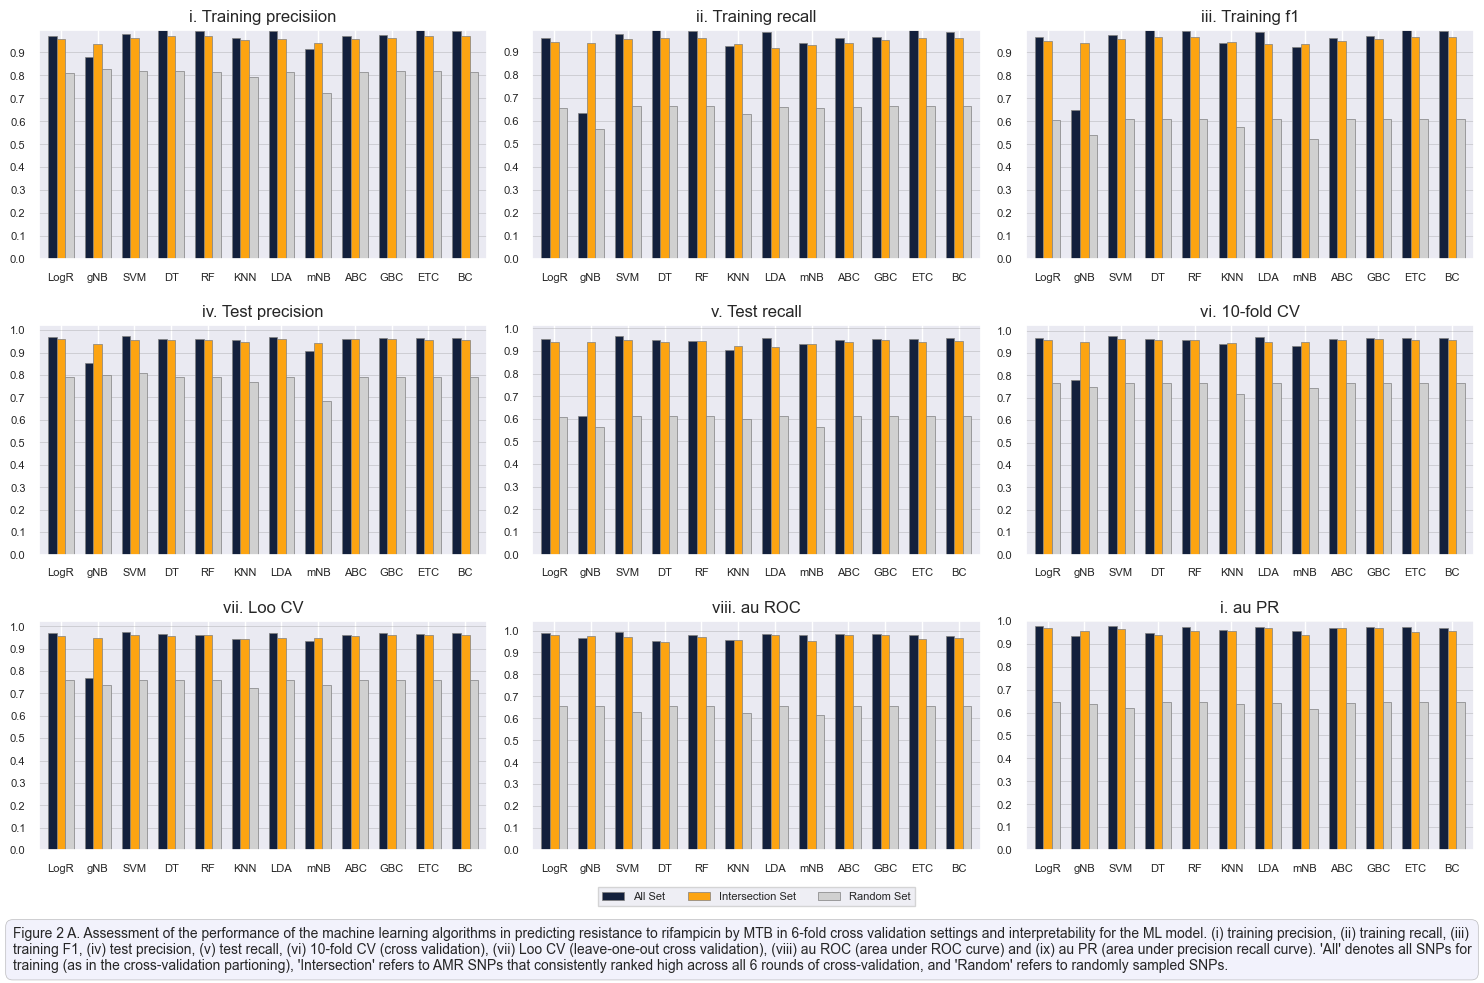

In [2]:
#Dictionary of antibiotics
antb_SN = {'rifampicin': '2 A'}

for antb, SN in antb_SN.items():
    
    #Acronym for Klebsiella pneumoniae
    bacteria = 'MTB'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Mycobacterium tuberculosis}"
    
    #Figure plot number
    supplementary_fig_no = SN
    
    #Import amr-ast data from github repository
    file_name = f'../Data/{antb}.csv'

    #Import bacterial strains without caapenemase from github repository
    To_predict = f'../Data/{antb}_to_predict_MTB.csv'
    
    #no of validation
    validation_no = 6

    # loggingfile config
    logger = logging.getLogger(antb)
    logger.setLevel(logging.INFO)
    rf_handler = logging.StreamHandler(sys.stderr)
    rf_handler.setLevel(logging.DEBUG) 
    rf_handler.setFormatter(logging.Formatter("%(asctime)s - %(name)s - %(message)s"))
    f_handler = logging.FileHandler('{}_{}.txt'.format(antb, time.strftime("%Y-%m-%d%H-%M-%S", time.localtime())))
    f_handler.setLevel(logging.INFO)
    f_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(filename)s[:%(lineno)d] - %(message)s"))
    
    logger.addHandler(rf_handler)
    logger.addHandler(f_handler)
        
    ML_run()


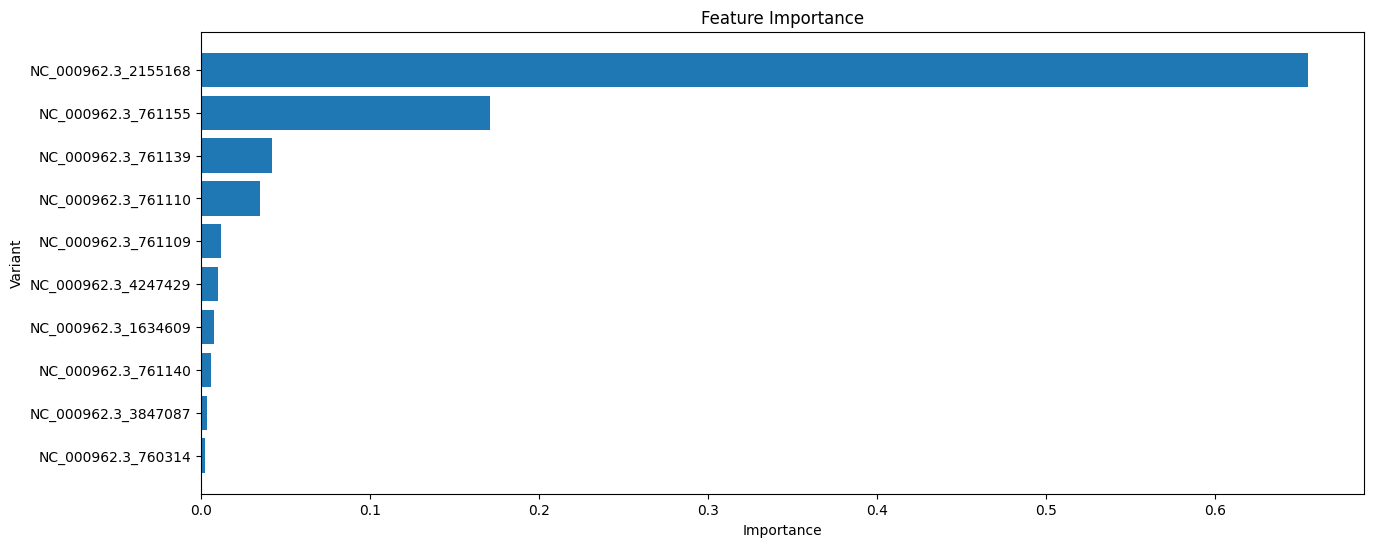

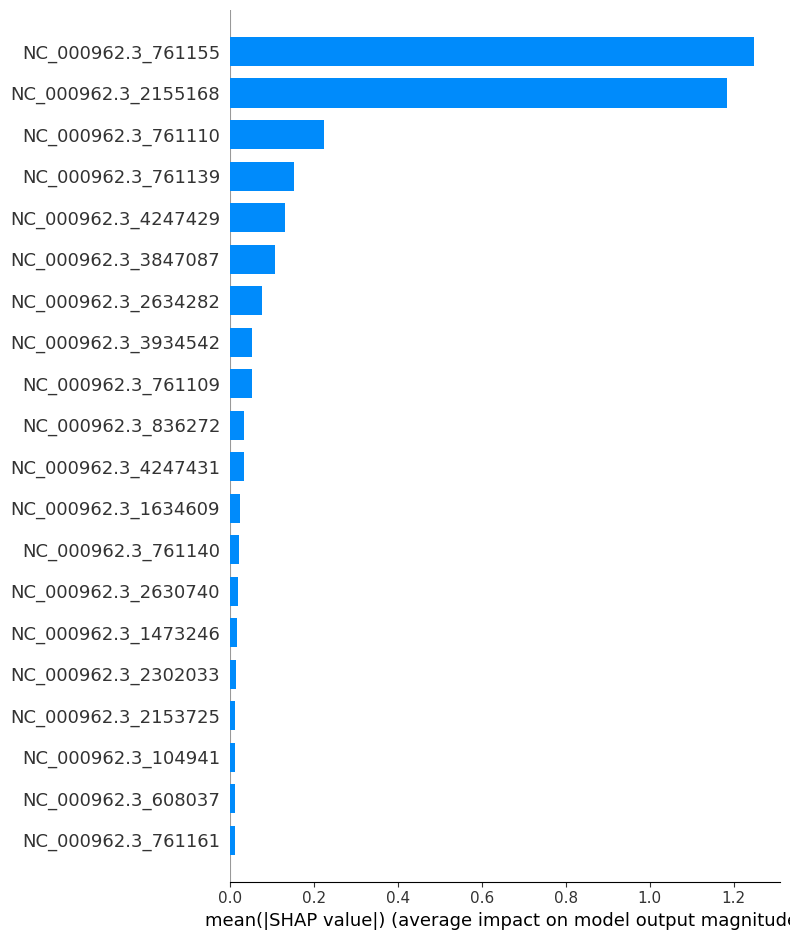

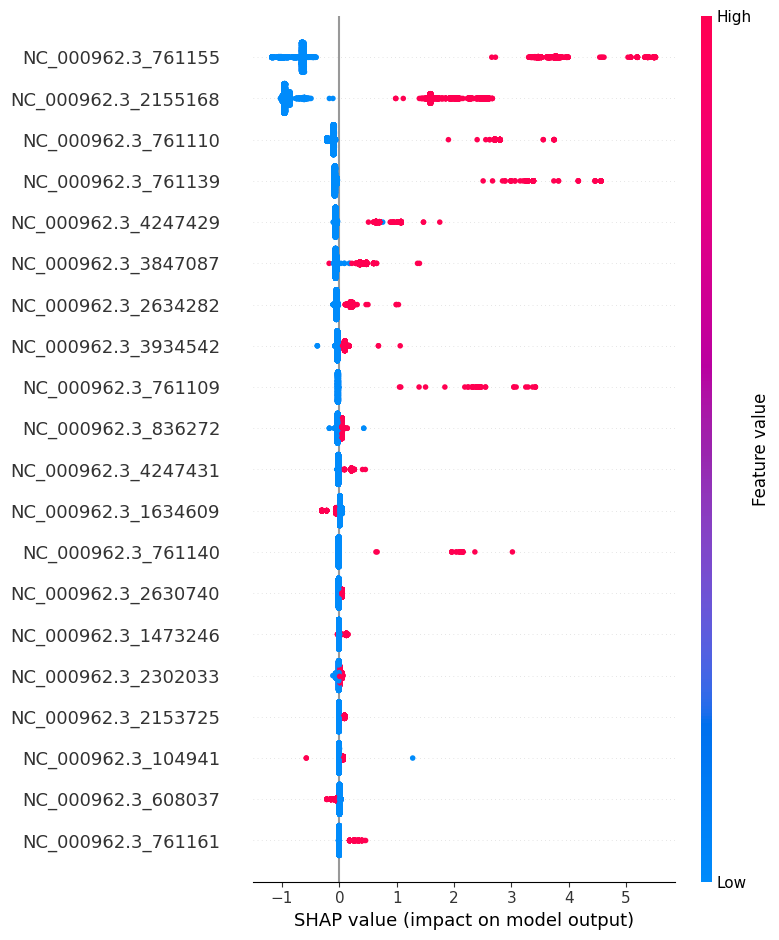

In [10]:
#The optimal Model Importances,SHAP,SHAP summary and force plot 

import pandas as pd
import numpy as np

import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier


def Model_plot():
    Train_data = pd.read_csv(Train)
    data2pre = pd.read_csv(Predict)
    # #Split data into features and labels
    Train_data_X = Train_data.iloc[:, 1:-1] 
    Train_data_Y = Train_data.iloc[:,-1] # last column label
    data2pre_X = data2pre.iloc[:, 1:-1]
    
    # 设置 matplotlib 的样式为白色背景
    plt.style.use('default')  # 先恢复默认样式
    plt.rcParams['axes.facecolor'] = 'white'  # 设置背景颜色为白色
    plt.rcParams['figure.facecolor'] = 'white'  # 设置图形背景颜色为白色
    #Load the Optimal model GBC
    import pickle
    model = pickle.load(open(Classifiers, 'rb'))
    
    #Figure 2B i) feature_importances

    feature_importances = model.feature_importances_
    feature_names = Train_data_X.columns 
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    # Plot feature_importances
    plt.figure(figsize=(15, 6))
    plt.barh(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])  # Top15
    plt.xlabel('Importance')
    plt.ylabel('Variant')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis() 
    plt.show()

        # 设置 matplotlib 的样式为白色背景
    plt.style.use('default')  # 先恢复默认样式
    plt.rcParams['axes.facecolor'] = 'white'  # 设置背景颜色为白色
    plt.rcParams['figure.facecolor'] = 'white'  # 设置图形背景颜色为白色
    #Figure 2B ii) SHAP value
    explainer = shap.TreeExplainer(model)
    shap_values = shap.TreeExplainer(model).shap_values(Train_data_X)
    shap_values2 = explainer(data2pre_X)
    shap.summary_plot(shap_values,Train_data_X, plot_type="bar")
    # 显示图形
    plt.show()

    #Figure 2B iii)：SHAP summary_plot
            # 设置 matplotlib 的样式为白色背景
    plt.style.use('default')  # 先恢复默认样式
    plt.rcParams['axes.facecolor'] = 'white'  # 设置背景颜色为白色
    plt.rcParams['figure.facecolor'] = 'white'  # 设置图形背景颜色为白色
    shap.summary_plot(shap_values, Train_data_X) 
    # 显示图形
    plt.show()

#antibiotics_model
antb_Classifiers = {'rifampicin': 'GBC'}

for antb, Classifiers in antb_Classifiers.items():
    
    #Import amr-ast data from github repository
    Train = f'../Data/{antb}.csv'
    #Import bacterial strains without caapenemase from github repository
    Predict = f'../Data/{antb}_to_predict_MTB.csv'
    
    Classifiers = f'../Figure2/All_fold6_rst/{antb}_{Classifiers}.sav'
    
    Model_plot()
    


In [4]:
data = pd.read_csv('../Data/rifampicin.csv')
data2pre = pd.read_csv('../Data/rifampicin_to_predict_MTB.csv')
# #Split data into features and labels
Train_data_X = data.iloc[:, 1:-1] 
data2pre_X = data2pre.iloc[:, 1:-1]
Train_data_Y = data.iloc[:,-1] # last column label

import pickle
model = pickle.load(open('../Figure2/All_fold6_rst/rifampicin_GBC.sav', 'rb'))

#Figure 2B iv)：force_plots for single isolate
explainer = shap.TreeExplainer(model)
shap_values = shap.TreeExplainer(model).shap_values(Train_data_X)
shap_values2 = explainer(data2pre_X)
shap.initjs()
shap.plots.force(shap_values2[44]) # The index 44 